<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/DNB/DNB_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "DNBNONOK"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-06 00:23:17,217 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-06 00:23:17,218 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for DNBNONOK
2019-09-06 00:23:27,933 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-06 00:26:59,865 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-06 00:34:36,395 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-06 00:38:36,424 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-06 00:42:29,407 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-06 00:46:30,896 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-06 00:50:24,516 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-06 00:54:24,982 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.52097  1.52747  1.51288  1.51598  1.992650
2018-01-02 09:00:00  1.51597  1.51648  1.50347  1.50687  1.553573
2018-01-02 10:00:00  1.50697  1.51097  1.50647  1.50987  0.940126
2018-01-02 11:00:00  1.50998  1.51137  1.50647  1.50838  0.870878
2018-01-02 12:00:00  1.50847  1.51248  1.50797  1.50848  0.927618
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  1.38937  1.39098  1.38587  1.38738  1.600000
2018-12-28 12:00:00  1.38797  1.39048  1.38538  1.39048  1.590000
2018-12-28 13:00:00  1.38987  1.39198  1.38737  1.39138  2.280000
2018-12-28 14:00:00  1.39148  1.39297  1.38498  1.38637  2.670000
2018-12-28 15:00:00  1.38688  1.38747  1.37887  1.37897  1.620000

[1980 rows x 5 columns]

Open         High          Low        Close       Volume
count  1980.000000  1980.000000  1980.000000  1980.000000  1980.000000
mean      1.571156     1.574956     1.567306     1.571204     3.219291
std       0.075456     0.075329     0.075791     0.075616     2.032533
min       1.364380     1.366470     1.354870     1.363970     0.160000
25%       1.518470     1.521273     1.514370     1.518348     1.610000
50%       1.563225     1.566980     1.558670     1.563430     2.830000
75%       1.618980     1.623480     1.614870     1.619372     4.442500
max       1.734870     1.740470     1.729980     1.735380    18.000000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 10:00:00  1.56697  1.56748  1.56097  1.56197  2.491504   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  1.571638  1.549436 -1.575554  1.567082  1.568437  1.569058    1.568975    1.558975  1.571799  1.571036  1.564147  1.571674  1.568780  1.571036  1.565310  1.568213                1.580658                 1.571036                1.561415                1.585469                 1.571036                1.556604                1.590280                 1.571036                1.551793                1.595091                 1.571036                1.546982  1.568437  1.565278  1.569138                1.578059                 1.568437                1.558816                1.582870                 1.568437                1.554005                1.587681                 1.568437                1.549194                1.592492                 1.568437                1.544383   
2018-01-10 11:00:00  1.56198  1.57148  1.56198  1.56997  1.601533   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  1.571555  1.549989 -1.574862  1.567989  1.568778  1.569091    1.568975    1.558975  1.540970  1.570411  1.566146  1.569999  1.568543  1.570411  1.565970  1.568514                1.579568                 1.570411                1.561254                1.584146                 1.570411                1.556676                1.588725                 1.570411                1.552098                1.593303                 1.570411                1.547519  1.568778  1.567936  1.569292                1.577935                 1.568778                1.559621                1.582513                 1.568778                1.555043                1.587091                 1.568778                1.550464                1.591670                 1.568778                1.545886   
2018-01-10 12:00:00  1.5

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000    1930.000000  1930.000000   1930.000000     1930.000000       1930.000000  1930.000000  1930.000000  1930.000000  1930.000000   1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000  1930.000000  1930.000000  1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000   
mean      1.571837     1.575642     1.567953     1.571853     3.267930    15.890674     2.024870   186.316062      30.409326    10.880829      0.032642        0.024352          0.004145     6.629534     2.547150    27.184456     2.024870      1.996373    27.184456     1.572194     1.572925     0.091712     1.571850     1.572192     1.571529     1.572163     1.571930     1.571636     1.572188     1.571848     1.572187     1.572076     1.572188     1.571930     1.572874                1.584494                 1.572188                1.559882                1.590647                 1.572188                1.553728                1.596800                 1.572188                1.547575                1.602953                 1.572188                1.541422     1.572192     1.571927     1.572774                1.584498                 1.572192                1.559885                1.590651                 1.572192                1.553732                1.596804   
std       0.076215     0.076082     0.076568     0.076385     2.033303     8.577459     1.413628   101.631867       0.859983     2.337579      0.177745        0.154180          0.064265     3.345813     1.101441    14.517117     1.413628      1.406306    14.517117     0.075487     0.073516     1.571602     0.076484     0.075384     0.075935     0.075552     0.075437     0.075828     0.075563     0.076473     0.075652     0.075763     0.075563     0.076182     0.074040                0.074419                 0.075563                0.077954                0.074335                 0.075563                0.079584                0.074578                 0.075563                0.081482                0.075147                 0.075563                0.083629     0.075384     0.076129     0.074261                0.074193                 0.075384                0.077822                0.074086                 0.075384                0.079475                0.074309   
min       1.364380     1.366470     1.354870     1.363970     0.160000     1.000000     0.000000    10.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 10:00:00  0.546816  0.537460  0.549439  0.533103  0.130690   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  0.561417  0.493889  0.047616  0.549010  0.552750  0.557633    0.554565    0.527762  0.562576  0.561394  0.538033  0.561586  0.553899  0.561394  0.543099  0.549205                0.566972                 0.561394                0.559895                0.563950                 0.561394                0.598364                0.546189                 0.561394                0.631509                0.526827                 0.561394                0.659283  0.552750  0.541199  0.553095                0.558179                 0.552750                0.562018                0.550499                 0.552750                0.602966                0.540033                 0.552750                0.636137                0.525149                 0.552750   
2018-01-10 11:00:00  0.533348  0.548155  0.552131  0.554643  0.080803   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.561182  0.495533  0.047816  0.551482  0.553702  0.557727    0.554565    0.527762  0.482624  0.559665  0.543497  0.556947  0.553243  0.559665  0.544898  0.550077                0.563992                 0.559665                0.559461                0.560392                 0.559665                0.598541                0.542179                 0.559665                0.632185                0.522426                 0.559665                0.660367  0.553702  0.548470  0.553541                0.557835                 0.553702                0.564174                0.549537                 0.553702                0.605456                0.538491                 0.553702                0.638891                0.523080                 0.553702   
2018-01-10 12:00:00  0.556263  0.546818  0.564101  0.550631  0.060077   10          2         10         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpi_nyu5lm
  JVM stdout: /tmp/tmpi_nyu5lm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpi_nyu5lm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_ta8mcp
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.764732  1.199759              0.320920  0.610038  0.372147
1  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.753888  0.760126              0.302300  0.480860  0.231227
2  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.749288  0.632082              0.343647  0.471784  0.222580
3  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.737349  0.621787              0.299124  0.464908  0.216139
4  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.731654  0.631630              0.352629  0.472943  0.223675
5  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.720537  0.628778              0.386254  0.470314  0.221196
6  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.689650  5.625792              0.392169  0.700351  0.490491
7              DeepLearning_1_AutoML_20190906_011758  0.686528  1.477928              0.340361  0.665867  0.443379
8  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.649179  1.059293              0.413527  0.565994  0.320349
9  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.603614  1.509393              0.407393  0.617317  0.381081

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004068
1               CDLEVENINGSTAR             0.907677           0.907677    0.003693
2            CDLDARKCLOUDCOVER             0.789772           0.789772    0.003213
3              CDLSHOOTINGSTAR             0.783146           0.783146    0.003186
4          CDLGAPSIDESIDEWHITE             0.782017           0.782017    0.003181
...                        ...                  ...                ...         ...
1031        CDLSEPARATINGLINES             0.183068           0.183068    0.000745
1032                    MAX_24             0.183007           0.183007    0.000745
1033  BBANDS_middleband_24_0_5             0.182303           0.182303    0.000742
1034            CDL3LINESTRIKE             0.177951           0.177951    0.000724
1035   BBANDS_lowerband_24_0_2             0.177226           0.177226    0.000721

[1036 rows x 4 columns]

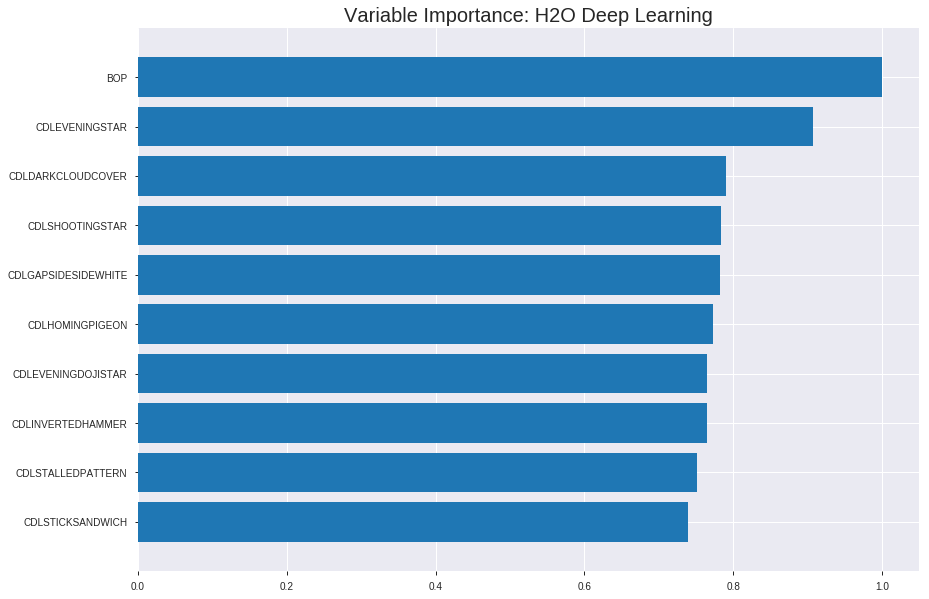

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_011758_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17967501163359
RMSE: 0.4238808932159953
LogLoss: 0.5561742490454945
Mean Per-Class Error: 0.2573833626760563
AUC: 0.811531690140845
pr_auc: 0.770800278671581
Gini: 0.6230633802816901
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36010828328804345: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      440  270  0.3803   (270.0/710.0)
1      89   551  0.1391   (89.0/640.0)
Total  529  821  0.2659   (359.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360108     0.754278  253
max f2                       0.135385     0.841598  333
max f0point5                 0.697159     0.734475  131
max accuracy                 0.43703      0.737778  230
max precision                0.999508     1         0
max recall                   0.00503989   1         396
max specificity              0.999508     1         0
max absolute_mcc             0.360108     0.491648  253
max min_per_class_accuracy   0.527129     0.732394  196
max mean_per_class_accuracy  0.401026     0.742617  240

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.991117           1.65737   1.65737            0.785714         0.995807   0.785714                    0.995807            0.0171875       0.0171875                  65.7366   65.7366
    2        0.02                        0.982049           1.78486   1.71875            0.846154         0.987948   0.814815                    0.992023            0.0171875       0.034375                   78.4856   71.875
    3        0.0303704                   0.973917           1.95871   1.80069            0.928571         0.977609   0.853659                    0.987101            0.0203125       0.0546875                  95.8705   80.0686
    4        0.04                        0.967199           1.94712   1.83594            0.923077         0.971075   0.87037                     0.983243            0.01875         0.0734375                  94.7115   83.5937
    5        0.0503704                   0.960736           1.95871   1.86121            0.928571         0.963794   0.882353                    0.979239            0.0203125       0.09375                    95.8705   86.1213
    6        0.1                         0.923518           1.88899   1.875              0.895522         0.940586   0.888889                    0.960056            0.09375         0.1875                     88.8993   87.5
    7        0.15037                     0.876003           1.76815   1.83921            0.838235         0.902914   0.871921                    0.940915            0.0890625       0.276562                   76.8153   83.9209
    8        0.2                         0.843053           1.57416   1.77344            0.746269         0.859307   0.840741                    0.920664            0.078125        0.354687                   57.416    77.3438
    9        0.3                         0.747843           1.53125   1.69271            0.725926         0.801646   0.802469                    0.880991            0.153125        0.507812                   53.125    69.2708
    10       0.4                         0.638886           1.29688   1.59375            0.614815         0.693249   0.755556                    0.834056            0.129688        0.6375                     29.6875   59.375
    11       0.5                         0.511939           1.07812   1.49062            0.511111         0.579936   0.706667                    0.783232            0.107813        0.745313                   7.8125    49.0625
    12       0.6                         0.367373           1.0625    1.41927            0.503704         0.446854   0.67284                     0.727169            0.10625         0.851562                   6.25      41.9271
    13       0.7                         0.241654           0.578125  1.29911            0.274074         0.303321   0.615873                    0.666619            0.0578125       0.909375                   -42.1875  29.9107
    14       0.8                         0.126255           0.453125  1.19336            0.214815         0.18159    0.565741                    0.60599             0.0453125       0.954688                   -54.6875  19.3359
    15       0.9                         0.0442469          0.1875    1.0816             0.0888889        0.0829885  0.512757                    0.547879            0.01875         0.973437                   -81.25    8.15972
    16       1                           6.26253e-05        0.265625  1                  0.125926         0.0192237  0.474074                    0.49



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2576327667820587
RMSE: 0.5075753803939458
LogLoss: 0.7981463405673003
Mean Per-Class Error: 0.35767577649825644
AUC: 0.6908874651961182
pr_auc: 0.6316881504785652
Gini: 0.3817749303922364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1197452915581321: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   139  0.6651   (139.0/209.0)
1      20   157  0.113    (20.0/177.0)
Total  90   296  0.4119   (159.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.119745     0.663848  295
max f2                       0.00917923   0.818686  372
max f0point5                 0.773442     0.620272  120
max accuracy                 0.773442     0.65285   120
max precision                0.997007     0.857143  6
max recall                   0.00917923   1         372
max specificity              0.999018     0.995215  0
max absolute_mcc             0.773442     0.297175  120
max min_per_class_accuracy   0.518602     0.636364  188
max mean_per_class_accuracy  0.276394     0.642324  247

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 49.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.998012           1.63559   1.63559            0.75             0.998751   0.75                        0.998751            0.0169492       0.0169492                  63.5593   63.5593
    2        0.0207254                   0.990363           1.63559   1.63559            0.75             0.995899   0.75                        0.997325            0.0169492       0.0338983                  63.5593   63.5593
    3        0.0310881                   0.985221           1.63559   1.63559            0.75             0.98871    0.75                        0.994453            0.0169492       0.0508475                  63.5593   63.5593
    4        0.0414508                   0.975014           1.0904    1.49929            0.5              0.980786   0.6875                      0.991036            0.0112994       0.0621469                  9.03955   49.9294
    5        0.0518135                   0.965312           2.18079   1.63559            1                0.969485   0.75                        0.986726            0.0225989       0.0847458                  118.079   63.5593
    6        0.101036                    0.939752           1.6069    1.62161            0.736842         0.952795   0.74359                     0.970195            0.079096        0.163842                   60.6899   62.1614
    7        0.150259                    0.897482           1.26256   1.50399            0.578947         0.918138   0.689655                    0.953142            0.0621469       0.225989                   26.2563   50.3994
    8        0.202073                    0.851561           1.52655   1.50978            0.7              0.874964   0.692308                    0.933096            0.079096        0.305085                   52.6554   50.9778
    9        0.300518                    0.780346           1.31995   1.44759            0.605263         0.817113   0.663793                    0.895102            0.129944        0.435028                   31.9952   44.7594
    10       0.401554                    0.681238           1.06244   1.35068            0.487179         0.729909   0.619355                    0.853537            0.107345        0.542373                   6.24366   35.0683
    11       0.5                         0.498265           1.03301   1.28814            0.473684         0.592084   0.590674                    0.802059            0.101695        0.644068                   3.30062   28.8136
    12       0.601036                    0.359448           0.950601  1.23139            0.435897         0.4234     0.564655                    0.738405            0.0960452       0.740113                   -4.93988  23.1395
    13       0.699482                    0.203627           0.860839  1.17924            0.394737         0.269734   0.540741                    0.672444            0.0847458       0.824859                   -13.9161  17.9243
    14       0.800518                    0.0953031          0.72693   1.12215            0.333333         0.142271   0.514563                    0.605529            0.0734463       0.898305                   -27.307   12.2155
    15       0.898964                    0.0321961          0.631282  1.0684             0.289474         0.0577822  0.489914                    0.545545            0.0621469       0.960452                   -36.8718  6.8399
    16       1                           6.43894e-06        0.391424  1                  0.179487         0.015577   0.458549                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:21:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:21:12  3 min  8.306 sec  456 obs/sec       0.451111  1             609        0.589302         2.31206             -0.392853      0.619016        0.550556           1.65737          0.525926                         0.638599           3.38118               -0.642521        0.571784          0.545418             2.18079            0.525907
    2019-09-06 01:21:24  3 min 20.109 sec  510 obs/sec       4.57407   10            6175       0.551157         2.0379              -0.218373      0.708014        0.447316           1.5067           0.376296                         0.639935           3.73299               -0.649404        0.675371          0.401656             2.18079            0.458549
    2019-09-06 01:21:35  3 min 30.768 sec  517 obs/sec       8.30519   18            11212      0.555719         2.14525             -0.238627      0.702502        0.489506           1.20536          0.363704                         0.619914           3.71723               -0.547809        0.623861          0.497706             1.63559            0.409326
    2019-09-06 01:21:46  3 min 42.170 sec  525 obs/sec       12.4474   27            16804      0.467847         0.982418            0.122118       0.792176        0.625233           1.95871          0.283704                         0.577676           1.91893               -0.344075        0.717068          0.585474             2.18079            0.42487
    2019-09-06 01:21:57  3 min 53.327 sec  533 obs/sec       16.6237   36            22442      0.512929         1.20962             -0.055222      0.748515        0.660367           1.80804          0.377778                         0.520181           1.34385               -0.0898424       0.723732          0.694909             2.18079            0.409326
    2019-09-06 01:22:09  4 min  4.627 sec  523 obs/sec       20.2963   44            27400      0.537491         1.75952             -0.158702      0.6923          0.637576           1.35603          0.336296                         0.651384           3.91236               -0.708951        0.582948          0.523244             2.18079            0.437824
    2019-09-06 01:22:20  4 min 15.928 sec  526 obs/sec       24.4222   53            32970      0.450319         0.659776            0.186665       0.792979        0.754212           2.10938          0.285926                         0.490168           0.806476              0.0322915        0.730679          0.715111             2.18079            0.362694
    2019-09-06 01:22:31  4 min 27.314 sec  529 obs/sec       28.58     62            38583      0.472483         0.729565            0.104633       0.754407        0.692537           1.65737          0.312593                         0.555794           1.11073               -0.244178        0.64469           0.575284             2.18079            0.396373
    2019-09-06 01:22:42 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.004068258704301564
CDLEVENINGSTAR            0.9076766967773438     0.9076766967773438   0.0036926636223561203
CDLDARKCLOUDCOVER         0.789771556854248      0.789771556854248    0.0032129950105820922
CDLSHOOTINGSTAR           0.7831460237503052     0.7831460237503052   0.0031860406278613387
CDLGAPSIDESIDEWHITE       0.7820170521736145     0.7820170521736145   0.0031814476794175574
---                       ---                    ---                  ---
CDLSEPARATINGLINES        0.1830679178237915     0.1830679178237915   0.0007447676501650032
MAX_24                    0.18300732970237732    0.18300732970237732  0.0007445211620126827
BBANDS_middleband_24_0_5  0.18230341374874115    0.18230341374874115  0.0007416574498072056
CDL3LINESTRIKE            0.17795075476169586    0.17795075476169586  0.0007239497069963022
BBANDS_lowerband_24_0_2   0.17722561955451965    0.17722561955451965  0.0007209996693779121


See the whole table with table.as_data_frame()


('accuracy', 0.7409326424870466)

('F1', 0.6880733944954129)

('auc', 0.7647316538882803)

('logloss', 1.1997593551467993)

('mean_per_class_error', 0.27606790799561876)

('rmse', 0.6100382247289329)

('mse', 0.372146635630428)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


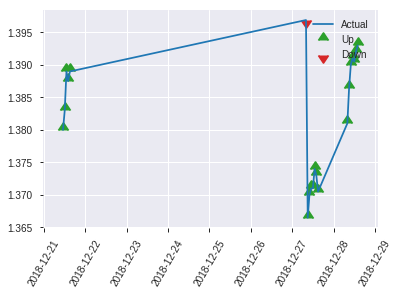


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.372146635630428
RMSE: 0.6100382247289329
LogLoss: 1.1997593551467993
Mean Per-Class Error: 0.27606790799561876
AUC: 0.7647316538882803
pr_auc: 0.6762709121443385
Gini: 0.5294633077765607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8138461427345545: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   60   0.5455   (60.0/110.0)
1      8    75   0.0964   (8.0/83.0)
Total  58   135  0.3523   (68.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.813846     0.688073  134
max f2                       0.784481     0.803758  146
max f0point5                 0.951314     0.712251  66
max accuracy                 0.951314     0.740933  66
max precision                0.99985      1         0
max recall                   0.192174     1         186
max specificity              0.99985      1         0
max absolute_mcc             0.951314     0.465757  66
max min_per_class_accuracy   0.913979     0.698795  87
max mean_per_class_accuracy  0.951314     0.723932  66

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 82.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999158           1.16265   1.16265            0.5              0.999796  0.5                         0.999796            0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.998033           2.3253    1.74398            1                0.999018  0.75                        0.999407            0.0240964       0.0361446                  132.53    74.3976
    3        0.0310881                   0.997376           2.3253    1.93775            1                0.997719  0.833333                    0.998845            0.0240964       0.060241                   132.53    93.7751
    4        0.0414508                   0.996141           1.16265   1.74398            0.5              0.996737  0.75                        0.998318            0.0120482       0.0722892                  16.2651   74.3976
    5        0.0518135                   0.995954           1.16265   1.62771            0.5              0.996048  0.7                         0.997864            0.0120482       0.0843373                  16.2651   62.7711
    6        0.103627                    0.991489           1.86024   1.74398            0.8              0.994469  0.75                        0.996166            0.0963855       0.180723                   86.0241   74.3976
    7        0.150259                    0.987849           2.06693   1.8442             0.888889         0.989927  0.793103                    0.99423             0.0963855       0.277108                   106.693   84.4204
    8        0.202073                    0.981665           1.86024   1.84832            0.8              0.984541  0.794872                    0.991746            0.0963855       0.373494                   86.0241   84.8316
    9        0.300518                    0.962509           1.46861   1.72393            0.631579         0.9738    0.741379                    0.985867            0.144578        0.518072                   46.8611   72.393
    10       0.398964                    0.929518           1.10146   1.57033            0.473684         0.949536  0.675325                    0.976902            0.108434        0.626506                   10.1458   57.0333
    11       0.502591                    0.9017             0.69759   1.39039            0.3              0.914592  0.597938                    0.964054            0.0722892       0.698795                   -30.241   39.0386
    12       0.601036                    0.864954           1.10146   1.34306            0.473684         0.883245  0.577586                    0.950818            0.108434        0.807229                   10.1458   34.3062
    13       0.699482                    0.813383           0.979074  1.29183            0.421053         0.840601  0.555556                    0.935306            0.0963855       0.903614                   -2.09258  29.1834
    14       0.797927                    0.737537           0.244769  1.16265            0.105263         0.784642  0.5                         0.916718            0.0240964       0.927711                   -75.5231  16.2651
    15       0.896373                    0.543651           0.489537  1.08872            0.210526         0.6453    0.468208                    0.886909            0.0481928       0.975904                   -51.0463  8.87248
    16       1                           0.00782266         0.23253   1                  0.1              0.249229  0.430052                    0.820828          

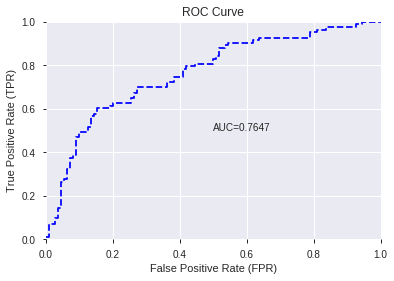

This function is available for GLM models only


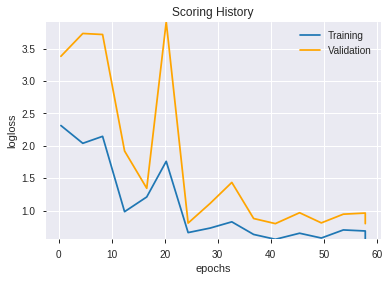

--2019-09-06 01:52:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.7MB/s    in 29s     

2019-09-06 01:52:55 (12.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_011758_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_011758_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_015309_model_3  0.753341  0.696044              0.317744  0.465369  0.216568
1  DeepLearning_grid_1_AutoML_20190906_015309_model_8  0.748412  0.607523              0.299343  0.460020  0.211619
2  DeepLearning_grid_1_AutoML_20190906_015309_model_9  0.747645  0.585953              0.329901  0.449942  0.202448
3  DeepLearning_grid_1_AutoML_20190906_015309_model_5  0.747317  0.588167              0.313089  0.447985  0.200690
4  DeepLearning_grid_1_AutoML_20190906_015309_model_6  0.732092  0.633488              0.323768  0.465718  0.216893
5  DeepLearning_grid_1_AutoML_20190906_015309_model_4  0.730997  0.787126              0.288664  0.483326  0.233604
6  DeepLearning_grid_1_AutoML_20190906_015309_model_7  0.729244  0.713455              0.378642  0.477698  0.228196
7               DeepLearning_1_AutoML_20190906_015309  0.720482  0.624328              0.380120  0.462273  0.213696
8  DeepLearning_grid_1_AutoML_20190906_015309_model_1  0.702081  0.984086              0.415005  0.527029  0.277760
9  DeepLearning_grid_1_AutoML_20190906_015309_model_2  0.684337  0.851605              0.411939  0.517291  0.267590

variable  relative_importance  scaled_importance  percentage
0    CDLEVENINGDOJISTAR             1.000000           1.000000    0.029922
1    CDLMORNINGDOJISTAR             0.969356           0.969356    0.029005
2        CDLEVENINGSTAR             0.967569           0.967569    0.028952
3     CDLSTALLEDPATTERN             0.962471           0.962471    0.028799
4       CDLHOMINGPIGEON             0.951454           0.951454    0.028469
5      CDLSTICKSANDWICH             0.943323           0.943323    0.028226
6       CDLLADDERBOTTOM             0.932941           0.932941    0.027915
7   CDLGAPSIDESIDEWHITE             0.930895           0.930895    0.027854
8             CDLONNECK             0.907646           0.907646    0.027159
9           CDLPIERCING             0.900170           0.900170    0.026935
10    CDL3WHITESOLDIERS             0.889610           0.889610    0.026619
11   CDLIDENTICAL3CROWS             0.888977           0.888977    0.026600
12         CDLTHRUSTING             0.882868           0.882868    0.026417
13    CDLDARKCLOUDCOVER             0.866867           0.866867    0.025938
14      CDLSHOOTINGSTAR             0.853659           0.853659    0.025543
15   CDLCLOSINGMARUBOZU             0.815429           0.815429    0.024399
16        CDLHIKKAKEMOD             0.758822           0.758822    0.022705
17      CDLADVANCEBLOCK             0.739933           0.739933    0.022140
18    CDLINVERTEDHAMMER             0.726987           0.726987    0.021753
19        CDLHANGINGMAN             0.719982           0.719982    0.021543
20  CDLRISEFALL3METHODS             0.696497           0.696497    0.020841
21       is_month_start             0.687602           0.687602    0.020574
22                  BOP             0.682990           0.682990    0.020436
23         CDLTASUKIGAP             0.633569           0.633569    0.018958
24           CDL3INSIDE             0.618782           0.618782    0.018515
25          CDLLONGLINE             0.602386           0.602386    0.018025
26            CDLTAKURI             0.591441           0.591441    0.017697
27                 hour             0.591365           0.591365    0.017695
28    CDLGRAVESTONEDOJI             0.588156           0.588156    0.017599
29       CDLMORNINGSTAR             0.588033           0.588033    0.017595
30            CDLHAMMER             0.582376           0.582376    0.017426
31     CDLDRAGONFLYDOJI             0.581702           0.581702    0.017406
32             CORREL_8             0.577351           0.577351    0.017275
33         is_month_end             0.574196           0.574196    0.017181
34               TRANGE             0.508720           0.508720    0.015222
35                  SUB             0.503179           0.503179    0.015056
36                  DIV             0.499134           0.499134    0.014935
37         CDLSHORTLINE             0.480776           0.480776    0.014386
38       CDLMATCHINGLOW             0.472656           0.472656    0.014143
39            CORREL_24             0.464212           0.464212    0.013890
40            aroonup_8             0.452958           0.452958    0.013553
41              WILLR_8             0.449764           0.449764    0.013458
42        days_in_month             0.449230           0.449230    0.013442
43            CORREL_20             0.447730           0.447730    0.013397
44         STOCHF_fastk             0.445312           0.445312    0.013325
45         weekday_name             0.426863           0.426863    0.012773
46       STOCHRSI_fastd             0.425310           0.425310    0.012726
47           AROONOSC_8             0.418793           0.418793    0.012531
48            dayofweek             0.394961           0.394961    0.011818
49              weekday             0.375284           0.375284    0.011229

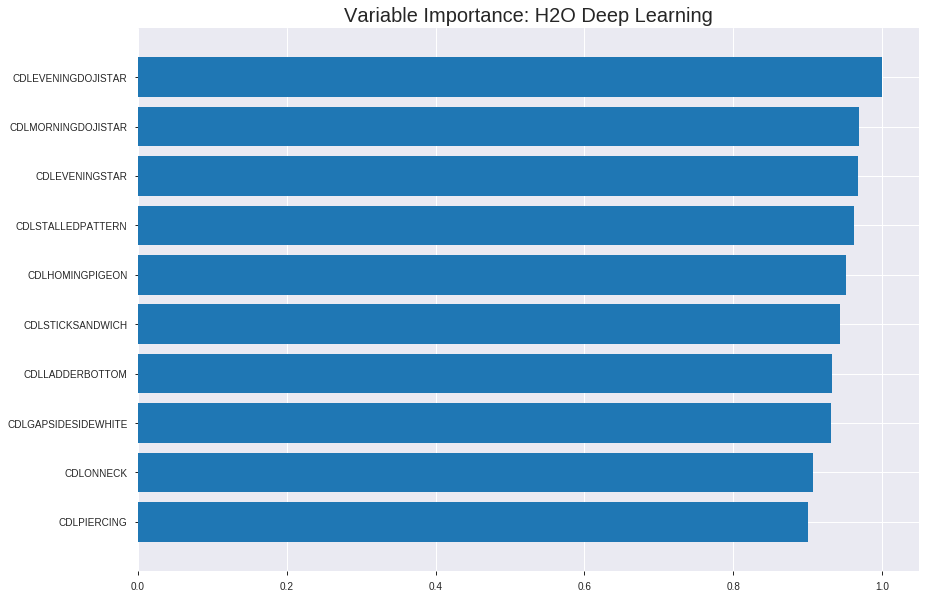

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_015309_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17978591961126233
RMSE: 0.42401169749343276
LogLoss: 0.6029314125818246
Mean Per-Class Error: 0.2604533450704225
AUC: 0.8157042253521126
pr_auc: 0.7472888441074861
Gini: 0.6314084507042252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4065514909319088: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      429  281  0.3958   (281.0/710.0)
1      83   557  0.1297   (83.0/640.0)
Total  512  838  0.2696   (364.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406551     0.753721  240
max f2                       0.227363     0.848847  305
max f0point5                 0.715545     0.734252  118
max accuracy                 0.559808     0.74      177
max precision                0.962974     0.862275  24
max recall                   0.000215833  1         399
max specificity              0.999878     0.991549  0
max absolute_mcc             0.406551     0.488352  240
max min_per_class_accuracy   0.542799     0.73662   184
max mean_per_class_accuracy  0.525446     0.739547  191

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.999832           1.35603   1.35603            0.642857         0.999939   0.642857                    0.999939            0.0140625       0.0140625                  35.6027   35.6027
    2        0.02                        0.999445           1.78486   1.5625             0.846154         0.999662   0.740741                    0.999806            0.0171875       0.03125                    78.4856   56.25
    3        0.0303704                   0.998814           1.95871   1.69779            0.928571         0.999182   0.804878                    0.999593            0.0203125       0.0515625                  95.8705   69.779
    4        0.04                        0.998215           1.78486   1.71875            0.846154         0.998491   0.814815                    0.999328            0.0171875       0.06875                    78.4856   71.875
    5        0.0503704                   0.997407           1.80804   1.73713            0.857143         0.997917   0.823529                    0.999037            0.01875         0.0875                     80.8036   73.7132
    6        0.1                         0.983457           1.82603   1.78125            0.865672         0.992413   0.844444                    0.99575             0.090625        0.178125                   82.6026   78.125
    7        0.15037                     0.938244           1.86121   1.80804            0.882353         0.961051   0.857143                    0.984126            0.09375         0.271875                   86.1213   80.8036
    8        0.2                         0.885492           1.63713   1.76562            0.776119         0.90986    0.837037                    0.965697            0.08125         0.353125                   63.7127   76.5625
    9        0.3                         0.75992            1.64062   1.72396            0.777778         0.821775   0.817284                    0.917723            0.164062        0.517188                   64.0625   72.3958
    10       0.4                         0.650765           1.23437   1.60156            0.585185         0.712487   0.759259                    0.866414            0.123438        0.640625                   23.4375   60.1562
    11       0.5                         0.52968            1.07812   1.49687            0.511111         0.590105   0.70963                     0.811152            0.107813        0.748437                   7.8125    49.6875
    12       0.6                         0.434064           0.953125  1.40625            0.451852         0.481574   0.666667                    0.756223            0.0953125       0.84375                    -4.6875   40.625
    13       0.7                         0.313132           0.75      1.3125             0.355556         0.373158   0.622222                    0.701499            0.075           0.91875                    -25       31.25
    14       0.8                         0.182101           0.421875  1.20117            0.2              0.24639    0.569444                    0.64461             0.0421875       0.960938                   -57.8125  20.1172
    15       0.9                         0.0611901          0.265625  1.09722            0.125926         0.117182   0.520165                    0.586007            0.0265625       0.9875                     -73.4375  9.72222
    16       1                           2.36888e-05        0.125     1                  0.0592593        0.0252286  0.474074                    0.52992



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2221909068247698
RMSE: 0.4713713046259496
LogLoss: 0.742963735976473
Mean Per-Class Error: 0.30755818668396717
AUC: 0.7346795339658855
pr_auc: 0.6906404806306149
Gini: 0.46935906793177096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3230891123304272: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  103  0.4928   (103.0/209.0)
1      33   144  0.1864   (33.0/177.0)
Total  139  247  0.3523   (136.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323089     0.679245  246
max f2                       0.0344481    0.824694  352
max f0point5                 0.594361     0.684564  141
max accuracy                 0.594361     0.702073  141
max precision                0.987284     0.896552  28
max recall                   0.000392574  1         383
max specificity              1            0.995215  0
max absolute_mcc             0.594361     0.397695  141
max min_per_class_accuracy   0.457073     0.655367  186
max mean_per_class_accuracy  0.594361     0.692442  141

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 48.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999897           1.0904    1.0904             0.5              0.999996   0.5                         0.999996            0.0112994       0.0112994                  9.03955   9.03955
    2        0.0207254                   0.999445           2.18079   1.63559            1                0.999655   0.75                        0.999825            0.0225989       0.0338983                  118.079   63.5593
    3        0.0310881                   0.998704           2.18079   1.81733            1                0.999122   0.833333                    0.999591            0.0225989       0.0564972                  118.079   81.7326
    4        0.0414508                   0.997989           2.18079   1.90819            1                0.998274   0.875                       0.999262            0.0225989       0.079096                   118.079   90.8192
    5        0.0518135                   0.996865           1.63559   1.85367            0.75             0.99751    0.85                        0.998911            0.0169492       0.0960452                  63.5593   85.3672
    6        0.101036                    0.962052           1.72168   1.78937            0.789474         0.982799   0.820513                    0.991062            0.0847458       0.180791                   72.1677   78.9367
    7        0.150259                    0.898807           1.72168   1.76719            0.789474         0.928306   0.810345                    0.970504            0.0847458       0.265537                   72.1677   76.7193
    8        0.202073                    0.853151           1.52655   1.70549            0.7              0.880219   0.782051                    0.947354            0.079096        0.344633                   52.6554   70.549
    9        0.300518                    0.704575           1.31995   1.57919            0.605263         0.778349   0.724138                    0.89199             0.129944        0.474576                   31.9952   57.9193
    10       0.401554                    0.559066           1.11835   1.46324            0.512821         0.618596   0.670968                    0.823201            0.112994        0.587571                   11.8354   46.324
    11       0.5                         0.436791           0.803449  1.33333            0.368421         0.496259   0.611399                    0.758829            0.079096        0.666667                   -19.6551  33.3333
    12       0.601036                    0.362639           0.894683  1.25959            0.410256         0.404284   0.577586                    0.699229            0.0903955       0.757062                   -10.5317  25.9595
    13       0.699482                    0.262436           0.803449  1.1954             0.368421         0.312455   0.548148                    0.644794            0.079096        0.836158                   -19.6551  19.5397
    14       0.800518                    0.139498           0.72693   1.13627            0.333333         0.188848   0.521036                    0.587247            0.0734463       0.909605                   -27.307   13.627
    15       0.898964                    0.0388452          0.688671  1.08725            0.315789         0.0844987  0.498559                    0.532191            0.0677966       0.977401                   -31.1329  8.72531
    16       1                           8.69598e-05        0.223671  1                  0.102564         0.0182579  0.458549                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:54:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:54:35  1 min 24.735 sec  5544 obs/sec      10        1             13500      0.480489         0.87614             0.0740323      0.753568        0.658885           1.05469          0.32963                          0.49357            0.992685              0.0188129        0.730733          0.678792             1.0904             0.316062
    2019-09-06 01:54:41  1 min 30.548 sec  6622 obs/sec      40        4             54000      0.44026          0.671966            0.222593       0.791899        0.713891           1.35603          0.299259                         0.476782           0.783077              0.0844236        0.729976          0.67699              1.63559            0.375648
    2019-09-06 01:54:47  1 min 36.873 sec  7502 obs/sec      80        8             108000     0.432566         0.636796            0.24953        0.802093        0.715017           1.35603          0.282222                         0.473786           0.756695              0.0958933        0.731733          0.680188             1.0904             0.38601
    2019-09-06 01:54:53  1 min 42.381 sec  8169 obs/sec      120       12            162000     0.433627         0.647132            0.245842       0.802041        0.714319           1.80804          0.291111                         0.466575           0.763771              0.123204         0.743087          0.695679             1.0904             0.38342
    2019-09-06 01:54:58  1 min 47.528 sec  8672 obs/sec      160       16            216000     0.424012         0.602931            0.278918       0.815704        0.747289           1.35603          0.26963                          0.471371           0.742964              0.105086         0.73468           0.69064              1.0904             0.352332
    2019-09-06 01:55:03  1 min 52.548 sec  9044 obs/sec      200       20            270000     0.423424         0.622347            0.280914       0.817233        0.736892           1.65737          0.263704                         0.47289            0.762525              0.0993097        0.734625          0.689028             1.0904             0.391192
    2019-09-06 01:55:09  1 min 58.602 sec  9418 obs/sec      250       25            337500     0.422212         0.618893            0.285025       0.819317        0.721788           1.65737          0.26963                          0.474871           0.78143               0.0917485        0.735058          0.690206             1.0904             0.34456
    2019-09-06 01:55:09  1 min 58.682 sec  9416 obs/sec      250       25            337500     0.424012         0.602931            0.278918       0.815704        0.747289           1.35603          0.26963                          0.471371           0.742964              0.105086         0.73468           0.69064              1.0904             0.352332

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLEVENINGDOJISTAR  1.0                    1.0                  0.02992194244749786
CDLMORNINGDOJISTAR  0.9693557024002075     0.9693557024002075   0.029005005538372874
CDLEVENINGSTAR      0.9675693511962891     0.9675693511962891   0.02895155444045821
CDLSTALLEDPATTERN   0.9624711275100708     0.9624711275100708   0.028799005684734716
CDLHOMINGPIGEON     0.951454222202301      0.951454222202301    0.028469358478166094
---                 ---                    ---                  ---
weekday_name        0.42686259746551514    0.42686259746551514  0.01277255807435259
STOCHRSI_fastd      0.42531007528305054    0.42531007528305054  0.012726103594960422
AROONOSC_8          0.41879305243492126    0.41879305243492126  0.012531101612369668
dayofweek           0.39496076107025146    0.39496076107025146  0.011817993161764018
weekday             0.37528419494628906    0.37528419494628906  0.01122923208263843


See the whole table with table.as_data_frame()


('accuracy', 0.7150259067357513)

('F1', 0.6826923076923076)

('auc', 0.753340635268346)

('logloss', 0.6960442995243913)

('mean_per_class_error', 0.3081051478641841)

('rmse', 0.4653686456437695)

('mse', 0.2165679763483163)

deeplearning prediction progress: |███████████████████████████████████████| 100%


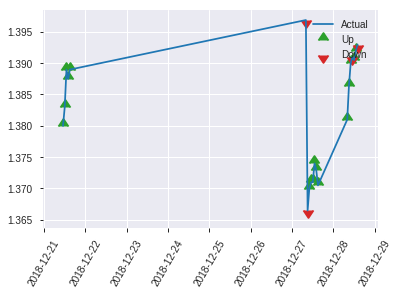


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2165679763483163
RMSE: 0.4653686456437695
LogLoss: 0.6960442995243913
Mean Per-Class Error: 0.3081051478641841
AUC: 0.753340635268346
pr_auc: 0.6739717267597026
Gini: 0.5066812705366921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39098426982509893: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   54   0.4909   (54.0/110.0)
1      12   71   0.1446   (12.0/83.0)
Total  68   125  0.342    (66.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390984     0.682692  124
max f2                       0.0699842    0.813725  177
max f0point5                 0.814133     0.690909  47
max accuracy                 0.814133     0.715026  47
max precision                0.999998     1         0
max recall                   0.0699842    1         177
max specificity              0.999998     1         0
max absolute_mcc             0.814133     0.420247  47
max min_per_class_accuracy   0.554054     0.674699  87
max mean_per_class_accuracy  0.554054     0.691895  87

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 53.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999847           2.3253    2.3253             1                0.999987   1                           0.999987            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.999373           1.16265   1.74398            0.5              0.999635   0.75                        0.999811            0.0120482       0.0361446                  16.2651   74.3976
    3        0.0310881                   0.998522           1.16265   1.5502             0.5              0.999174   0.666667                    0.999599            0.0120482       0.0481928                  16.2651   55.0201
    4        0.0414508                   0.997522           2.3253    1.74398            1                0.998163   0.75                        0.99924             0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.994563           2.3253    1.86024            1                0.996843   0.8                         0.99876             0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.980573           1.86024   1.86024            0.8              0.988856   0.8                         0.993808            0.0963855       0.192771                   86.0241   86.0241
    7        0.150259                    0.959975           1.80857   1.8442             0.777778         0.968603   0.793103                    0.985986            0.0843373       0.277108                   80.8568   84.4204
    8        0.202073                    0.880098           1.62771   1.78869            0.7              0.918336   0.769231                    0.96864             0.0843373       0.361446                   62.7711   78.8693
    9        0.300518                    0.741757           1.46861   1.68384            0.631579         0.808415   0.724138                    0.916152            0.144578        0.506024                   46.8611   68.3839
    10       0.398964                    0.591992           0.85669   1.47974            0.368421         0.66057    0.636364                    0.853087            0.0843373       0.590361                   -14.331   47.9737
    11       0.502591                    0.514325           0.93012   1.36641            0.4              0.555902   0.587629                    0.791811            0.0963855       0.686747                   -6.98795  36.6414
    12       0.601036                    0.443203           0.979074  1.30297            0.421053         0.481787   0.560345                    0.741032            0.0963855       0.783133                   -2.09258  30.2971
    13       0.699482                    0.352308           0.979074  1.25739            0.421053         0.393857   0.540741                    0.69217             0.0963855       0.879518                   -2.09258  25.7385
    14       0.797927                    0.216867           0.489537  1.16265            0.210526         0.292536   0.5                         0.642864            0.0481928       0.927711                   -51.0463  16.2651
    15       0.896373                    0.0732299          0.611921  1.10217            0.263158         0.147775   0.473988                    0.58849             0.060241        0.987952                   -38.8079  10.2166
    16       1                           7.84133e-05        0.116265  1                  0.05             0.0335137  0.430052                    

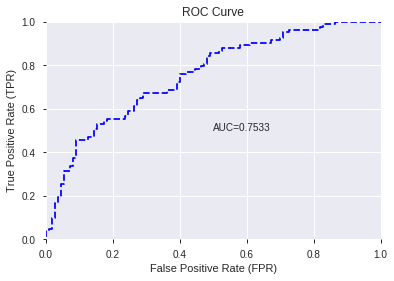

This function is available for GLM models only


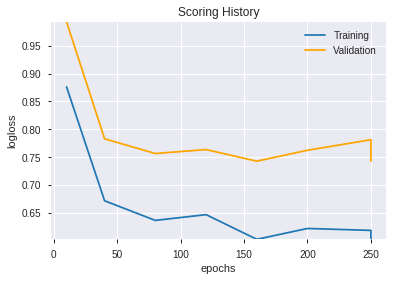

--2019-09-06 02:01:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_015309_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_015309_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLHOMINGPIGEON',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLONNECK',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLHIKKAKEMOD',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLRISEFALL3METHODS',
 'is_month_start',
 'BOP',
 'CDLTASUKIGAP',
 'CDL3INSIDE',
 'CDLLONGLINE',
 'CDLTAKURI',
 'hour',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGSTAR',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'CORREL_8',
 'is_month_end',
 'TRANGE',
 'SUB',
 'DIV',
 'CDLSHORTLINE',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'aroonup_8',
 'WILLR_8',
 'days_in_month',
 'CORREL_20',
 'STOCHF_fastk',
 'weekday_name',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'dayofweek',
 'weekday']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_020141_model_1  0.740745  0.596493              0.328423  0.45312  0.205318

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.289383           1.000000    0.101721
1    CDLCLOSINGMARUBOZU             0.186740           0.645304    0.065641
2                  hour             0.163152           0.563794    0.057350
3          STOCHF_fastk             0.148970           0.514786    0.052365
4               WILLR_8             0.129423           0.447237    0.045494
5           CDLLONGLINE             0.119911           0.414370    0.042150
6            AROONOSC_8             0.104884           0.362440    0.036868
7             aroonup_8             0.102717           0.354952    0.036106
8                   SUB             0.101021           0.349092    0.035510
9                   DIV             0.092916           0.321084    0.032661
10               TRANGE             0.092299           0.318950    0.032444
11      CDLSHOOTINGSTAR             0.088467           0.305710    0.031097
12     CDLDRAGONFLYDOJI             0.086308           0.298249    0.030338
13         CDLSHORTLINE             0.083705           0.289255    0.029423
14       STOCHRSI_fastd             0.081206           0.280620    0.028545
15        CDLHANGINGMAN             0.080548           0.278344    0.028313
16            CDLTAKURI             0.076840           0.265532    0.027010
17            CDLHAMMER             0.075704           0.261606    0.026611
18    CDLGRAVESTONEDOJI             0.064780           0.223855    0.022771
19    CDLDARKCLOUDCOVER             0.063083           0.217991    0.022174
20    CDL3WHITESOLDIERS             0.050316           0.173874    0.017687
21  CDLRISEFALL3METHODS             0.042792           0.147873    0.015042
22      CDLLADDERBOTTOM             0.041719           0.144167    0.014665
23    CDLSTALLEDPATTERN             0.038090           0.131625    0.013389
24   CDLEVENINGDOJISTAR             0.034582           0.119504    0.012156
25    CDLINVERTEDHAMMER             0.033235           0.114849    0.011683
26       CDLEVENINGSTAR             0.033114           0.114430    0.011640
27            CDLONNECK             0.030014           0.103717    0.010550
28         weekday_name             0.026100           0.090192    0.009174
29  CDLGAPSIDESIDEWHITE             0.024444           0.084471    0.008592
30   CDLIDENTICAL3CROWS             0.024021           0.083008    0.008444
31       is_month_start             0.022484           0.077695    0.007903
32            CORREL_24             0.021942           0.075823    0.007713
33       CDLMORNINGSTAR             0.019329           0.066795    0.006794
34     CDLSTICKSANDWICH             0.019009           0.065689    0.006682
35            CORREL_20             0.015986           0.055240    0.005619
36      CDLHOMINGPIGEON             0.015876           0.054861    0.005580
37       CDLMATCHINGLOW             0.014411           0.049798    0.005065
38   CDLMORNINGDOJISTAR             0.014016           0.048434    0.004927
39            dayofweek             0.011798           0.040769    0.004147
40              weekday             0.011752           0.040610    0.004131
41         CDLTASUKIGAP             0.010794           0.037299    0.003794
42          CDLPIERCING             0.010580           0.036561    0.003719
43        days_in_month             0.010188           0.035207    0.003581
44         is_month_end             0.008744           0.030216    0.003074
45      CDLADVANCEBLOCK             0.008523           0.029451    0.002996
46             CORREL_8             0.007551           0.026093    0.002654
47        CDLHIKKAKEMOD             0.007164           0.024755    0.002518
48           CDL3INSIDE             0.003252           0.011236    0.001143
49         CDLTHRUSTING             0.000978           0.003380    0.000344

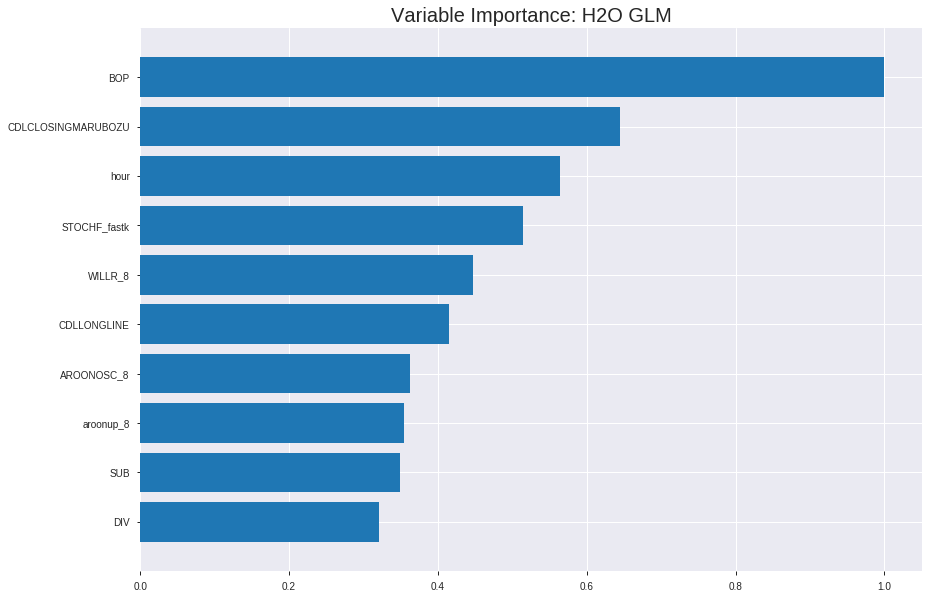

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_020141_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19456682446231416
RMSE: 0.4410972959136274
LogLoss: 0.5737772204427809
Null degrees of freedom: 1349
Residual degrees of freedom: 1299
Null deviance: 1867.8661296847088
Residual deviance: 1549.1984951955085
AIC: 1651.1984951955085
AUC: 0.7832130281690141
pr_auc: 0.7326784109256458
Gini: 0.5664260563380281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4045263041396613: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      402  308  0.4338   (308.0/710.0)
1      99   541  0.1547   (99.0/640.0)
Total  501  849  0.3015   (407.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404526     0.726662  240
max f2                       0.262538     0.838468  325
max f0point5                 0.507939     0.713324  177
max accuracy                 0.507939     0.722222  177
max precision                0.939094     1         0
max recall                   0.125817     1         385
max specificity              0.939094     1         0
max absolute_mcc             0.488959     0.442471  187
max min_per_class_accuracy   0.479084     0.714085  194
max mean_per_class_accuracy  0.488959     0.720973  187

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.859746           1.5067    1.5067             0.714286         0.889104  0.714286                    0.889104            0.015625        0.015625                   50.6696   50.6696
    2        0.02                        0.831924           1.6226    1.5625             0.769231         0.845325  0.740741                    0.868025            0.015625        0.03125                    62.2596   56.25
    3        0.0303704                   0.812628           1.65737   1.59489            0.785714         0.822591  0.756098                    0.852511            0.0171875       0.0484375                  65.7366   59.4893
    4        0.04                        0.797761           2.10938   1.71875            1                0.804773  0.814815                    0.841018            0.0203125       0.06875                    110.938   71.875
    5        0.0503704                   0.780127           1.80804   1.73713            0.857143         0.789887  0.823529                    0.830491            0.01875         0.0875                     80.8036   73.7132
    6        0.1                         0.717527           1.92048   1.82812            0.910448         0.74533   0.866667                    0.788226            0.0953125       0.182812                   92.0476   82.8125
    7        0.15037                     0.673683           1.55101   1.7353             0.735294         0.694758  0.82266                     0.756916            0.078125        0.260937                   55.1011   73.5299
    8        0.2                         0.635992           1.51119   1.67969            0.716418         0.655461  0.796296                    0.731741            0.075           0.335938                   51.1194   67.9688
    9        0.3                         0.579963           1.39062   1.58333            0.659259         0.604536  0.750617                    0.689339            0.139063        0.475                      39.0625   58.3333
    10       0.4                         0.522194           1.39062   1.53516            0.659259         0.553655  0.727778                    0.655418            0.139063        0.614062                   39.0625   53.5156
    11       0.5                         0.475074           1.15625   1.45937            0.548148         0.497654  0.691852                    0.623865            0.115625        0.729688                   15.625    45.9375
    12       0.6                         0.418214           0.859375  1.35938            0.407407         0.445587  0.644444                    0.594152            0.0859375       0.815625                   -14.0625  35.9375
    13       0.7                         0.367556           0.734375  1.27009            0.348148         0.393271  0.602116                    0.565455            0.0734375       0.889062                   -26.5625  27.0089
    14       0.8                         0.313498           0.625     1.18945            0.296296         0.341081  0.563889                    0.537408            0.0625          0.951562                   -37.5     18.9453
    15       0.9                         0.228396           0.328125  1.09375            0.155556         0.275088  0.518519                    0.508261            0.0328125       0.984375                   -67.1875  9.375
    16       1                           0.0290362          0.15625   1                  0.0740741        0.166389  0.474074                    0.474074            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2071360303782368
RMSE: 0.4551219950499391
LogLoss: 0.6008092954394438
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 532.8273288418734
Residual deviance: 463.8247760792506
AIC: 565.8247760792506
AUC: 0.7350039196604764
pr_auc: 0.6926556847746184
Gini: 0.4700078393209528
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27059838280110765: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      55   154  0.7368   (154.0/209.0)
1      7    170  0.0395   (7.0/177.0)
Total  62   324  0.4171   (161.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270598     0.678643  323
max f2                       0.257246     0.823699  329
max f0point5                 0.566281     0.6942    97
max accuracy                 0.566281     0.696891  97
max precision                0.897095     1         0
max recall                   0.14457      1         374
max specificity              0.897095     1         0
max absolute_mcc             0.566281     0.406903  97
max min_per_class_accuracy   0.458455     0.660287  187
max mean_per_class_accuracy  0.442295     0.678899  199

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.849009           2.18079   2.18079            1                0.876876  1                           0.876876            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.841502           1.63559   1.90819            0.75             0.846553  0.875                       0.861714            0.0169492       0.039548                   63.5593   90.8192
    3        0.0310881                   0.820482           1.63559   1.81733            0.75             0.833444  0.833333                    0.852291            0.0169492       0.0564972                  63.5593   81.7326
    4        0.0414508                   0.792402           1.63559   1.77189            0.75             0.807128  0.8125                      0.841               0.0169492       0.0734463                  63.5593   77.1893
    5        0.0518135                   0.767967           1.63559   1.74463            0.75             0.773065  0.8                         0.827413            0.0169492       0.0903955                  63.5593   74.4633
    6        0.101036                    0.714485           1.72168   1.73345            0.789474         0.742547  0.794872                    0.786068            0.0847458       0.175141                   72.1677   73.3449
    7        0.150259                    0.643193           1.83646   1.76719            0.842105         0.683253  0.810345                    0.752388            0.0903955       0.265537                   83.6456   76.7193
    8        0.202073                    0.59804            1.63559   1.73345            0.75             0.620956  0.794872                    0.718687            0.0847458       0.350282                   63.5593   73.3449
    9        0.300518                    0.543908           1.37734   1.61679            0.631579         0.571643  0.741379                    0.670518            0.135593        0.485876                   37.7342   61.6793
    10       0.401554                    0.499247           0.950601  1.44917            0.435897         0.517864  0.664516                    0.632108            0.0960452       0.581921                   -4.93988  44.9171
    11       0.5                         0.453676           0.975617  1.35593            0.447368         0.478225  0.621762                    0.60181             0.0960452       0.677966                   -2.4383   35.5932
    12       0.601036                    0.403335           0.838766  1.26899            0.384615         0.42488   0.581897                    0.572067            0.0847458       0.762712                   -16.1234  26.8995
    13       0.699482                    0.357182           0.688671  1.18732            0.315789         0.37989   0.544444                    0.54502             0.0677966       0.830508                   -31.1329  18.732
    14       0.800518                    0.294255           0.950601  1.15744            0.435897         0.328771  0.530744                    0.517727            0.0960452       0.926554                   -4.93988  15.7442
    15       0.898964                    0.212208           0.459114  1.08097            0.210526         0.258089  0.495677                    0.489294            0.0451977       0.971751                   -54.0886  8.09684
    16       1                           0.0167416          0.279589  1                  0.128205         0.159993  0.458549                    0.456022          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:01:41  0.000 sec   2            17        51            1.36833           1.36606
    2019-09-06 02:01:41  0.030 sec   4            11        51            1.35987           1.35819
    2019-09-06 02:01:41  0.050 sec   6            6.7       51            1.34743           1.34672
    2019-09-06 02:01:41  0.071 sec   8            4.2       51            1.32996           1.33079
    2019-09-06 02:01:41  0.086 sec   10           2.6       51            1.30693           1.31022
    2019-09-06 02:01:41  0.103 sec   12           1.6       51            1.27892           1.28599
    2019-09-06 02:01:41  0.118 sec   14           1         51            1.24795           1.26057
    2019-09-06 02:01:41  0.127 sec   16           0.62      51            1.21691           1.23716
    2019-09-06 02:01:41  0.136 sec   18           0.39      51            1.18876           1.21873
    2019-09-06 02:01:41  0.151 sec   20           0.24      51            1.16543           1.20687
    2019-09-06 02:01:41  0.167 sec   22           0.15      51            1.14755           1.20162
    2019-09-06 02:01:41  0.182 sec   24           0.093     51            1.13467           1.2018
    2019-09-06 02:01:41  0.194 sec   26           0.057     51            1.12579           1.20576
    2019-09-06 02:01:41  0.208 sec   28           0.036     51            1.1199            1.21192
    2019-09-06 02:01:41  0.218 sec   30           0.022     51            1.11614           1.21904
    2019-09-06 02:01:41  0.229 sec   32           0.014     51            1.11383           1.2262

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.6790697674418603)

('auc', 0.7407447973713035)

('logloss', 0.5964927256605164)

('mean_per_class_error', 0.3106243154435926)

('rmse', 0.4531198764230492)

('mse', 0.20531762240963938)

glm prediction progress: |████████████████████████████████████████████████| 100%


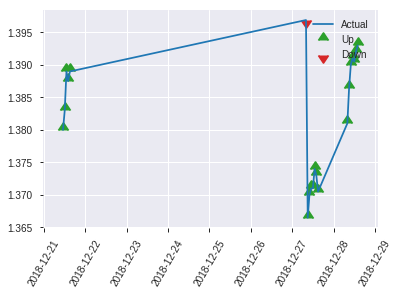


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20531762240963938
RMSE: 0.4531198764230492
LogLoss: 0.5964927256605164
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 265.27189969043866
Residual deviance: 230.24619210495933
AIC: 332.24619210495933
AUC: 0.7407447973713035
pr_auc: 0.6481964912849458
Gini: 0.481489594742607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3920139389522836: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   59   0.5364   (59.0/110.0)
1      10   73   0.1205   (10.0/83.0)
Total  61   132  0.3575   (69.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392014     0.67907   131
max f2                       0.248594     0.816733  169
max f0point5                 0.58286      0.687285  51
max accuracy                 0.58286      0.715026  51
max precision                0.866639     1         0
max recall                   0.219294     1         176
max specificity              0.866639     1         0
max absolute_mcc             0.58286      0.416048  51
max min_per_class_accuracy   0.473429     0.672727  91
max mean_per_class_accuracy  0.566284     0.689376  55

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 46.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.828921           2.3253    2.3253             1                0.854939  1                           0.854939            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.791335           1.16265   1.74398            0.5              0.814617  0.75                        0.834778            0.0120482       0.0361446                  16.2651   74.3976
    3        0.0310881                   0.769492           1.16265   1.5502             0.5              0.78239   0.666667                    0.817315            0.0120482       0.0481928                  16.2651   55.0201
    4        0.0414508                   0.764057           1.16265   1.45331            0.5              0.766651  0.625                       0.804649            0.0120482       0.060241                   16.2651   45.3313
    5        0.0518135                   0.757913           2.3253    1.62771            1                0.762024  0.7                         0.796124            0.0240964       0.0843373                  132.53    62.7711
    6        0.103627                    0.710569           1.86024   1.74398            0.8              0.730369  0.75                        0.763246            0.0963855       0.180723                   86.0241   74.3976
    7        0.150259                    0.637576           1.80857   1.76402            0.777778         0.67335   0.758621                    0.735348            0.0843373       0.26506                    80.8568   76.4022
    8        0.202073                    0.610517           1.62771   1.72907            0.7              0.624068  0.74359                     0.706814            0.0843373       0.349398                   62.7711   72.907
    9        0.300518                    0.561312           1.591     1.68384            0.684211         0.587084  0.724138                    0.667592            0.156627        0.506024                   59.0996   68.3839
    10       0.398964                    0.505618           0.85669   1.47974            0.368421         0.527861  0.636364                    0.633113            0.0843373       0.590361                   -14.331   47.9737
    11       0.502591                    0.467212           0.93012   1.36641            0.4              0.482696  0.587629                    0.602099            0.0963855       0.686747                   -6.98795  36.6414
    12       0.601036                    0.434108           1.10146   1.32302            0.473684         0.44891   0.568966                    0.577008            0.108434        0.795181                   10.1458   32.3016
    13       0.699482                    0.381321           0.85669   1.25739            0.368421         0.413233  0.540741                    0.553958            0.0843373       0.879518                   -14.331   25.7385
    14       0.797927                    0.327785           0.367153  1.14755            0.157895         0.353348  0.493506                    0.529208            0.0361446       0.915663                   -63.2847  14.7551
    15       0.896373                    0.224952           0.734306  1.10217            0.315789         0.282756  0.473988                    0.502141            0.0722892       0.987952                   -26.5694  10.2166
    16       1                           0.0404253          0.116265  1                  0.05             0.172283  0.430052                    0.467958           

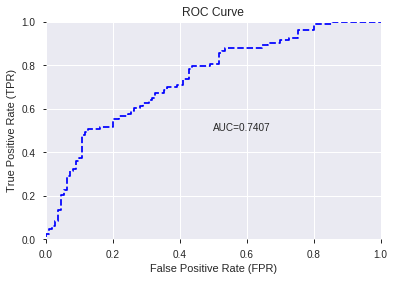

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


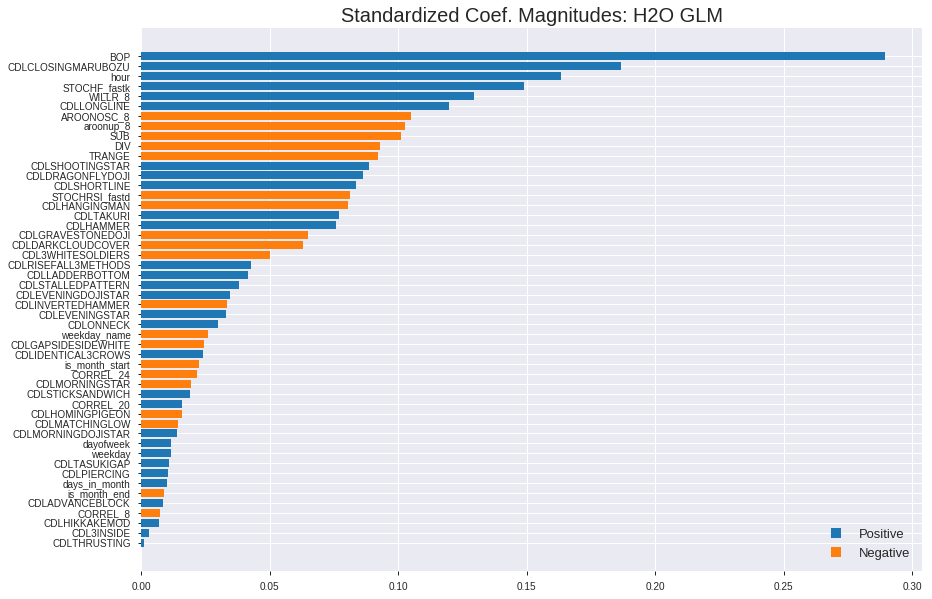

'log_likelihood'
--2019-09-06 02:01:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_020141_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_020141_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLLONGLINE',
 'AROONOSC_8',
 'aroonup_8',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLRISEFALL3METHODS',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'weekday_name',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'CDLMATCHINGLOW',
 'CDLMORNINGDOJISTAR',
 'dayofweek',
 'weekday',
 'CDLTASUKIGAP',
 'CDLPIERCING',
 'days_in_month',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CORREL_8',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLTHRUSTING']

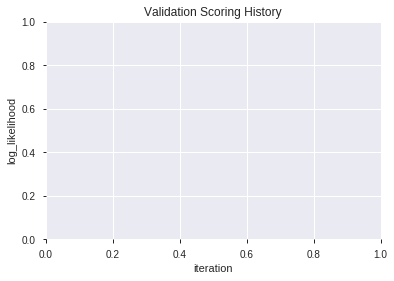

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_020200_model_3  0.760898  0.586116              0.316265  0.448188  0.200873
1  XGBoost_grid_1_AutoML_20190906_020200_model_4  0.758488  0.583577              0.276506  0.447403  0.200169
2               XGBoost_2_AutoML_20190906_020200  0.758379  0.586992              0.290252  0.449317  0.201885
3               XGBoost_1_AutoML_20190906_020200  0.751369  0.586591              0.305586  0.450090  0.202581
4  XGBoost_grid_1_AutoML_20190906_020200_model_1  0.749507  0.591201              0.332968  0.451331  0.203700
5               XGBoost_3_AutoML_20190906_020200  0.743593  0.596800              0.354326  0.454691  0.206744
6  XGBoost_grid_1_AutoML_20190906_020200_model_5  0.737240  0.606055              0.343866  0.458575  0.210291
7  XGBoost_grid_1_AutoML_20190906_020200_model_2  0.735159  0.602873              0.338883  0.457200  0.209032
8  XGBoost_grid_1_AutoML_20190906_020200_model_6  0.729792  0.602836              0.334228  0.458384  0.210116
9  XGBoost_grid_1_AutoML_20190906_020200_model_7  0.728368  0.603495              0.325356  0.457729  0.209516

variable  relative_importance  scaled_importance  percentage
0                  BOP          1106.007324           1.000000    0.201486
1         STOCHF_fastk           541.332092           0.489447    0.098617
2                 hour           437.369965           0.395449    0.079678
3               TRANGE           352.276886           0.318512    0.064176
4       STOCHRSI_fastd           333.789185           0.301797    0.060808
5                  SUB           316.672119           0.286320    0.057690
6            CORREL_20           311.394775           0.281549    0.056728
7              WILLR_8           277.247986           0.250675    0.050508
8             CORREL_8           260.183319           0.235246    0.047399
9                  DIV           240.620926           0.217558    0.043835
10           CORREL_24           215.849838           0.195161    0.039322
11           aroonup_8           211.891800           0.191583    0.038601
12          AROONOSC_8           206.540176           0.186744    0.037626
13  CDLCLOSINGMARUBOZU           180.931503           0.163590    0.032961
14           dayofweek            90.412552           0.081747    0.016471
15    CDLDRAGONFLYDOJI            76.824974           0.069462    0.013996
16         CDLLONGLINE            68.678833           0.062096    0.012512
17        CDLSHORTLINE            56.146732           0.050765    0.010229
18        weekday_name            50.464733           0.045628    0.009193
19             weekday            44.528084           0.040260    0.008112
20           CDLHAMMER            33.988869           0.030731    0.006192
21       days_in_month            28.721195           0.025968    0.005232
22       CDLHANGINGMAN            16.665668           0.015068    0.003036
23           CDLTAKURI            15.474340           0.013991    0.002819
24   CDLGRAVESTONEDOJI            15.229479           0.013770    0.002774

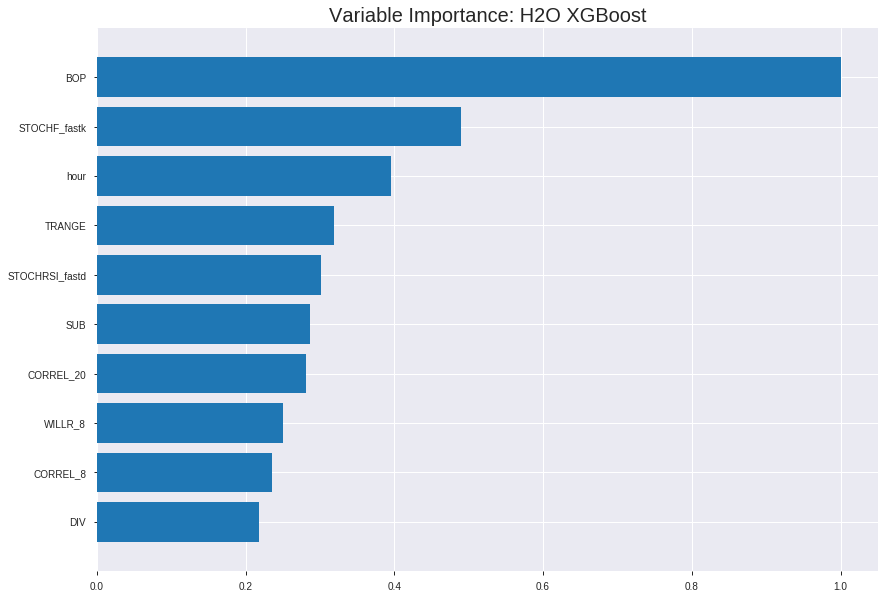

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_020200_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14434463253791083
RMSE: 0.37992714109143455
LogLoss: 0.45701434467679997
Mean Per-Class Error: 0.18509022887323945
AUC: 0.9011014524647888
pr_auc: 0.8905318476827371
Gini: 0.8022029049295776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4332337826490402: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      508  202  0.2845   (202.0/710.0)
1      62   578  0.0969   (62.0/640.0)
Total  570  780  0.1956   (264.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433234     0.814085  223
max f2                       0.341585     0.880747  264
max f0point5                 0.595752     0.830138  144
max accuracy                 0.54618      0.813333  170
max precision                0.927312     1         0
max recall                   0.182594     1         343
max specificity              0.927312     1         0
max absolute_mcc             0.492618     0.629222  197
max min_per_class_accuracy   0.51472      0.805634  186
max mean_per_class_accuracy  0.492618     0.81491   197

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.885482           2.10938   2.10938            1                0.899943  1                           0.899943            0.021875        0.021875                   110.938   110.938
    2        0.02                        0.865133           2.10938   2.10938            1                0.873114  1                           0.887025            0.0203125       0.0421875                  110.938   110.938
    3        0.0303704                   0.843094           2.10938   2.10938            1                0.851688  1                           0.874959            0.021875        0.0640625                  110.938   110.938
    4        0.04                        0.825153           2.10938   2.10938            1                0.83533   1                           0.865418            0.0203125       0.084375                   110.938   110.938
    5        0.0503704                   0.810796           2.10938   2.10938            1                0.818407  1                           0.85574             0.021875        0.10625                    110.938   110.938
    6        0.1                         0.774291           1.98344   2.04688            0.940299         0.790952  0.97037                     0.823586            0.0984375       0.204687                   98.3442   104.688
    7        0.15037                     0.734816           2.04733   2.04703            0.970588         0.754325  0.970443                    0.800385            0.103125        0.307812                   104.733   104.703
    8        0.2                         0.701724           1.85751   2                  0.880597         0.718577  0.948148                    0.780084            0.0921875       0.4                        85.7509   100
    9        0.3                         0.632434           1.75      1.91667            0.82963          0.66713   0.908642                    0.742433            0.175           0.575                      75        91.6667
    10       0.4                         0.568423           1.4375    1.79688            0.681481         0.602542  0.851852                    0.70746             0.14375         0.71875                    43.75     79.6875
    11       0.5                         0.502966           1.07812   1.65312            0.511111         0.534903  0.783704                    0.672949            0.107813        0.826562                   7.8125    65.3125
    12       0.6                         0.411492           0.890625  1.52604            0.422222         0.457328  0.723457                    0.637012            0.0890625       0.915625                   -10.9375  52.6042
    13       0.7                         0.324965           0.46875   1.375              0.222222         0.367451  0.651852                    0.598503            0.046875        0.9625                     -53.125   37.5
    14       0.8                         0.236451           0.25      1.23437            0.118519         0.279508  0.585185                    0.558629            0.025           0.9875                     -75       23.4375
    15       0.9                         0.153426           0.125     1.11111            0.0592593        0.195048  0.526749                    0.518231            0.0125          1                          -87.5     11.1111
    16       1                           0.0583949          0         1                  0                0.109155  0.474074                    0.477323            0   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20387696754702508
RMSE: 0.45152737186910946
LogLoss: 0.5903313349489354
Mean Per-Class Error: 0.3143567701997675
AUC: 0.7453572297461681
pr_auc: 0.7133932000193751
Gini: 0.4907144594923363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2413257360458374: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      72   137  0.6555   (137.0/209.0)
1      12   165  0.0678   (12.0/177.0)
Total  84   302  0.386    (149.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.241326     0.688935  301
max f2                       0.140024     0.833333  353
max f0point5                 0.589694     0.664697  124
max accuracy                 0.518465     0.689119  162
max precision                0.877842     1         0
max recall                   0.140024     1         353
max specificity              0.877842     1         0
max absolute_mcc             0.518465     0.371125  162
max min_per_class_accuracy   0.47699      0.683616  186
max mean_per_class_accuracy  0.466312     0.685643  194

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 44.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.831387           2.18079   2.18079            1                0.868879  1                           0.868879            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.818226           2.18079   2.18079            1                0.823732  1                           0.846305            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.808821           1.63559   1.99906            0.75             0.815087  0.916667                    0.835899            0.0169492       0.0621469                  63.5593   99.9058
    4        0.0414508                   0.783902           2.18079   2.04449            1                0.793282  0.9375                      0.825245            0.0225989       0.0847458                  118.079   104.449
    5        0.0518135                   0.767206           2.18079   2.07175            1                0.775477  0.95                        0.815291            0.0225989       0.107345                   118.079   107.175
    6        0.101036                    0.730833           1.95123   2.01304            0.894737         0.750321  0.923077                    0.783639            0.0960452       0.20339                    95.1234   101.304
    7        0.150259                    0.683669           1.03301   1.69199            0.473684         0.709784  0.775862                    0.759445            0.0508475       0.254237                   3.30062   69.1993
    8        0.202073                    0.651843           1.63559   1.67753            0.75             0.670682  0.769231                    0.736685            0.0847458       0.338983                   63.5593   67.7532
    9        0.300518                    0.601899           1.31995   1.56039            0.605263         0.625694  0.715517                    0.700326            0.129944        0.468927                   31.9952   56.0394
    10       0.401554                    0.534823           1.17427   1.46324            0.538462         0.564649  0.670968                    0.666188            0.118644        0.587571                   17.4272   46.324
    11       0.5                         0.467339           1.0904    1.38983            0.5              0.498519  0.637306                    0.633175            0.107345        0.694915                   9.03955   38.9831
    12       0.601036                    0.403654           0.838766  1.29719            0.384615         0.436096  0.594828                    0.600046            0.0847458       0.779661                   -16.1234  29.7195
    13       0.699482                    0.286084           0.74606   1.21963            0.342105         0.3398    0.559259                    0.563418            0.0734463       0.853107                   -25.394   21.9628
    14       0.800518                    0.230339           0.838766  1.17156            0.384615         0.257818  0.537217                    0.524847            0.0847458       0.937853                   -16.1234  17.1558
    15       0.898964                    0.150913           0.459114  1.09354            0.210526         0.18996   0.501441                    0.488174            0.0451977       0.983051                   -54.0886  9.35378
    16       1                           0.0632865          0.167753  1                  0.0769231        0.10888   0.458549                    0.449851          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:02:13  1.684 sec   0                  0.5              0.693147            0.5             0                  1                0.525926                         0.5                0.693147              0.5               0                    1                  0.541451
    2019-09-06 02:02:13  1.746 sec   5                  0.473923         0.641987            0.827602        0.797296           2.10938          0.265926                         0.48084            0.65526               0.742546          0.713495             2.18079            0.34715
    2019-09-06 02:02:13  1.796 sec   10                 0.453909         0.603475            0.849309        0.826231           2.10938          0.235556                         0.47               0.633694              0.745587          0.71274              2.18079            0.339378
    2019-09-06 02:02:13  1.841 sec   15                 0.438937         0.574424            0.857191        0.835238           2.10938          0.223704                         0.461592           0.616324              0.745046          0.706455             2.18079            0.352332
    2019-09-06 02:02:13  1.887 sec   20                 0.427935         0.552697            0.861098        0.84103            2.10938          0.217037                         0.456604           0.605536              0.750412          0.712039             2.18079            0.323834
    2019-09-06 02:02:13  1.939 sec   25                 0.418117         0.533442            0.869023        0.85174            2.10938          0.203704                         0.454001           0.599361              0.749709          0.709136             2.18079            0.34456
    2019-09-06 02:02:13  1.989 sec   30                 0.41065          0.518072            0.873401        0.857147           2.10938          0.211111                         0.451935           0.594296              0.749791          0.706963             2.18079            0.341969
    2019-09-06 02:02:13  2.045 sec   35                 0.40502          0.506716            0.877322        0.861006           2.10938          0.2                              0.45101            0.59188               0.751034          0.714522             2.18079            0.352332
    2019-09-06 02:02:13  2.099 sec   40                 0.397871         0.492598            0.885453        0.871314           2.10938          0.196296                         0.451452           0.591876              0.746574          0.703499             2.18079            0.352332
    2019-09-06 02:02:13  2.164 sec   45                 0.392294         0.481481            0.889708        0.875903           2.10938          0.199259                         0.451112           0.59019               0.747006          0.714436             2.18079            0.380829
    2019-09-06 02:02:13  2.217 sec   50                 0.387481         0.472081            0.894236        0.88046            2.10938          0.191111                         0.450708           0.589054              0.746763          0.714078             2.18079            0.38601
    2019-09-06 02:02:13  2.273 sec   55                 0.383975         0.464857            0.897109        0.885709           2.10938          0.187407                         0.450803           0.589326              0.746276          0.71

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                1106.00732421875       1.0                   0.20148629833511517
STOCHF_fastk       541.3320922851562      0.48944711344252334   0.09861688711834123
hour               437.3699645996094      0.39544942878977246   0.07967764158558698
TRANGE             352.2768859863281      0.31851225418888235   0.06417585507089119
STOCHRSI_fastd     333.7891845703125      0.30179654081955654   0.060807867860074936
---                ---                    ---                   ---
CDLHAMMER          33.988868713378906     0.030731142524203094  0.006191904150810529
days_in_month      28.721195220947266     0.025968358971976108  0.005232268523100943
CDLHANGINGMAN      16.665668487548828     0.01506831656772341   0.0030360593273722775
CDLTAKURI          15.474340438842773     0.013991173566389696  0.0028190297712559717
CDLGRAVESTONEDOJI  15.22947883605957      0.013769781178273129  0.0027744222384947933


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.6857142857142857)

('auc', 0.7608981380065718)

('logloss', 0.5861158430019953)

('mean_per_class_error', 0.292880613362541)

('rmse', 0.44818845954209324)

('mse', 0.20087289526671454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


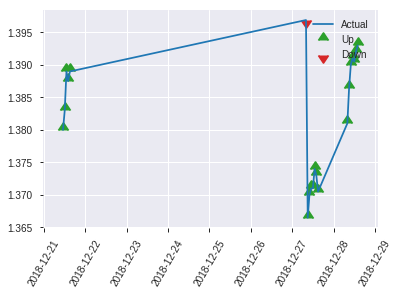


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20087289526671454
RMSE: 0.44818845954209324
LogLoss: 0.5861158430019953
Mean Per-Class Error: 0.292880613362541
AUC: 0.7608981380065718
pr_auc: 0.6610025311379442
Gini: 0.5217962760131436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39585718512535095: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   55   0.5      (55.0/110.0)
1      11   72   0.1325   (11.0/83.0)
Total  66   127  0.342    (66.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395857     0.685714  126
max f2                       0.207964     0.828343  168
max f0point5                 0.590208     0.676056  67
max accuracy                 0.590208     0.715026  67
max precision                0.798268     0.818182  10
max recall                   0.207964     1         168
max specificity              0.928858     0.990909  0
max absolute_mcc             0.572403     0.416296  79
max min_per_class_accuracy   0.538525     0.686747  90
max mean_per_class_accuracy  0.572403     0.707119  79

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.879853           1.16265   1.16265            0.5              0.91069   0.5                         0.91069             0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.862648           1.16265   1.16265            0.5              0.874739  0.5                         0.892715            0.0120482       0.0240964                  16.2651   16.2651
    3        0.0310881                   0.844509           2.3253    1.5502             1                0.855413  0.666667                    0.880281            0.0240964       0.0481928                  132.53    55.0201
    4        0.0414508                   0.814883           2.3253    1.74398            1                0.834326  0.75                        0.868792            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.800749           2.3253    1.86024            1                0.807111  0.8                         0.856456            0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.73522            1.39518   1.62771            0.6              0.772138  0.7                         0.814297            0.0722892       0.168675                   39.5181   62.7711
    7        0.150259                    0.703031           1.80857   1.68384            0.777778         0.723046  0.724138                    0.785978            0.0843373       0.253012                   80.8568   68.3839
    8        0.202073                    0.669618           2.3253    1.84832            1                0.687781  0.794872                    0.760799            0.120482        0.373494                   132.53    84.8316
    9        0.300518                    0.617508           1.22384   1.64375            0.526316         0.649906  0.706897                    0.724472            0.120482        0.493976                   22.3843   64.3747
    10       0.398964                    0.573816           1.34623   1.57033            0.578947         0.594551  0.675325                    0.692413            0.13253         0.626506                   34.6227   57.0333
    11       0.502591                    0.515643           0.93012   1.43833            0.4              0.544363  0.618557                    0.661888            0.0963855       0.722892                   -6.98795  43.8331
    12       0.601036                    0.439252           0.85669   1.34306            0.368421         0.475062  0.577586                    0.631287            0.0843373       0.807229                   -14.331   34.3062
    13       0.699482                    0.374748           0.734306  1.25739            0.315789         0.40629   0.540741                    0.599621            0.0722892       0.879518                   -26.5694  25.7385
    14       0.797927                    0.272838           0.489537  1.16265            0.210526         0.320808  0.5                         0.565222            0.0481928       0.927711                   -51.0463  16.2651
    15       0.896373                    0.18293            0.734306  1.11561            0.315789         0.241007  0.479769                    0.529614            0.0722892       1                          -26.5694  11.5607
    16       1                           0.077476           0         1                  0                0.115414  0.430052                    0.486692         

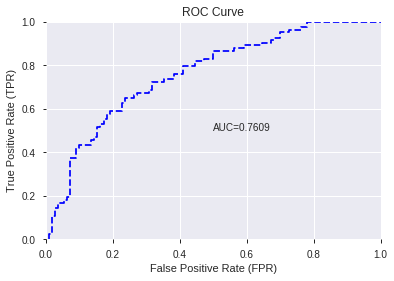

This function is available for GLM models only


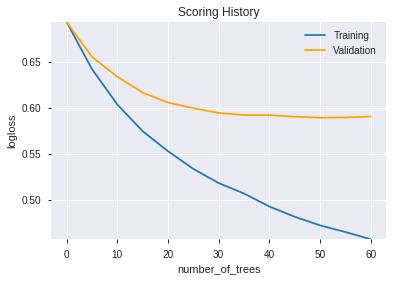

--2019-09-06 02:02:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_020200_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_020200_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'hour',
 'TRANGE',
 'STOCHRSI_fastd',
 'SUB',
 'CORREL_20',
 'WILLR_8',
 'CORREL_8',
 'DIV',
 'CORREL_24',
 'aroonup_8',
 'AROONOSC_8',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'weekday_name',
 'weekday',
 'CDLHAMMER',
 'days_in_month',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_020244_model_1  0.759912  0.608709              0.323987  0.459265  0.210924

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.203788           1.000000  2.867138e-02
1           CDLCLOSINGMARUBOZU             0.154117           0.756261  2.168304e-02
2                         hour             0.136399           0.669320  1.919032e-02
3                  CDLLONGLINE             0.100046           0.490931  1.407566e-02
4                 STOCHF_fastk             0.097618           0.479019  1.373413e-02
...                        ...                  ...                ...           ...
1031    BBANDS_lowerband_8_3_3             0.000017           0.000083  2.379428e-06
1032                    MA_8_0             0.000014           0.000068  1.947660e-06
1033                     SMA_8             0.000014           0.000067  1.919136e-06
1034  BBANDS_middleband_12_1_5             0.000012           0.000059  1.687703e-06
1035    BBANDS_lowerband_8_7_2             0.000004           0.000022  6.281632e-07

[1036 rows x 4 columns]

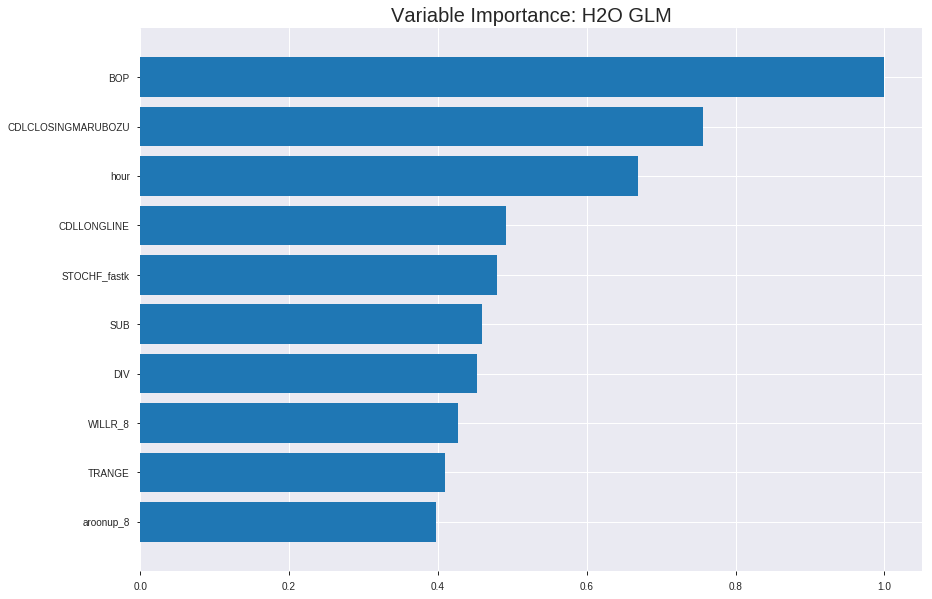

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_020244_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1884477129251322
RMSE: 0.4341056471933211
LogLoss: 0.5599810215359164
Null degrees of freedom: 1349
Residual degrees of freedom: 313
Null deviance: 1867.8661296847088
Residual deviance: 1511.9487581469743
AIC: 3585.9487581469743
AUC: 0.8010244278169014
pr_auc: 0.7518822010259356
Gini: 0.6020488556338028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371452349105276: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      362  348  0.4901   (348.0/710.0)
1      57   583  0.0891   (57.0/640.0)
Total  419  931  0.3      (405.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371452     0.742202  261
max f2                       0.271913     0.840313  317
max f0point5                 0.533427     0.719914  168
max accuracy                 0.451679     0.731852  217
max precision                0.925681     1         0
max recall                   0.171799     1         364
max specificity              0.925681     1         0
max absolute_mcc             0.43671      0.471471  225
max min_per_class_accuracy   0.4837       0.723944  198
max mean_per_class_accuracy  0.451679     0.734749  217

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.839202           1.65737   1.65737            0.785714         0.876196  0.785714                    0.876196            0.0171875       0.0171875                  65.7366   65.7366
    2        0.02                        0.821261           1.6226    1.64062            0.769231         0.830995  0.777778                    0.854432            0.015625        0.0328125                  62.2596   64.0625
    3        0.0303704                   0.805491           1.95871   1.74924            0.928571         0.813972  0.829268                    0.840617            0.0203125       0.053125                   95.8705   74.9238
    4        0.04                        0.786138           1.6226    1.71875            0.769231         0.795788  0.814815                    0.829825            0.015625        0.06875                    62.2596   71.875
    5        0.0503704                   0.770198           2.10938   1.79917            1                0.7787    0.852941                    0.819299            0.021875        0.090625                   110.938   79.9173
    6        0.1                         0.71827            1.73158   1.76562            0.820896         0.744467  0.837037                    0.78216             0.0859375       0.176563                   73.1576   76.5625
    7        0.15037                     0.677187           1.83019   1.78725            0.867647         0.696088  0.847291                    0.753328            0.0921875       0.26875                    83.0193   78.7254
    8        0.2                         0.646259           1.54268   1.72656            0.731343         0.662468  0.818519                    0.730781            0.0765625       0.345313                   54.2677   72.6562
    9        0.3                         0.585519           1.45312   1.63542            0.688889         0.614504  0.775309                    0.692022            0.145313        0.490625                   45.3125   63.5417
    10       0.4                         0.531951           1.40625   1.57812            0.666667         0.558751  0.748148                    0.658704            0.140625        0.63125                    40.625    57.8125
    11       0.5                         0.477087           1.09375   1.48125            0.518519         0.503012  0.702222                    0.627566            0.109375        0.740625                   9.375     48.125
    12       0.6                         0.422118           0.9375    1.39062            0.444444         0.448212  0.659259                    0.597674            0.09375         0.834375                   -6.25     39.0625
    13       0.7                         0.363144           0.796875  1.3058             0.377778         0.394345  0.619048                    0.568627            0.0796875       0.914062                   -20.3125  30.5804
    14       0.8                         0.302158           0.40625   1.19336            0.192593         0.332405  0.565741                    0.539099            0.040625        0.954688                   -59.375   19.3359
    15       0.9                         0.221825           0.328125  1.09722            0.155556         0.26595   0.520165                    0.508749            0.0328125       0.9875                     -67.1875  9.72222
    16       1                           0.0151524          0.125     1                  0.0592593        0.162     0.474074                    0.474074           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20808170851748803
RMSE: 0.45615974013221294
LogLoss: 0.601760675261204
Null degrees of freedom: 385
Residual degrees of freedom: -651
Null deviance: 532.8273288418734
Residual deviance: 464.55924130164954
AIC: 2538.5592413016493
AUC: 0.7360311410266808
pr_auc: 0.682066416848853
Gini: 0.47206228205336154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4727570289898856: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  68   0.3254   (68.0/209.0)
1      46   131  0.2599   (46.0/177.0)
Total  187  199  0.2953   (114.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472757     0.696809  198
max f2                       0.201348     0.827068  355
max f0point5                 0.521281     0.674556  166
max accuracy                 0.478578     0.704663  196
max precision                0.906458     1         0
max recall                   0.158565     1         370
max specificity              0.906458     1         0
max absolute_mcc             0.472757     0.413526  198
max min_per_class_accuracy   0.485568     0.694915  185
max mean_per_class_accuracy  0.472757     0.707377  198

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 48.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.891848           2.18079   2.18079            1                0.898607  1                           0.898607            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.832891           1.63559   1.90819            0.75             0.863015  0.875                       0.880811            0.0169492       0.039548                   63.5593   90.8192
    3        0.0310881                   0.806947           1.63559   1.81733            0.75             0.818878  0.833333                    0.860167            0.0169492       0.0564972                  63.5593   81.7326
    4        0.0414508                   0.79125            2.18079   1.90819            1                0.799818  0.875                       0.845079            0.0225989       0.079096                   118.079   90.8192
    5        0.0518135                   0.783304           2.18079   1.96271            1                0.787523  0.9                         0.833568            0.0225989       0.101695                   118.079   96.2712
    6        0.101036                    0.738369           1.37734   1.67753            0.631579         0.761081  0.769231                    0.798254            0.0677966       0.169492                   37.7342   67.7532
    7        0.150259                    0.697159           1.72168   1.69199            0.789474         0.716152  0.775862                    0.771358            0.0847458       0.254237                   72.1677   69.1993
    8        0.202073                    0.668631           1.52655   1.64957            0.7              0.681926  0.75641                     0.748427            0.079096        0.333333                   52.6554   64.9573
    9        0.300518                    0.591391           0.918228  1.40999            0.421053         0.624307  0.646552                    0.707767            0.0903955       0.423729                   -8.17722  40.9994
    10       0.401554                    0.533114           1.62161   1.46324            0.74359          0.558403  0.670968                    0.670185            0.163842        0.587571                   62.1614   46.324
    11       0.5                         0.480128           1.31995   1.43503            0.605263         0.506554  0.658031                    0.637968            0.129944        0.717514                   31.9952   43.5028
    12       0.601036                    0.429544           0.782848  1.32539            0.358974         0.455913  0.607759                    0.607364            0.079096        0.79661                    -21.7152  32.5395
    13       0.699482                    0.383748           0.573892  1.21963            0.263158         0.406223  0.559259                    0.579055            0.0564972       0.853107                   -42.6108  21.9628
    14       0.800518                    0.311926           0.671013  1.15038            0.307692         0.343277  0.527508                    0.549297            0.0677966       0.920904                   -32.8987  15.0385
    15       0.898964                    0.225188           0.516503  1.08097            0.236842         0.274057  0.495677                    0.519155            0.0508475       0.971751                   -48.3497  8.09684
    16       1                           0.0116057          0.279589  1                  0.128205         0.157919  0.458549                    0.482657          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:02:46  0.000 sec   2            17        1015          1.35808           1.36126
    2019-09-06 02:02:48  1.539 sec   4            13        1032          1.3506            1.35476
    2019-09-06 02:02:50  3.040 sec   6            9.3       1032          1.34121           1.34645
    2019-09-06 02:02:51  4.714 sec   8            6.7       1032          1.32972           1.33615
    2019-09-06 02:02:53  6.385 sec   10           4.9       1037          1.31593           1.32382
    2019-09-06 02:02:54  7.966 sec   12           3.6       1037          1.29984           1.30958
    2019-09-06 02:02:56  9.539 sec   14           2.6       1037          1.28164           1.29378
    2019-09-06 02:02:58  11.064 sec  16           1.9       1037          1.26171           1.2771
    2019-09-06 02:02:59  12.612 sec  18           1.4       1037          1.24058           1.26032
    2019-09-06 02:03:01  14.263 sec  20           1         1037          1.21887           1.24441
    2019-09-06 02:03:02  15.786 sec  22           0.73      1037          1.19723           1.23035
    2019-09-06 02:03:04  17.412 sec  24           0.53      1037          1.17616           1.2188
    2019-09-06 02:03:05  18.946 sec  26           0.39      1037          1.15607           1.2104
    2019-09-06 02:03:07  20.589 sec  28           0.28      1037          1.1373            1.20534
    2019-09-06 02:03:09  22.082 sec  30           0.2       1037          1.11996           1.20352
    2019-09-06 02:03:10  23.573 sec  32           0.15      1037          1.10416           1.20471
    2019-09-06 02:03:12  25.074 sec  34           0.11      1037          1.08982           1.20837
    2019-09-06 02:03:13  26.556 sec  36           0.079     1037          1.07693           1.21376
    2019-09-06 02:03:15  28.069 sec  38           0.057     1037          1.06529           1.2203
    2019-09-06 02:03:16  29.641 sec  40           0.042     1037          1.05473           1.22727

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7305699481865285)

('F1', 0.6877828054298641)

('auc', 0.7599123767798467)

('logloss', 0.6087088908310944)

('mean_per_class_error', 0.29266155531215776)

('rmse', 0.45926459371079953)

('mse', 0.21092396703634578)

glm prediction progress: |████████████████████████████████████████████████| 100%


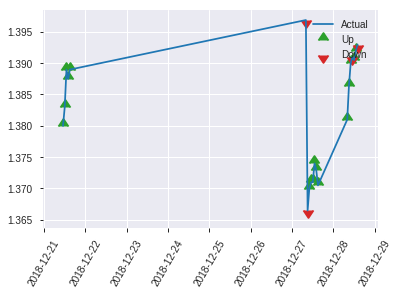


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21092396703634578
RMSE: 0.45926459371079953
LogLoss: 0.6087088908310944
Null degrees of freedom: 192
Residual degrees of freedom: -844
Null deviance: 265.27189969043866
Residual deviance: 234.9616318608025
AIC: 2308.9616318608023
AUC: 0.7599123767798467
pr_auc: 0.6689728421010321
Gini: 0.5198247535596934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4537371269716028: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   62   0.5636   (62.0/110.0)
1      7    76   0.0843   (7.0/83.0)
Total  55   138  0.3575   (69.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453737     0.687783  137
max f2                       0.407826     0.812757  153
max f0point5                 0.638016     0.707395  56
max accuracy                 0.638016     0.73057   56
max precision                0.905669     1         0
max recall                   0.215066     1         183
max specificity              0.905669     1         0
max absolute_mcc             0.638016     0.447055  56
max min_per_class_accuracy   0.547856     0.690909  91
max mean_per_class_accuracy  0.619349     0.707338  65

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 54.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.840765           2.3253    2.3253             1                0.895602  1                           0.895602            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.830133           0         1.16265            0                0.835944  0.5                         0.865773            0               0.0240964                  -100      16.2651
    3        0.0310881                   0.821518           2.3253    1.5502             1                0.827558  0.666667                    0.853034            0.0240964       0.0481928                  132.53    55.0201
    4        0.0414508                   0.805807           2.3253    1.74398            1                0.814774  0.75                        0.843469            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.8013             1.16265   1.62771            0.5              0.804071  0.7                         0.83559             0.0120482       0.0843373                  16.2651   62.7711
    6        0.103627                    0.759947           2.09277   1.86024            0.9              0.777163  0.8                         0.806376            0.108434        0.192771                   109.277   86.0241
    7        0.150259                    0.73475            1.29183   1.68384            0.555556         0.744102  0.724138                    0.78705             0.060241        0.253012                   29.1834   68.3839
    8        0.202073                    0.709534           1.86024   1.72907            0.8              0.723278  0.74359                     0.770698            0.0963855       0.349398                   86.0241   72.907
    9        0.300518                    0.637203           1.83576   1.76402            0.789474         0.677544  0.758621                    0.740182            0.180723        0.53012                    83.5764   76.4022
    10       0.398964                    0.593039           0.734306  1.50994            0.315789         0.613977  0.649351                    0.709041            0.0722892       0.60241                    -26.5694  50.9936
    11       0.502591                    0.540017           1.04639   1.41436            0.45             0.565217  0.608247                    0.679386            0.108434        0.710843                   4.63855   41.4358
    12       0.601036                    0.508001           0.734306  1.30297            0.315789         0.522539  0.560345                    0.653696            0.0722892       0.783133                   -26.5694  30.2971
    13       0.699482                    0.465644           0.979074  1.25739            0.421053         0.488076  0.540741                    0.630386            0.0963855       0.879518                   -2.09258  25.7385
    14       0.797927                    0.405909           0.734306  1.19285            0.315789         0.434344  0.512987                    0.606199            0.0722892       0.951807                   -26.5694  19.2849
    15       0.896373                    0.298306           0.244769  1.08872            0.105263         0.353644  0.468208                    0.578462            0.0240964       0.975904                   -75.5231  8.87248
    16       1                           0.0569723          0.23253   1                  0.1              0.211311  0.430052                    0.540415           

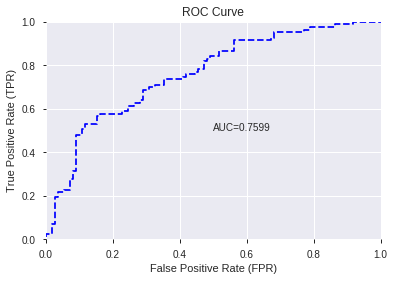

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


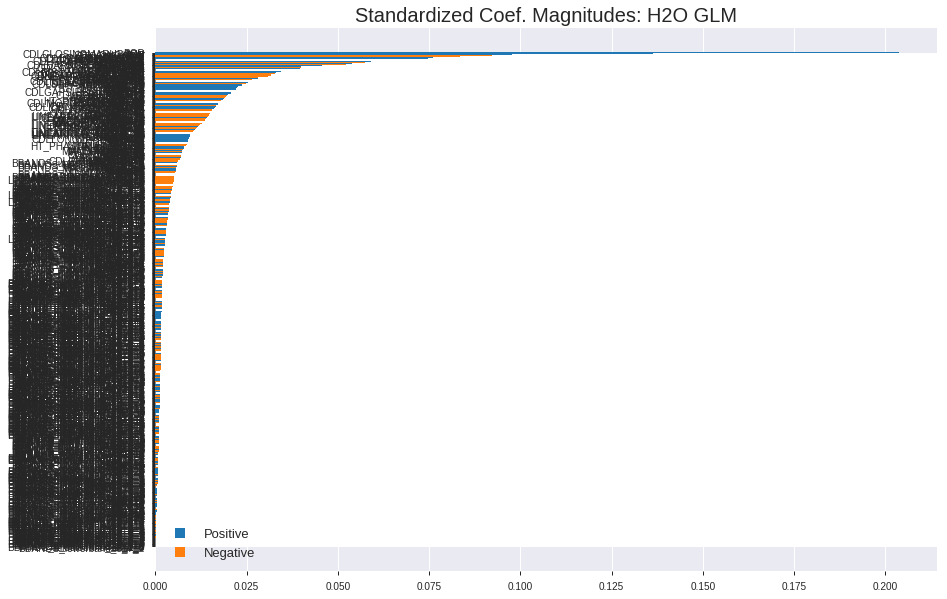

'log_likelihood'
--2019-09-06 02:03:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_020244_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_020244_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

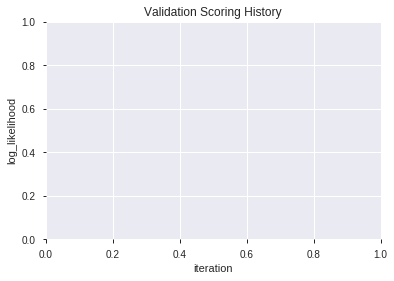

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190906_020352  0.778313  0.584195              0.308762  0.447118  0.199914
1  XGBoost_grid_1_AutoML_20190906_020352_model_7  0.764184  0.604801              0.299343  0.458508  0.210229
2  XGBoost_grid_1_AutoML_20190906_020352_model_1  0.759255  0.611302              0.297974  0.460687  0.212232
3  XGBoost_grid_1_AutoML_20190906_020352_model_4  0.758927  0.585668              0.287185  0.448225  0.200905
4               XGBoost_1_AutoML_20190906_020352  0.755203  0.608425              0.300931  0.459840  0.211453
5  XGBoost_grid_1_AutoML_20190906_020352_model_2  0.752136  0.609011              0.345126  0.459421  0.211067
6               XGBoost_3_AutoML_20190906_020352  0.751150  0.619652              0.345235  0.465067  0.216287
7  XGBoost_grid_1_AutoML_20190906_020352_model_6  0.741183  0.614163              0.304107  0.461947  0.213395
8  XGBoost_grid_1_AutoML_20190906_020352_model_3  0.734392  0.634809              0.352848  0.472648  0.223396
9  XGBoost_grid_1_AutoML_20190906_020352_model_5  0.711501  0.655384              0.355805  0.481494  0.231836

variable  relative_importance  scaled_importance  percentage
0                        BOP           911.380005           1.000000    0.148092
1                     TRANGE           308.542633           0.338544    0.050136
2               STOCHF_fastk           271.897827           0.298336    0.044181
3                       hour           252.343155           0.276880    0.041004
4                        DIV           166.390121           0.182569    0.027037
..                       ...                  ...                ...         ...
266                   MFI_20             1.449396           0.001590    0.000236
267   BBANDS_lowerband_8_4_5             1.343081           0.001474    0.000218
268  BBANDS_upperband_24_0_4             1.040783           0.001142    0.000169
269              AROONOSC_12             0.799496           0.000877    0.000130
270                dayofyear             0.232441           0.000255    0.000038

[271 rows x 4 columns]

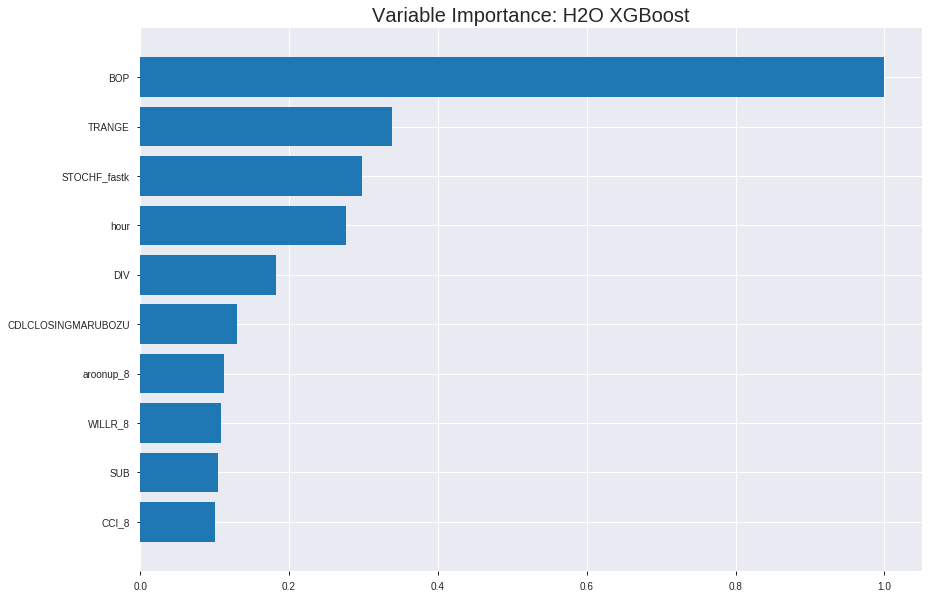

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190906_020352


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1375979510602176
RMSE: 0.3709419780238112
LogLoss: 0.44564116817106997
Mean Per-Class Error: 0.15011003521126765
AUC: 0.9261971830985916
pr_auc: 0.9166483019408999
Gini: 0.8523943661971831
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4950651079416275: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      603  107  0.1507   (107.0/710.0)
1      96   544  0.15     (96.0/640.0)
Total  699  651  0.1504   (203.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495065     0.842758  194
max f2                       0.375204     0.887332  259
max f0point5                 0.574584     0.878529  152
max accuracy                 0.528439     0.85037   179
max precision                0.902699     1         0
max recall                   0.177352     1         352
max specificity              0.902699     1         0
max absolute_mcc             0.570381     0.702603  154
max min_per_class_accuracy   0.495065     0.849296  194
max mean_per_class_accuracy  0.507902     0.84989   189

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.46 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103704                   0.859531           1.95871  1.95871            0.928571         0.877116  0.928571                    0.877116            0.0203125       0.0203125                  95.8705  95.8705
    2        0.02                        0.835915           2.10938  2.03125            1                0.845001  0.962963                    0.861653            0.0203125       0.040625                   110.938  103.125
    3        0.0303704                   0.822737           2.10938  2.05793            1                0.829512  0.97561                     0.850678            0.021875        0.0625                     110.938  105.793
    4        0.04                        0.813071           2.10938  2.07031            1                0.817968  0.981481                    0.842804            0.0203125       0.0828125                  110.938  107.031
    5        0.0503704                   0.803396           2.10938  2.07835            1                0.808265  0.985294                    0.835693            0.021875        0.104688                   110.938  107.835
    6        0.1                         0.759776           2.04641  2.0625             0.970149         0.781735  0.977778                    0.808914            0.101562        0.20625                    104.641  106.25
    7        0.15037                     0.721831           2.04733  2.05742            0.970588         0.741751  0.975369                    0.786416            0.103125        0.309375                   104.733  105.742
    8        0.2                         0.690844           2.01493  2.04688            0.955224         0.708184  0.97037                     0.767003            0.1             0.409375                   101.493  104.688
    9        0.3                         0.626948           1.89062  1.99479            0.896296         0.661167  0.945679                    0.731724            0.189062        0.598437                   89.0625  99.4792
    10       0.4                         0.559929           1.64062  1.90625            0.777778         0.592839  0.903704                    0.697003            0.164062        0.7625                     64.0625  90.625
    11       0.5                         0.4772             1        1.725              0.474074         0.521686  0.817778                    0.661939            0.1             0.8625                     0        72.5
    12       0.6                         0.405553           0.625    1.54167            0.296296         0.438744  0.730864                    0.62474             0.0625          0.925                      -37.5    54.1667
    13       0.7                         0.339392           0.40625  1.37946            0.192593         0.370556  0.653968                    0.588428            0.040625        0.965625                   -59.375  37.9464
    14       0.8                         0.248764           0.28125  1.24219            0.133333         0.292429  0.588889                    0.551428            0.028125        0.99375                    -71.875  24.2188
    15       0.9                         0.167771           0.0625   1.11111            0.0296296        0.208069  0.526749                    0.513277            0.00625         1                          -93.75   11.1111
    16       1                           0.0632666          0        1                  0                0.126387  0.474074                    0.474588            0               1                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20490058845154369
RMSE: 0.45265946190435885
LogLoss: 0.5940044807270759
Mean Per-Class Error: 0.30959911334576806
AUC: 0.742302597788771
pr_auc: 0.6644323195637579
Gini: 0.4846051955775419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3837684690952301: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  101  0.4833   (101.0/209.0)
1      27   150  0.1525   (27.0/177.0)
Total  135  251  0.3316   (128.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383768     0.700935  250
max f2                       0.203182     0.84453   333
max f0point5                 0.448393     0.650718  216
max accuracy                 0.448393     0.683938  216
max precision                0.875959     1         0
max recall                   0.172417     1         355
max specificity              0.875959     1         0
max absolute_mcc             0.404633     0.387929  236
max min_per_class_accuracy   0.517697     0.672316  186
max mean_per_class_accuracy  0.448393     0.690401  216

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 47.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.808994           1.0904     1.0904             0.5              0.841901  0.5                         0.841901            0.0112994       0.0112994                  9.03955   9.03955
    2        0.0207254                   0.793031           1.0904     1.0904             0.5              0.801568  0.5                         0.821734            0.0112994       0.0225989                  9.03955   9.03955
    3        0.0310881                   0.778519           2.18079    1.45386            1                0.787606  0.666667                    0.810358            0.0225989       0.0451977                  118.079   45.3861
    4        0.0414508                   0.769413           2.18079    1.63559            1                0.772048  0.75                        0.800781            0.0225989       0.0677966                  118.079   63.5593
    5        0.0518135                   0.760329           2.18079    1.74463            1                0.764596  0.8                         0.793544            0.0225989       0.0903955                  118.079   74.4633
    6        0.101036                    0.719188           1.72168    1.73345            0.789474         0.740546  0.794872                    0.767724            0.0847458       0.175141                   72.1677   73.3449
    7        0.150259                    0.682287           1.37734    1.61679            0.631579         0.705734  0.741379                    0.747417            0.0677966       0.242938                   37.7342   61.6793
    8        0.202073                    0.665702           1.85367    1.67753            0.85             0.674535  0.769231                    0.728729            0.0960452       0.338983                   85.3672   67.7532
    9        0.300518                    0.608696           1.0904     1.48519            0.5              0.637279  0.681034                    0.698771            0.107345        0.446328                   9.03955   48.5194
    10       0.401554                    0.554853           1.23019    1.42103            0.564103         0.582515  0.651613                    0.66952             0.124294        0.570621                   23.019    42.1032
    11       0.5                         0.505681           1.20517    1.37853            0.552632         0.531816  0.632124                    0.642407            0.118644        0.689266                   20.5174   37.8531
    12       0.601036                    0.414497           1.06244    1.32539            0.487179         0.457104  0.607759                    0.611257            0.107345        0.79661                    6.24366   32.5395
    13       0.699482                    0.338693           0.631282   1.2277             0.289474         0.380183  0.562963                    0.578735            0.0621469       0.858757                   -36.8718  22.7705
    14       0.800518                    0.255264           0.782848   1.17156            0.358974         0.299364  0.537217                    0.543475            0.079096        0.937853                   -21.7152  17.1558
    15       0.898964                    0.183758           0.573892   1.10611            0.263158         0.215198  0.507205                    0.507525            0.0564972       0.99435                    -42.6108  10.6107
    16       1                           0.076284           0.0559177  1                  0.025641         0.14724   0.458549                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:03:56  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.525926                         0.5                0.693147              0.5               0                    1                  0.541451
    2019-09-06 02:03:56  0.612 sec   5                  0.476284         0.646572            0.825976        0.797758           1.65737          0.264444                         0.482739           0.659007              0.735869          0.67655              2.18079            0.316062
    2019-09-06 02:03:57  0.971 sec   10                 0.45796          0.611311            0.851773        0.827808           1.80804          0.23037                          0.473059           0.639874              0.73841           0.663951             2.18079            0.318653
    2019-09-06 02:03:57  1.344 sec   15                 0.442809         0.582156            0.860941        0.842725           1.95871          0.214815                         0.466893           0.627251              0.733936          0.658201             2.18079            0.321244
    2019-09-06 02:03:58  1.732 sec   20                 0.430457         0.558453            0.872217        0.854527           1.80804          0.2                              0.461347           0.615769              0.740965          0.674655             2.18079            0.305699
    2019-09-06 02:03:58  2.092 sec   25                 0.419494         0.537167            0.88011         0.865213           1.95871          0.191852                         0.456643           0.605462              0.745141          0.67503              1.0904             0.313472
    2019-09-06 02:03:58  2.448 sec   30                 0.410574         0.520011            0.887829        0.872439           1.95871          0.184444                         0.455716           0.602926              0.743708          0.672734             1.0904             0.354922
    2019-09-06 02:03:59  2.811 sec   35                 0.402965         0.505283            0.896271        0.886308           1.95871          0.16963                          0.454126           0.598819              0.742762          0.67045              1.0904             0.313472
    2019-09-06 02:03:59  3.166 sec   40                 0.395583         0.491255            0.901462        0.891291           1.95871          0.17037                          0.454818           0.599685              0.73741           0.656008             1.0904             0.360104
    2019-09-06 02:03:59  3.544 sec   45                 0.388763         0.47876             0.909912        0.8995             2.10938          0.17037                          0.454506           0.598815              0.737112          0.659902             1.63559            0.339378
    2019-09-06 02:04:00  3.914 sec   50                 0.382332         0.466607            0.915101        0.904153           1.95871          0.167407                         0.453928           0.597235              0.737896          0.66572              1.63559            0.367876
    2019-09-06 02:04:00  4.270 sec   55                 0.376404         0.455687            0.92163         0.912066           1.95871          0.157037                         0.454093           0.59753               0.738302          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      911.3800048828125      1.0                    0.14809178217094654
TRANGE                   308.5426330566406      0.33854443964492487    0.050135649411081375
STOCHF_fastk             271.8978271484375      0.2983363972127069     0.04418116874968918
hour                     252.34315490722656     0.2768802843547939     0.041003694758099875
DIV                      166.39012145996094     0.18256942281870206    0.027037031195142662
---                      ---                    ---                    ---
MFI_20                   1.4493961334228516     0.0015903312840500803  0.0002355149940971862
BBANDS_lowerband_8_4_5   1.3430805206298828     0.0014736778439665016  0.0002182395782588373
BBANDS_upperband_24_0_4  1.0407829284667969     0.0011419856951992526  0.00016911869681578468
AROONOSC_12              0.7994956970214844     0.0008772363808050469  0.00012991149901861053
dayofyear                0.23244094848632812    0.0002550428440836992  3.776974931030186e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.6948356807511737)

('auc', 0.7783132530120481)

('logloss', 0.584195135575324)

('mean_per_class_error', 0.2810514786418401)

('rmse', 0.4471177584332323)

('mse', 0.1999142899063583)

xgboost prediction progress: |████████████████████████████████████████████| 100%


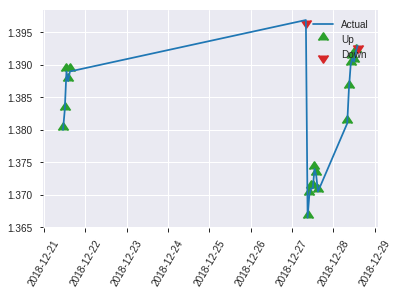


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1999142899063583
RMSE: 0.4471177584332323
LogLoss: 0.584195135575324
Mean Per-Class Error: 0.2810514786418401
AUC: 0.7783132530120481
pr_auc: 0.7126598670184198
Gini: 0.5566265060240962
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44612547755241394: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   56   0.5091   (56.0/110.0)
1      9    74   0.1084   (9.0/83.0)
Total  63   130  0.3368   (65.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446125     0.694836  129
max f2                       0.3625       0.817805  150
max f0point5                 0.696918     0.711297  38
max accuracy                 0.696918     0.720207  38
max precision                0.863369     1         0
max recall                   0.115893     1         189
max specificity              0.863369     1         0
max absolute_mcc             0.717156     0.449936  33
max min_per_class_accuracy   0.549812     0.690909  91
max mean_per_class_accuracy  0.540379     0.718949  95

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.835011           1.16265   1.16265            0.5              0.857206  0.5                         0.857206            0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.824543           2.3253    1.74398            1                0.829577  0.75                        0.843392            0.0240964       0.0361446                  132.53    74.3976
    3        0.0310881                   0.800375           2.3253    1.93775            1                0.823493  0.833333                    0.836759            0.0240964       0.060241                   132.53    93.7751
    4        0.0414508                   0.777313           2.3253    2.03464            1                0.787945  0.875                       0.824555            0.0240964       0.0843373                  132.53    103.464
    5        0.0518135                   0.773631           2.3253    2.09277            1                0.774558  0.9                         0.814556            0.0240964       0.108434                   132.53    109.277
    6        0.103627                    0.748863           2.09277   2.09277            0.9              0.760664  0.9                         0.78761             0.108434        0.216867                   109.277   109.277
    7        0.150259                    0.731465           2.06693   2.08475            0.888889         0.737635  0.896552                    0.7721              0.0963855       0.313253                   106.693   108.475
    8        0.202073                    0.696215           1.86024   2.02719            0.8              0.716355  0.871795                    0.757807            0.0963855       0.409639                   86.0241   102.719
    9        0.300518                    0.646724           0.979074  1.68384            0.421053         0.673847  0.724138                    0.730303            0.0963855       0.506024                   -2.09258  68.3839
    10       0.398964                    0.581653           1.10146   1.54013            0.473684         0.611356  0.662338                    0.700952            0.108434        0.614458                   10.1458   54.0135
    11       0.502591                    0.536528           1.27892   1.48627            0.55             0.559178  0.639175                    0.67172             0.13253         0.746988                   27.8916   48.6275
    12       0.601036                    0.494245           0.734306  1.36311            0.315789         0.517993  0.586207                    0.646541            0.0722892       0.819277                   -26.5694  36.3108
    13       0.699482                    0.42775            0.734306  1.27461            0.315789         0.460727  0.548148                    0.620389            0.0722892       0.891566                   -26.5694  27.461
    14       0.797927                    0.337137           0.611921  1.19285            0.263158         0.385919  0.512987                    0.591461            0.060241        0.951807                   -38.8079  19.2849
    15       0.896373                    0.222918           0.244769  1.08872            0.105263         0.26294   0.468208                    0.555381            0.0240964       0.975904                   -75.5231  8.87248
    16       1                           0.0883459          0.23253   1                  0.1              0.145466  0.430052                    0.512903          

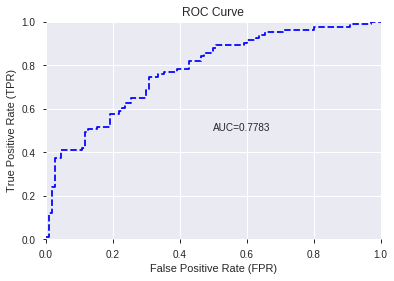

This function is available for GLM models only


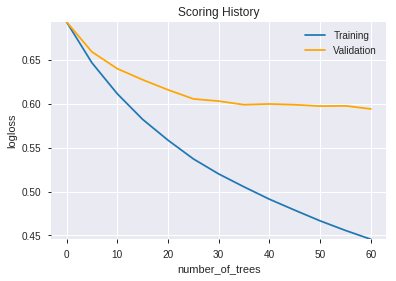

--2019-09-06 02:04:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.232
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.232|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


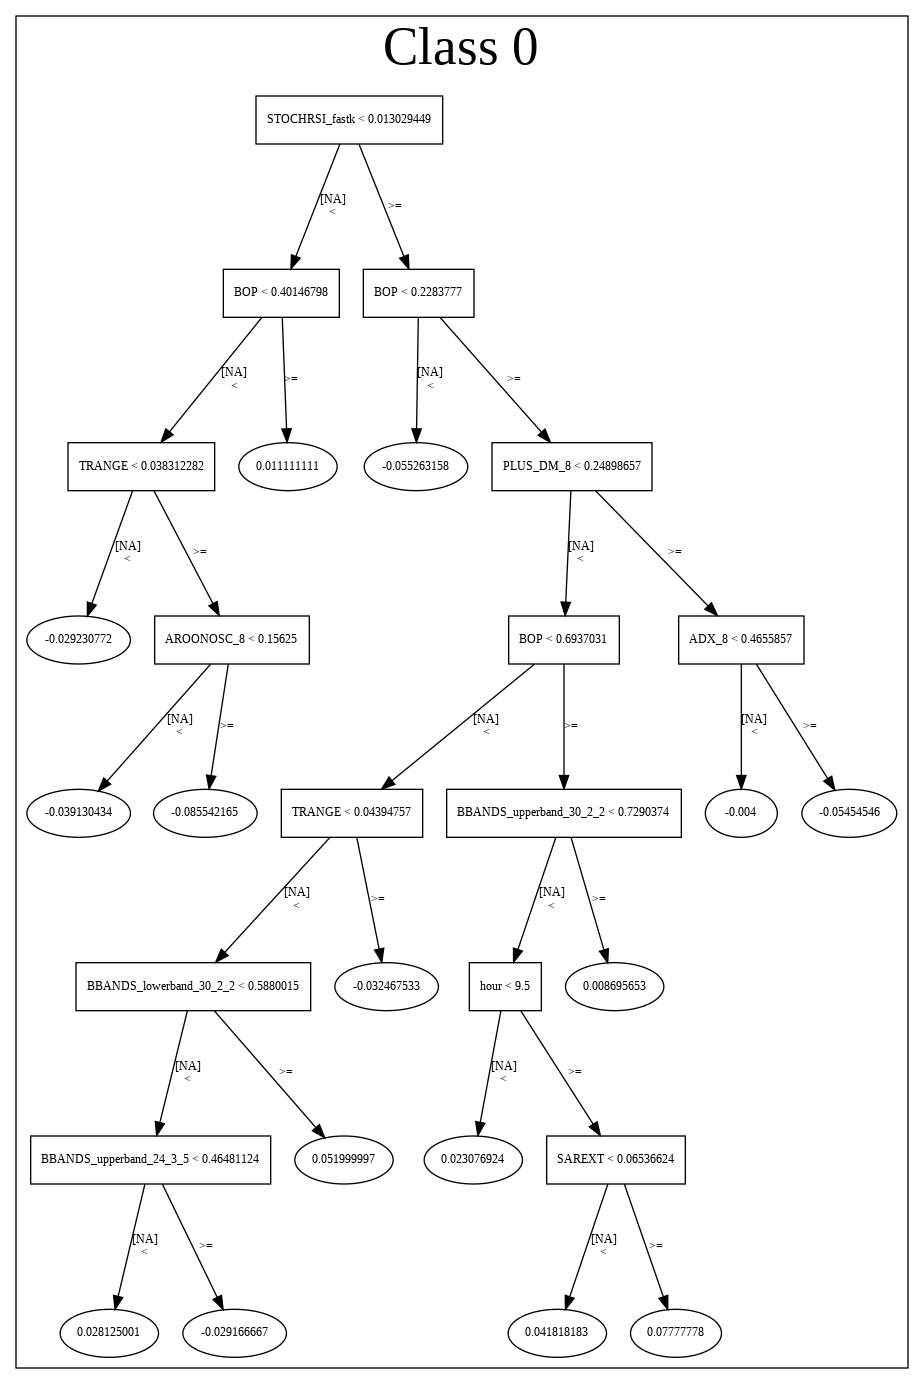

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190906_020352',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190906_020352',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_be9c',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_020449_model_5  0.748412  0.583626              0.358872  0.446850  0.199675
1  DeepLearning_grid_1_AutoML_20190906_020449_model_3  0.748083  0.725382              0.346605  0.468518  0.219510
2  DeepLearning_grid_1_AutoML_20190906_020449_model_8  0.747317  0.612426              0.311501  0.457803  0.209584
3  DeepLearning_grid_1_AutoML_20190906_020449_model_9  0.747207  0.598645              0.341950  0.454645  0.206702
4  DeepLearning_grid_1_AutoML_20190906_020449_model_7  0.739430  0.655089              0.293100  0.463585  0.214911
5               DeepLearning_1_AutoML_20190906_020449  0.738883  0.615514              0.338992  0.462103  0.213539
6  DeepLearning_grid_1_AutoML_20190906_020449_model_6  0.731435  0.638623              0.317744  0.471327  0.222149
7  DeepLearning_grid_1_AutoML_20190906_020449_model_4  0.705257  0.776946              0.352410  0.494426  0.244457
8  DeepLearning_grid_1_AutoML_20190906_020449_model_2  0.691785  0.837853              0.393866  0.502717  0.252725
9  DeepLearning_grid_1_AutoML_20190906_020449_model_1  0.677766  0.904090              0.419551  0.507760  0.257820

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.022796
1          STOCHF_fastk             0.965088           0.965088    0.022000
2       CDLSHOOTINGSTAR             0.957527           0.957527    0.021827
3             aroonup_8             0.942866           0.942866    0.021493
4        is_month_start             0.932280           0.932280    0.021252
5     CDL3WHITESOLDIERS             0.929825           0.929825    0.021196
6                  hour             0.927314           0.927314    0.021139
7         CDLHIKKAKEMOD             0.925549           0.925549    0.021099
8      CDLSTICKSANDWICH             0.923971           0.923971    0.021063
9         days_in_month             0.917751           0.917751    0.020921
10   CDLMORNINGDOJISTAR             0.917586           0.917586    0.020917
11           AROONOSC_8             0.917501           0.917501    0.020915
12           CDL3INSIDE             0.915356           0.915356    0.020866
13            dayofweek             0.915032           0.915032    0.020859
14       CDLMORNINGSTAR             0.914829           0.914829    0.020854
15              WILLR_8             0.898431           0.898431    0.020480
16            CORREL_24             0.897422           0.897422    0.020457
17            CDLONNECK             0.895169           0.895169    0.020406
18    CDLSTALLEDPATTERN             0.894878           0.894878    0.020399
19               TRANGE             0.892366           0.892366    0.020342
20      CDLHOMINGPIGEON             0.891002           0.891002    0.020311
21                  SUB             0.884829           0.884829    0.020170
22      CDLLADDERBOTTOM             0.883007           0.883007    0.020129
23  CDLGAPSIDESIDEWHITE             0.881971           0.881971    0.020105
24         CDLSHORTLINE             0.879046           0.879046    0.020038
25              weekday             0.878513           0.878513    0.020026
26    CDLINVERTEDHAMMER             0.877660           0.877660    0.020007
27   CDLCLOSINGMARUBOZU             0.872852           0.872852    0.019897
28            CDLHAMMER             0.856303           0.856303    0.019520
29     CDLDRAGONFLYDOJI             0.856029           0.856029    0.019514
30   CDLIDENTICAL3CROWS             0.852803           0.852803    0.019440
31          CDLPIERCING             0.850861           0.850861    0.019396
32         CDLTHRUSTING             0.847480           0.847480    0.019319
33         is_month_end             0.846889           0.846889    0.019305
34       CDLEVENINGSTAR             0.844243           0.844243    0.019245
35                  DIV             0.843661           0.843661    0.019232
36          CDLLONGLINE             0.841699           0.841699    0.019187
37             CORREL_8             0.840955           0.840955    0.019170
38       STOCHRSI_fastd             0.837913           0.837913    0.019101
39         weekday_name             0.833858           0.833858    0.019008
40    CDLGRAVESTONEDOJI             0.833617           0.833617    0.019003
41   CDLEVENINGDOJISTAR             0.833475           0.833475    0.019000
42       CDLMATCHINGLOW             0.832215           0.832215    0.018971
43      CDLADVANCEBLOCK             0.831037           0.831037    0.018944
44            CORREL_20             0.825244           0.825244    0.018812
45            CDLTAKURI             0.815715           0.815715    0.018595
46    CDLDARKCLOUDCOVER             0.813907           0.813907    0.018554
47         CDLTASUKIGAP             0.810681           0.810681    0.018480
48  CDLRISEFALL3METHODS             0.806213           0.806213    0.018378
49        CDLHANGINGMAN             0.783549           0.783549    0.017862

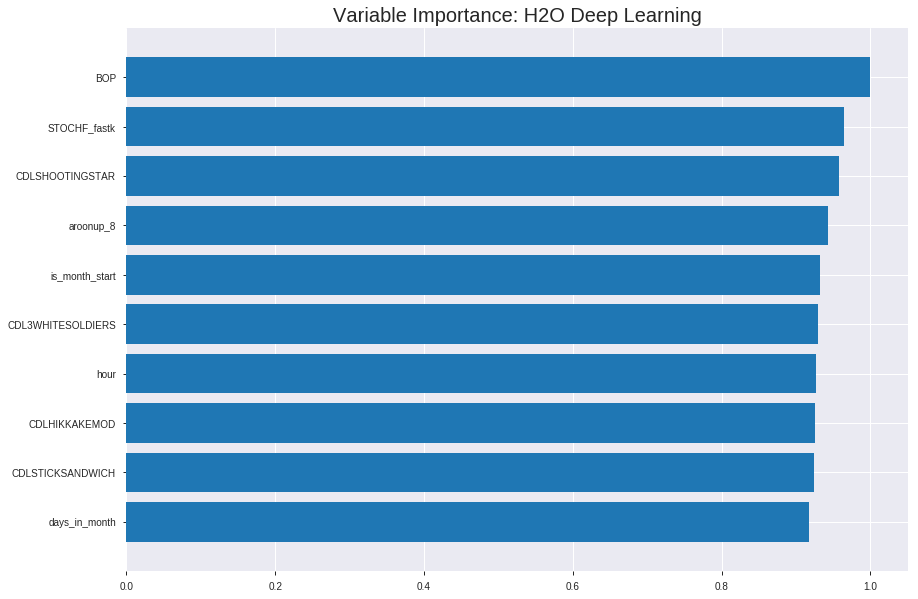

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_020449_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19522004300764584
RMSE: 0.4418371227133884
LogLoss: 0.5732202188976414
Mean Per-Class Error: 0.2846941021126761
AUC: 0.7796599911971831
pr_auc: 0.738970937315139
Gini: 0.5593199823943662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31760835194830406: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      408  302  0.4254   (302.0/710.0)
1      105  535  0.1641   (105.0/640.0)
Total  513  837  0.3015   (407.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317608     0.724441  261
max f2                       0.163699     0.83691   340
max f0point5                 0.478881     0.713246  180
max accuracy                 0.432606     0.717037  201
max precision                0.978032     1         0
max recall                   0.0623378    1         386
max specificity              0.978032     1         0
max absolute_mcc             0.478881     0.432311  180
max min_per_class_accuracy   0.404192     0.709859  216
max mean_per_class_accuracy  0.387711     0.715306  224

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 42.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.948369           1.65737   1.65737            0.785714         0.956987   0.785714                    0.956987            0.0171875       0.0171875                  65.7366   65.7366
    2        0.02                        0.92835            2.10938   1.875              1                0.93925    0.888889                    0.948447            0.0203125       0.0375                     110.938   87.5
    3        0.0303704                   0.916219           1.95871   1.90358            0.928571         0.921225   0.902439                    0.939152            0.0203125       0.0578125                  95.8705   90.3582
    4        0.04                        0.901279           1.78486   1.875              0.846154         0.907877   0.888889                    0.931623            0.0171875       0.075                      78.4856   87.5
    5        0.0503704                   0.881548           1.95871   1.89223            0.928571         0.892356   0.897059                    0.923538            0.0203125       0.0953125                  95.8705   89.2233
    6        0.1                         0.746865           1.73158   1.8125             0.820896         0.814565   0.859259                    0.869455            0.0859375       0.18125                    73.1576   81.25
    7        0.15037                     0.680323           1.61305   1.74569            0.764706         0.712255   0.827586                    0.816797            0.08125         0.2625                     61.3051   74.569
    8        0.2                         0.629757           1.41674   1.66406            0.671642         0.656144   0.788889                    0.776931            0.0703125       0.332813                   41.6744   66.4062
    9        0.3                         0.540839           1.4375    1.58854            0.681481         0.584566   0.753086                    0.71281             0.14375         0.476562                   43.75     58.8542
    10       0.4                         0.469083           1.4375    1.55078            0.681481         0.506397   0.735185                    0.661207            0.14375         0.620313                   43.75     55.0781
    11       0.5                         0.397697           1.03125   1.44687            0.488889         0.430721   0.685926                    0.615109            0.103125        0.723437                   3.125     44.6875
    12       0.6                         0.326784           0.953125  1.36458            0.451852         0.362172   0.646914                    0.572953            0.0953125       0.81875                    -4.6875   36.4583
    13       0.7                         0.264292           0.640625  1.26116            0.303704         0.297948   0.597884                    0.533667            0.0640625       0.882812                   -35.9375  26.1161
    14       0.8                         0.205895           0.546875  1.17188            0.259259         0.235669   0.555556                    0.496417            0.0546875       0.9375                     -45.3125  17.1875
    15       0.9                         0.141401           0.453125  1.09201            0.214815         0.173518   0.517695                    0.460539            0.0453125       0.982812                   -54.6875  9.20139
    16       1                           0.0142468          0.171875  1                  0.0814815        0.0885665  0.474074                    0.423342



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20728028251522831
RMSE: 0.4552804438093386
LogLoss: 0.6024262586985968
Mean Per-Class Error: 0.3067201903062742
AUC: 0.7406266050333847
pr_auc: 0.7169648206567292
Gini: 0.48125321006676947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26435569442936097: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   116  0.555    (116.0/209.0)
1      27   150  0.1525   (27.0/177.0)
Total  120  266  0.3705   (143.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.264356     0.677201  265
max f2                       0.103455     0.819209  353
max f0point5                 0.405293     0.670945  169
max accuracy                 0.405293     0.696891  169
max precision                0.9594       1         0
max recall                   0.0623151    1         373
max specificity              0.9594       1         0
max absolute_mcc             0.405293     0.387994  169
max min_per_class_accuracy   0.375715     0.677966  186
max mean_per_class_accuracy  0.405293     0.69328   169

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 39.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.9479             2.18079   2.18079            1                0.955698   1                           0.955698            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.938639           1.63559   1.90819            0.75             0.943787   0.875                       0.949742            0.0169492       0.039548                   63.5593   90.8192
    3        0.0310881                   0.908193           2.18079   1.99906            1                0.922961   0.916667                    0.940815            0.0225989       0.0621469                  118.079   99.9058
    4        0.0414508                   0.880763           2.18079   2.04449            1                0.895697   0.9375                      0.929535            0.0225989       0.0847458                  118.079   104.449
    5        0.0518135                   0.850937           1.63559   1.96271            0.75             0.859332   0.9                         0.915495            0.0169492       0.101695                   63.5593   96.2712
    6        0.101036                    0.727914           1.95123   1.95712            0.894737         0.778516   0.897436                    0.848762            0.0960452       0.19774                    95.1234   95.712
    7        0.150259                    0.635223           1.72168   1.87999            0.789474         0.674741   0.862069                    0.791755            0.0847458       0.282486                   72.1677   87.9992
    8        0.202073                    0.574297           1.19944   1.70549            0.55             0.602988   0.782051                    0.743353            0.0621469       0.344633                   19.9435   70.549
    9        0.300518                    0.492521           1.26256   1.56039            0.578947         0.537156   0.715517                    0.675806            0.124294        0.468927                   26.2563   56.0394
    10       0.401554                    0.430813           1.11835   1.44917            0.512821         0.45986    0.664516                    0.621471            0.112994        0.581921                   11.8354   44.9171
    11       0.5                         0.369983           1.14778   1.38983            0.526316         0.398882   0.637306                    0.577645            0.112994        0.694915                   14.7785   38.9831
    12       0.601036                    0.309089           0.782848  1.28779            0.358974         0.338089   0.590517                    0.537375            0.079096        0.774011                   -21.7152  28.7795
    13       0.699482                    0.251337           0.74606   1.21155            0.342105         0.283823   0.555556                    0.50169             0.0734463       0.847458                   -25.394   21.1551
    14       0.800518                    0.189005           0.615095  1.13627            0.282051         0.219773   0.521036                    0.466108            0.0621469       0.909605                   -38.4905  13.627
    15       0.898964                    0.11227            0.631282  1.08097            0.289474         0.15271    0.495677                    0.431788            0.0621469       0.971751                   -36.8718  8.09684
    16       1                           0.0274399          0.279589  1                  0.128205         0.0736391  0.458549                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:08:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:08:30  1 min 38.276 sec  1137 obs/sec      1.65481   1             2234       0.441837         0.57322             0.217015       0.77966         0.738971           1.65737          0.301481                         0.45528            0.602426              0.165141         0.740627          0.716965             2.18079            0.370466
    2019-09-06 02:08:36  1 min 44.438 sec  1756 obs/sec      9.83333   6             13275      0.431445         0.547687            0.253412       0.803148        0.77455            2.10938          0.28963                          0.458962           0.606353              0.151584         0.750628          0.727846             2.18079            0.349741
    2019-09-06 02:08:42  1 min 50.733 sec  2003 obs/sec      19.7081   12            26606      0.425999         0.530377            0.272143       0.827428        0.813122           2.10938          0.262222                         0.474753           0.639271              0.092199         0.728597          0.704693             2.18079            0.373057
    2019-09-06 02:08:48  1 min 56.801 sec  2128 obs/sec      29.5896   18            39946      0.393855         0.460937            0.37784        0.85621         0.84517            2.10938          0.265926                         0.471669           0.645872              0.103954         0.726489          0.686376             2.18079            0.417098
    2019-09-06 02:08:54  2 min  2.689 sec  2208 obs/sec      39.4      24            53190      0.380772         0.432325            0.418488       0.872915        0.863192           2.10938          0.245926                         0.473745           0.669102              0.0960507        0.721812          0.699301             2.18079            0.435233
    2019-09-06 02:09:00  2 min  8.467 sec  2271 obs/sec      49.2341   30            66466      0.367062         0.403302            0.45961        0.890407        0.864772           2.10938          0.231111                         0.484804           0.696973              0.0533561        0.711108          0.689472             2.18079            0.443005
    2019-09-06 02:09:01  2 min  9.160 sec  2270 obs/sec      49.2341   30            66466      0.441837         0.57322             0.217015       0.77966         0.738971           1.65737          0.301481                         0.45528            0.602426              0.165141         0.740627          0.716965             2.18079            0.370466

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.02279567530097812
STOCHF_fastk         0.9650879502296448     0.9650879502296448   0.02199983155032151
CDLSHOOTINGSTAR      0.9575273394584656     0.9575273394584656   0.021827482322104633
aroonup_8            0.9428663849830627     0.9428663849830627   0.02149327596428093
is_month_start       0.9322797656059265     0.9322797656059265   0.02125194682642469
---                  ---                    ---                  ---
CDLTAKURI            0.8157148361206055     0.8157148361206055   0.0185947705423959
CDLDARKCLOUDCOVER    0.8139070272445679     0.8139070272445679   0.01855356031825152
CDLTASUKIGAP         0.8106814026832581     0.8106814026832581   0.01848003002810904
CDLRISEFALL3METHODS  0.8062126040458679     0.8062126040458679   0.018378160745385643
CDLHANGINGMAN        0.7835491895675659     0.7835491895675659   0.017861532907726782


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.694300518134715)

('F1', 0.6666666666666667)

('auc', 0.7484118291347207)

('logloss', 0.5836261574624309)

('mean_per_class_error', 0.3125410733844469)

('rmse', 0.4468495480232128)

('mse', 0.1996745185685496)

deeplearning prediction progress: |███████████████████████████████████████| 100%


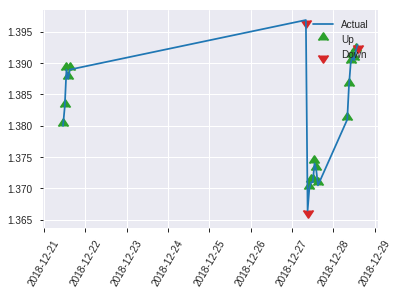


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1996745185685496
RMSE: 0.4468495480232128
LogLoss: 0.5836261574624309
Mean Per-Class Error: 0.3125410733844469
AUC: 0.7484118291347207
pr_auc: 0.6814943294519703
Gini: 0.4968236582694414
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25194832416854934: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      39   71   0.6455   (71.0/110.0)
1      6    77   0.0723   (6.0/83.0)
Total  45   148  0.399    (77.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251948     0.666667  147
max f2                       0.230952     0.809426  155
max f0point5                 0.519214     0.650155  59
max accuracy                 0.519214     0.694301  59
max precision                0.960342     1         0
max recall                   0.0902774    1         184
max specificity              0.960342     1         0
max absolute_mcc             0.624576     0.378344  29
max min_per_class_accuracy   0.415787     0.662651  90
max mean_per_class_accuracy  0.433858     0.687459  81

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 41.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.915359           2.3253    2.3253             1                0.938212   1                           0.938212            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.8975             1.16265   1.74398            0.5              0.908295   0.75                        0.923254            0.0120482       0.0361446                  16.2651   74.3976
    3        0.0310881                   0.873816           2.3253    1.93775            1                0.889471   0.833333                    0.911993            0.0240964       0.060241                   132.53    93.7751
    4        0.0414508                   0.825              1.16265   1.74398            0.5              0.856721   0.75                        0.898175            0.0120482       0.0722892                  16.2651   74.3976
    5        0.0518135                   0.782586           2.3253    1.86024            1                0.80891    0.8                         0.880322            0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.711217           2.09277   1.97651            0.9              0.743482   0.85                        0.811902            0.108434        0.204819                   109.277   97.6506
    7        0.150259                    0.625622           2.06693   2.00457            0.888889         0.659387   0.862069                    0.76457             0.0963855       0.301205                   106.693   100.457
    8        0.202073                    0.583205           1.39518   1.84832            0.6              0.598923   0.794872                    0.722096            0.0722892       0.373494                   39.5181   84.8316
    9        0.300518                    0.520481           1.10146   1.60366            0.473684         0.554005   0.689655                    0.667032            0.108434        0.481928                   10.1458   60.3656
    10       0.398964                    0.448259           1.22384   1.50994            0.526316         0.481736   0.649351                    0.621309            0.120482        0.60241                    22.3843   50.9936
    11       0.502591                    0.391931           0.93012   1.39039            0.4              0.422115   0.597938                    0.580238            0.0963855       0.698795                   -6.98795  39.0386
    12       0.601036                    0.349089           0.85669   1.30297            0.368421         0.368384   0.560345                    0.545538            0.0843373       0.783133                   -14.331   30.2971
    13       0.699482                    0.303559           0.85669   1.24016            0.368421         0.328705   0.533333                    0.515021            0.0843373       0.86747                    -14.331   24.0161
    14       0.797927                    0.232785           0.734306  1.17775            0.315789         0.267501   0.506494                    0.484483            0.0722892       0.939759                   -26.5694  17.775
    15       0.896373                    0.155098           0.367153  1.08872            0.157895         0.192481   0.468208                    0.452413            0.0361446       0.975904                   -63.2847  8.87248
    16       1                           0.0388238          0.23253   1                  0.1              0.0990035  0.430052                    0

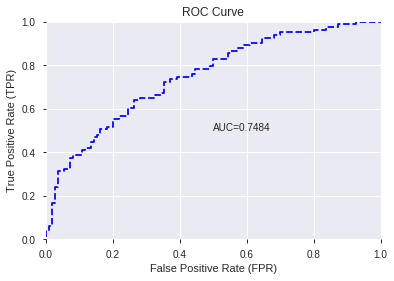

This function is available for GLM models only


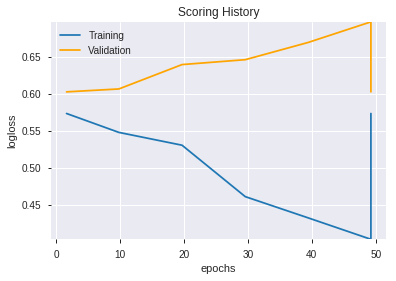

--2019-09-06 02:13:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


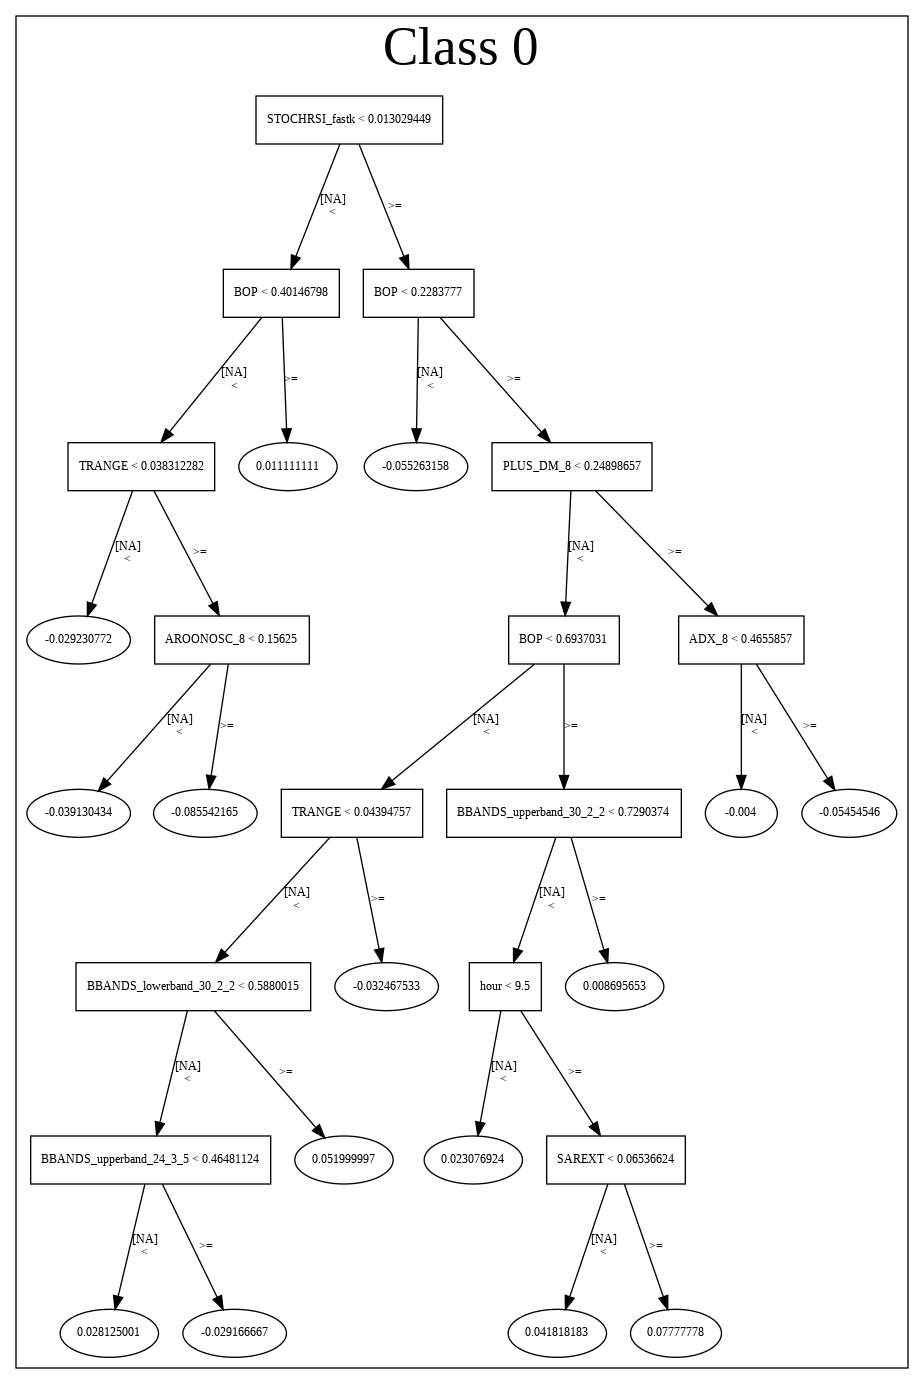

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_020449_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_020449_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'aroonup_8',
 'is_month_start',
 'CDL3WHITESOLDIERS',
 'hour',
 'CDLHIKKAKEMOD',
 'CDLSTICKSANDWICH',
 'days_in_month',
 'CDLMORNINGDOJISTAR',
 'AROONOSC_8',
 'CDL3INSIDE',
 'dayofweek',
 'CDLMORNINGSTAR',
 'WILLR_8',
 'CORREL_24',
 'CDLONNECK',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'CDLHOMINGPIGEON',
 'SUB',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLSHORTLINE',
 'weekday',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'is_month_end',
 'CDLEVENINGSTAR',
 'DIV',
 'CDLLONGLINE',
 'CORREL_8',
 'STOCHRSI_fastd',
 'weekday_name',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CORREL_20',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'CDLTASUKIGAP',
 'CDLRISEFALL3METHODS',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_021329_model_1  0.740745  0.596493              0.328423  0.45312  0.205318

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.289383           1.000000    0.101721
1    CDLCLOSINGMARUBOZU             0.186740           0.645304    0.065641
2                  hour             0.163152           0.563794    0.057350
3          STOCHF_fastk             0.148970           0.514786    0.052365
4               WILLR_8             0.129423           0.447237    0.045494
5           CDLLONGLINE             0.119911           0.414370    0.042150
6            AROONOSC_8             0.104884           0.362440    0.036868
7             aroonup_8             0.102717           0.354952    0.036106
8                   SUB             0.101021           0.349092    0.035510
9                   DIV             0.092916           0.321084    0.032661
10               TRANGE             0.092299           0.318950    0.032444
11      CDLSHOOTINGSTAR             0.088467           0.305710    0.031097
12     CDLDRAGONFLYDOJI             0.086308           0.298249    0.030338
13         CDLSHORTLINE             0.083705           0.289255    0.029423
14       STOCHRSI_fastd             0.081206           0.280620    0.028545
15        CDLHANGINGMAN             0.080548           0.278344    0.028313
16            CDLTAKURI             0.076840           0.265532    0.027010
17            CDLHAMMER             0.075704           0.261606    0.026611
18    CDLGRAVESTONEDOJI             0.064780           0.223855    0.022771
19    CDLDARKCLOUDCOVER             0.063083           0.217991    0.022174
20    CDL3WHITESOLDIERS             0.050316           0.173874    0.017687
21  CDLRISEFALL3METHODS             0.042792           0.147873    0.015042
22      CDLLADDERBOTTOM             0.041719           0.144167    0.014665
23    CDLSTALLEDPATTERN             0.038090           0.131625    0.013389
24   CDLEVENINGDOJISTAR             0.034582           0.119504    0.012156
25    CDLINVERTEDHAMMER             0.033235           0.114849    0.011683
26       CDLEVENINGSTAR             0.033114           0.114430    0.011640
27            CDLONNECK             0.030014           0.103717    0.010550
28         weekday_name             0.026100           0.090192    0.009174
29  CDLGAPSIDESIDEWHITE             0.024444           0.084471    0.008592
30   CDLIDENTICAL3CROWS             0.024021           0.083008    0.008444
31       is_month_start             0.022484           0.077695    0.007903
32            CORREL_24             0.021942           0.075823    0.007713
33       CDLMORNINGSTAR             0.019329           0.066795    0.006794
34     CDLSTICKSANDWICH             0.019009           0.065689    0.006682
35            CORREL_20             0.015986           0.055240    0.005619
36      CDLHOMINGPIGEON             0.015876           0.054861    0.005580
37       CDLMATCHINGLOW             0.014411           0.049798    0.005065
38   CDLMORNINGDOJISTAR             0.014016           0.048434    0.004927
39            dayofweek             0.011798           0.040769    0.004147
40              weekday             0.011752           0.040610    0.004131
41         CDLTASUKIGAP             0.010794           0.037299    0.003794
42          CDLPIERCING             0.010580           0.036561    0.003719
43        days_in_month             0.010188           0.035207    0.003581
44         is_month_end             0.008744           0.030216    0.003074
45      CDLADVANCEBLOCK             0.008523           0.029451    0.002996
46             CORREL_8             0.007551           0.026093    0.002654
47        CDLHIKKAKEMOD             0.007164           0.024755    0.002518
48           CDL3INSIDE             0.003252           0.011236    0.001143
49         CDLTHRUSTING             0.000978           0.003380    0.000344

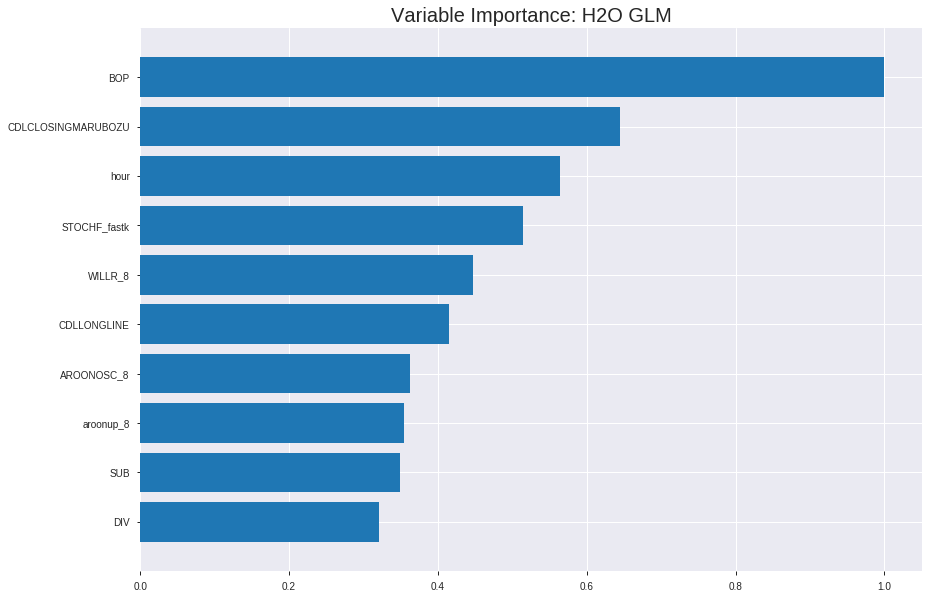

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_021329_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19456682446231416
RMSE: 0.4410972959136274
LogLoss: 0.5737772204427809
Null degrees of freedom: 1349
Residual degrees of freedom: 1299
Null deviance: 1867.8661296847088
Residual deviance: 1549.1984951955085
AIC: 1651.1984951955085
AUC: 0.7832130281690141
pr_auc: 0.7326784109256458
Gini: 0.5664260563380281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4045263041396613: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      402  308  0.4338   (308.0/710.0)
1      99   541  0.1547   (99.0/640.0)
Total  501  849  0.3015   (407.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404526     0.726662  240
max f2                       0.262538     0.838468  325
max f0point5                 0.507939     0.713324  177
max accuracy                 0.507939     0.722222  177
max precision                0.939094     1         0
max recall                   0.125817     1         385
max specificity              0.939094     1         0
max absolute_mcc             0.488959     0.442471  187
max min_per_class_accuracy   0.479084     0.714085  194
max mean_per_class_accuracy  0.488959     0.720973  187

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.859746           1.5067    1.5067             0.714286         0.889104  0.714286                    0.889104            0.015625        0.015625                   50.6696   50.6696
    2        0.02                        0.831924           1.6226    1.5625             0.769231         0.845325  0.740741                    0.868025            0.015625        0.03125                    62.2596   56.25
    3        0.0303704                   0.812628           1.65737   1.59489            0.785714         0.822591  0.756098                    0.852511            0.0171875       0.0484375                  65.7366   59.4893
    4        0.04                        0.797761           2.10938   1.71875            1                0.804773  0.814815                    0.841018            0.0203125       0.06875                    110.938   71.875
    5        0.0503704                   0.780127           1.80804   1.73713            0.857143         0.789887  0.823529                    0.830491            0.01875         0.0875                     80.8036   73.7132
    6        0.1                         0.717527           1.92048   1.82812            0.910448         0.74533   0.866667                    0.788226            0.0953125       0.182812                   92.0476   82.8125
    7        0.15037                     0.673683           1.55101   1.7353             0.735294         0.694758  0.82266                     0.756916            0.078125        0.260937                   55.1011   73.5299
    8        0.2                         0.635992           1.51119   1.67969            0.716418         0.655461  0.796296                    0.731741            0.075           0.335938                   51.1194   67.9688
    9        0.3                         0.579963           1.39062   1.58333            0.659259         0.604536  0.750617                    0.689339            0.139063        0.475                      39.0625   58.3333
    10       0.4                         0.522194           1.39062   1.53516            0.659259         0.553655  0.727778                    0.655418            0.139063        0.614062                   39.0625   53.5156
    11       0.5                         0.475074           1.15625   1.45937            0.548148         0.497654  0.691852                    0.623865            0.115625        0.729688                   15.625    45.9375
    12       0.6                         0.418214           0.859375  1.35938            0.407407         0.445587  0.644444                    0.594152            0.0859375       0.815625                   -14.0625  35.9375
    13       0.7                         0.367556           0.734375  1.27009            0.348148         0.393271  0.602116                    0.565455            0.0734375       0.889062                   -26.5625  27.0089
    14       0.8                         0.313498           0.625     1.18945            0.296296         0.341081  0.563889                    0.537408            0.0625          0.951562                   -37.5     18.9453
    15       0.9                         0.228396           0.328125  1.09375            0.155556         0.275088  0.518519                    0.508261            0.0328125       0.984375                   -67.1875  9.375
    16       1                           0.0290362          0.15625   1                  0.0740741        0.166389  0.474074                    0.474074            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2071360303782368
RMSE: 0.4551219950499391
LogLoss: 0.6008092954394438
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 532.8273288418734
Residual deviance: 463.8247760792506
AIC: 565.8247760792506
AUC: 0.7350039196604764
pr_auc: 0.6926556847746184
Gini: 0.4700078393209528
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27059838280110765: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      55   154  0.7368   (154.0/209.0)
1      7    170  0.0395   (7.0/177.0)
Total  62   324  0.4171   (161.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270598     0.678643  323
max f2                       0.257246     0.823699  329
max f0point5                 0.566281     0.6942    97
max accuracy                 0.566281     0.696891  97
max precision                0.897095     1         0
max recall                   0.14457      1         374
max specificity              0.897095     1         0
max absolute_mcc             0.566281     0.406903  97
max min_per_class_accuracy   0.458455     0.660287  187
max mean_per_class_accuracy  0.442295     0.678899  199

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.849009           2.18079   2.18079            1                0.876876  1                           0.876876            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.841502           1.63559   1.90819            0.75             0.846553  0.875                       0.861714            0.0169492       0.039548                   63.5593   90.8192
    3        0.0310881                   0.820482           1.63559   1.81733            0.75             0.833444  0.833333                    0.852291            0.0169492       0.0564972                  63.5593   81.7326
    4        0.0414508                   0.792402           1.63559   1.77189            0.75             0.807128  0.8125                      0.841               0.0169492       0.0734463                  63.5593   77.1893
    5        0.0518135                   0.767967           1.63559   1.74463            0.75             0.773065  0.8                         0.827413            0.0169492       0.0903955                  63.5593   74.4633
    6        0.101036                    0.714485           1.72168   1.73345            0.789474         0.742547  0.794872                    0.786068            0.0847458       0.175141                   72.1677   73.3449
    7        0.150259                    0.643193           1.83646   1.76719            0.842105         0.683253  0.810345                    0.752388            0.0903955       0.265537                   83.6456   76.7193
    8        0.202073                    0.59804            1.63559   1.73345            0.75             0.620956  0.794872                    0.718687            0.0847458       0.350282                   63.5593   73.3449
    9        0.300518                    0.543908           1.37734   1.61679            0.631579         0.571643  0.741379                    0.670518            0.135593        0.485876                   37.7342   61.6793
    10       0.401554                    0.499247           0.950601  1.44917            0.435897         0.517864  0.664516                    0.632108            0.0960452       0.581921                   -4.93988  44.9171
    11       0.5                         0.453676           0.975617  1.35593            0.447368         0.478225  0.621762                    0.60181             0.0960452       0.677966                   -2.4383   35.5932
    12       0.601036                    0.403335           0.838766  1.26899            0.384615         0.42488   0.581897                    0.572067            0.0847458       0.762712                   -16.1234  26.8995
    13       0.699482                    0.357182           0.688671  1.18732            0.315789         0.37989   0.544444                    0.54502             0.0677966       0.830508                   -31.1329  18.732
    14       0.800518                    0.294255           0.950601  1.15744            0.435897         0.328771  0.530744                    0.517727            0.0960452       0.926554                   -4.93988  15.7442
    15       0.898964                    0.212208           0.459114  1.08097            0.210526         0.258089  0.495677                    0.489294            0.0451977       0.971751                   -54.0886  8.09684
    16       1                           0.0167416          0.279589  1                  0.128205         0.159993  0.458549                    0.456022          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:13:30  0.000 sec   2            17        51            1.36833           1.36606
    2019-09-06 02:13:30  0.009 sec   4            11        51            1.35987           1.35819
    2019-09-06 02:13:30  0.018 sec   6            6.7       51            1.34743           1.34672
    2019-09-06 02:13:30  0.029 sec   8            4.2       51            1.32996           1.33079
    2019-09-06 02:13:30  0.039 sec   10           2.6       51            1.30693           1.31022
    2019-09-06 02:13:30  0.048 sec   12           1.6       51            1.27892           1.28599
    2019-09-06 02:13:30  0.056 sec   14           1         51            1.24795           1.26057
    2019-09-06 02:13:30  0.063 sec   16           0.62      51            1.21691           1.23716
    2019-09-06 02:13:30  0.070 sec   18           0.39      51            1.18876           1.21873
    2019-09-06 02:13:30  0.077 sec   20           0.24      51            1.16543           1.20687
    2019-09-06 02:13:30  0.082 sec   22           0.15      51            1.14755           1.20162
    2019-09-06 02:13:30  0.090 sec   24           0.093     51            1.13467           1.2018
    2019-09-06 02:13:30  0.095 sec   26           0.057     51            1.12579           1.20576
    2019-09-06 02:13:30  0.100 sec   28           0.036     51            1.1199            1.21192
    2019-09-06 02:13:30  0.109 sec   30           0.022     51            1.11614           1.21904
    2019-09-06 02:13:30  0.118 sec   32           0.014     51            1.11383           1.2262

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.6790697674418603)

('auc', 0.7407447973713035)

('logloss', 0.5964927256605164)

('mean_per_class_error', 0.3106243154435926)

('rmse', 0.4531198764230492)

('mse', 0.20531762240963938)

glm prediction progress: |████████████████████████████████████████████████| 100%


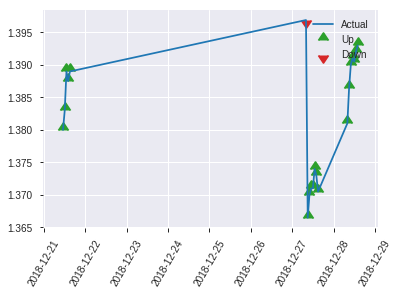


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20531762240963938
RMSE: 0.4531198764230492
LogLoss: 0.5964927256605164
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 265.27189969043866
Residual deviance: 230.24619210495933
AIC: 332.24619210495933
AUC: 0.7407447973713035
pr_auc: 0.6481964912849458
Gini: 0.481489594742607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3920139389522836: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   59   0.5364   (59.0/110.0)
1      10   73   0.1205   (10.0/83.0)
Total  61   132  0.3575   (69.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392014     0.67907   131
max f2                       0.248594     0.816733  169
max f0point5                 0.58286      0.687285  51
max accuracy                 0.58286      0.715026  51
max precision                0.866639     1         0
max recall                   0.219294     1         176
max specificity              0.866639     1         0
max absolute_mcc             0.58286      0.416048  51
max min_per_class_accuracy   0.473429     0.672727  91
max mean_per_class_accuracy  0.566284     0.689376  55

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 46.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.828921           2.3253    2.3253             1                0.854939  1                           0.854939            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.791335           1.16265   1.74398            0.5              0.814617  0.75                        0.834778            0.0120482       0.0361446                  16.2651   74.3976
    3        0.0310881                   0.769492           1.16265   1.5502             0.5              0.78239   0.666667                    0.817315            0.0120482       0.0481928                  16.2651   55.0201
    4        0.0414508                   0.764057           1.16265   1.45331            0.5              0.766651  0.625                       0.804649            0.0120482       0.060241                   16.2651   45.3313
    5        0.0518135                   0.757913           2.3253    1.62771            1                0.762024  0.7                         0.796124            0.0240964       0.0843373                  132.53    62.7711
    6        0.103627                    0.710569           1.86024   1.74398            0.8              0.730369  0.75                        0.763246            0.0963855       0.180723                   86.0241   74.3976
    7        0.150259                    0.637576           1.80857   1.76402            0.777778         0.67335   0.758621                    0.735348            0.0843373       0.26506                    80.8568   76.4022
    8        0.202073                    0.610517           1.62771   1.72907            0.7              0.624068  0.74359                     0.706814            0.0843373       0.349398                   62.7711   72.907
    9        0.300518                    0.561312           1.591     1.68384            0.684211         0.587084  0.724138                    0.667592            0.156627        0.506024                   59.0996   68.3839
    10       0.398964                    0.505618           0.85669   1.47974            0.368421         0.527861  0.636364                    0.633113            0.0843373       0.590361                   -14.331   47.9737
    11       0.502591                    0.467212           0.93012   1.36641            0.4              0.482696  0.587629                    0.602099            0.0963855       0.686747                   -6.98795  36.6414
    12       0.601036                    0.434108           1.10146   1.32302            0.473684         0.44891   0.568966                    0.577008            0.108434        0.795181                   10.1458   32.3016
    13       0.699482                    0.381321           0.85669   1.25739            0.368421         0.413233  0.540741                    0.553958            0.0843373       0.879518                   -14.331   25.7385
    14       0.797927                    0.327785           0.367153  1.14755            0.157895         0.353348  0.493506                    0.529208            0.0361446       0.915663                   -63.2847  14.7551
    15       0.896373                    0.224952           0.734306  1.10217            0.315789         0.282756  0.473988                    0.502141            0.0722892       0.987952                   -26.5694  10.2166
    16       1                           0.0404253          0.116265  1                  0.05             0.172283  0.430052                    0.467958           

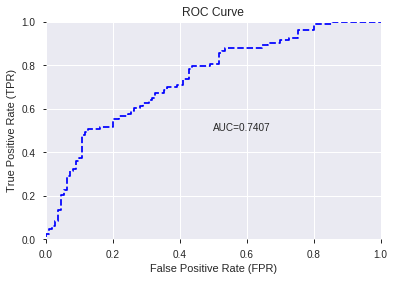

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


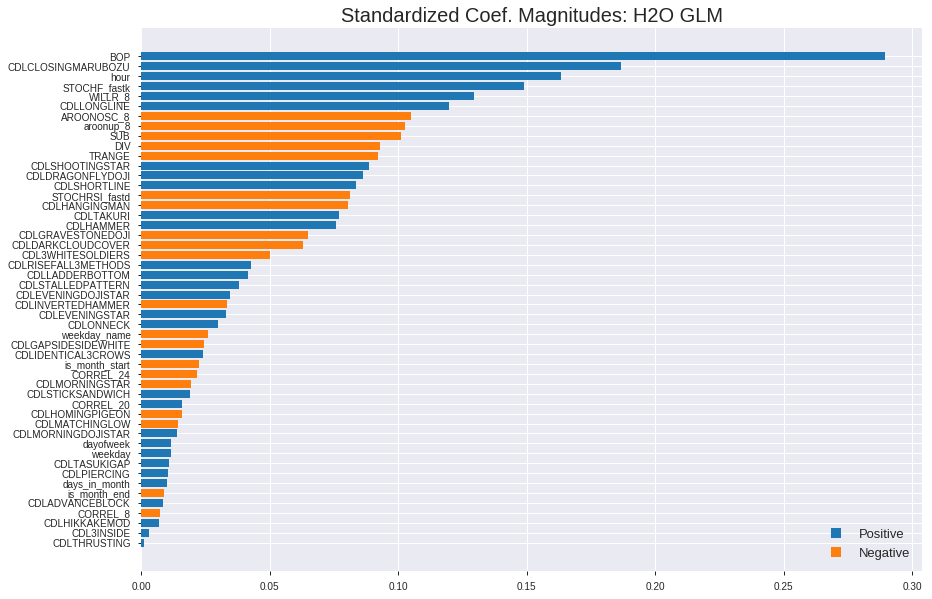

'log_likelihood'
--2019-09-06 02:13:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


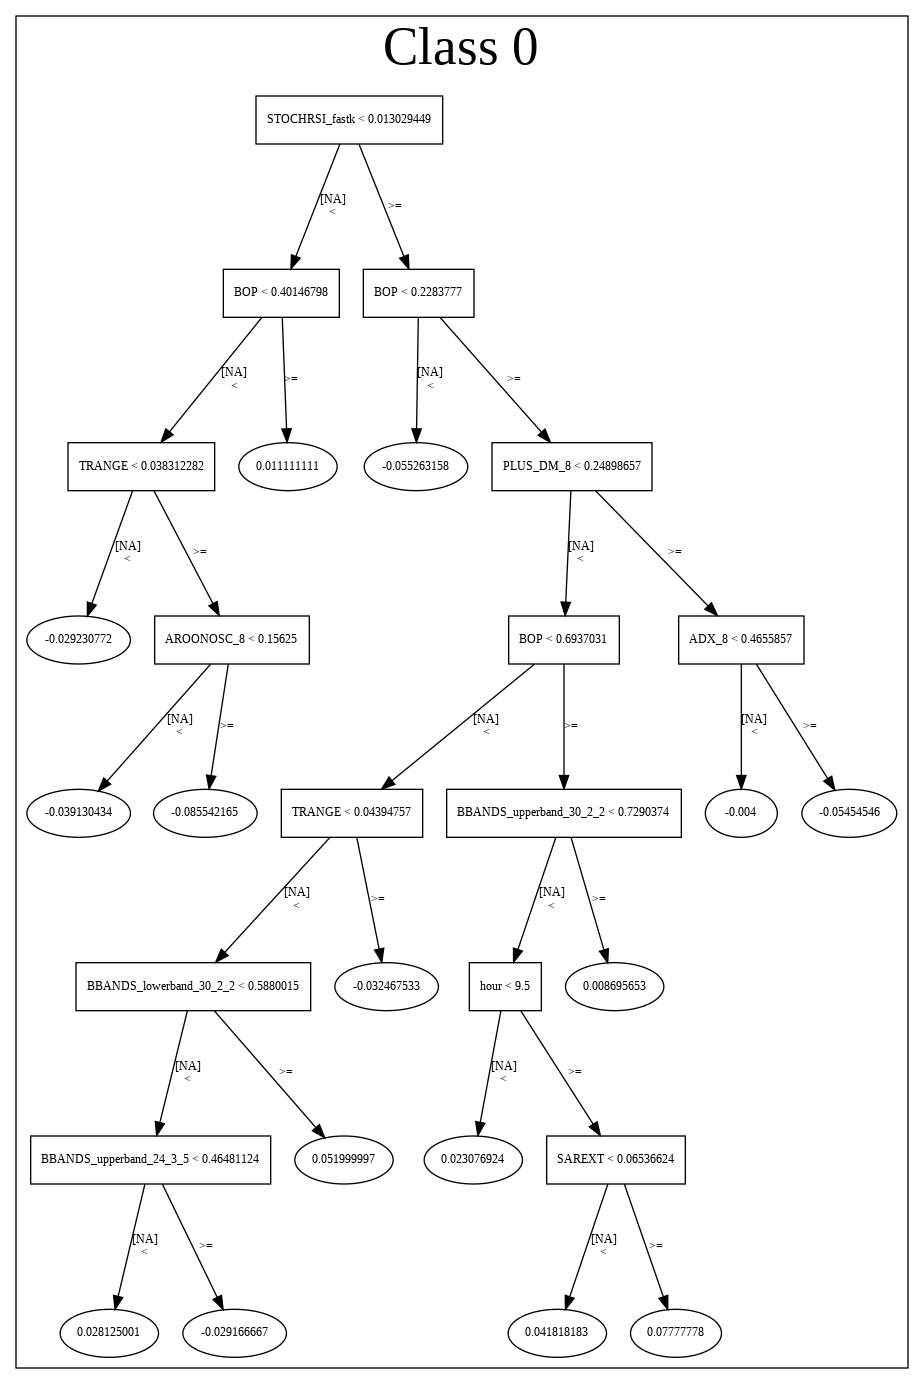

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_021329_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_021329_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLLONGLINE',
 'AROONOSC_8',
 'aroonup_8',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLRISEFALL3METHODS',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'weekday_name',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'CDLSTICKSANDWICH',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'CDLMATCHINGLOW',
 'CDLMORNINGDOJISTAR',
 'dayofweek',
 'weekday',
 'CDLTASUKIGAP',
 'CDLPIERCING',
 'days_in_month',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CORREL_8',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLTHRUSTING']

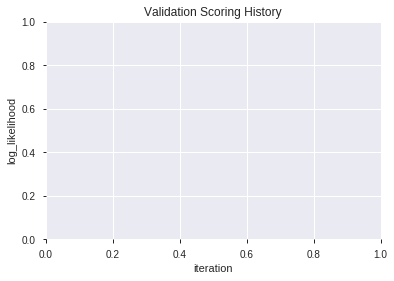

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_021350_model_3  0.760898  0.586116              0.316265  0.448188  0.200873
1  XGBoost_grid_1_AutoML_20190906_021350_model_4  0.758488  0.583577              0.276506  0.447403  0.200169
2               XGBoost_2_AutoML_20190906_021350  0.758379  0.586992              0.290252  0.449317  0.201885
3               XGBoost_1_AutoML_20190906_021350  0.751369  0.586591              0.305586  0.450090  0.202581
4  XGBoost_grid_1_AutoML_20190906_021350_model_1  0.749507  0.591201              0.332968  0.451331  0.203700
5               XGBoost_3_AutoML_20190906_021350  0.743593  0.596800              0.354326  0.454691  0.206744
6  XGBoost_grid_1_AutoML_20190906_021350_model_5  0.737240  0.606055              0.343866  0.458575  0.210291
7  XGBoost_grid_1_AutoML_20190906_021350_model_2  0.735159  0.602873              0.338883  0.457200  0.209032
8  XGBoost_grid_1_AutoML_20190906_021350_model_6  0.729792  0.602836              0.334228  0.458384  0.210116
9  XGBoost_grid_1_AutoML_20190906_021350_model_7  0.728368  0.603495              0.325356  0.457729  0.209516

variable  relative_importance  scaled_importance  percentage
0                  BOP          1106.007324           1.000000    0.201486
1         STOCHF_fastk           541.332092           0.489447    0.098617
2                 hour           437.369965           0.395449    0.079678
3               TRANGE           352.276886           0.318512    0.064176
4       STOCHRSI_fastd           333.789185           0.301797    0.060808
5                  SUB           316.672119           0.286320    0.057690
6            CORREL_20           311.394775           0.281549    0.056728
7              WILLR_8           277.247986           0.250675    0.050508
8             CORREL_8           260.183319           0.235246    0.047399
9                  DIV           240.620926           0.217558    0.043835
10           CORREL_24           215.849838           0.195161    0.039322
11           aroonup_8           211.891800           0.191583    0.038601
12          AROONOSC_8           206.540176           0.186744    0.037626
13  CDLCLOSINGMARUBOZU           180.931503           0.163590    0.032961
14           dayofweek            90.412552           0.081747    0.016471
15    CDLDRAGONFLYDOJI            76.824974           0.069462    0.013996
16         CDLLONGLINE            68.678833           0.062096    0.012512
17        CDLSHORTLINE            56.146732           0.050765    0.010229
18        weekday_name            50.464733           0.045628    0.009193
19             weekday            44.528084           0.040260    0.008112
20           CDLHAMMER            33.988869           0.030731    0.006192
21       days_in_month            28.721195           0.025968    0.005232
22       CDLHANGINGMAN            16.665668           0.015068    0.003036
23           CDLTAKURI            15.474340           0.013991    0.002819
24   CDLGRAVESTONEDOJI            15.229479           0.013770    0.002774

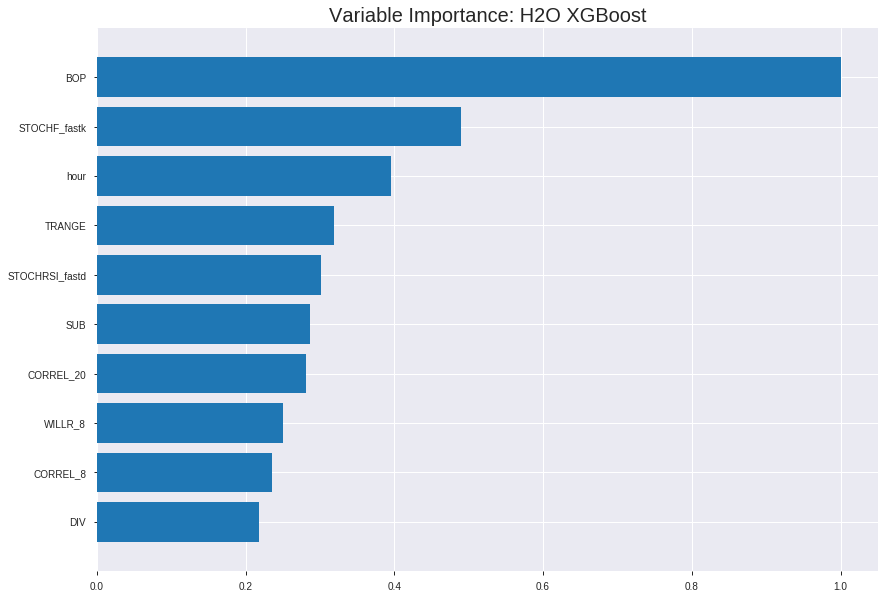

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_021350_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1438710473725088
RMSE: 0.37930337115890334
LogLoss: 0.45568658531096506
Mean Per-Class Error: 0.1854863556338029
AUC: 0.9012400968309859
pr_auc: 0.8907297918185336
Gini: 0.8024801936619719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4436374753713608: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      518  192  0.2704   (192.0/710.0)
1      69   571  0.1078   (69.0/640.0)
Total  587  763  0.1933   (261.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443637     0.81397   217
max f2                       0.332704     0.880332  271
max f0point5                 0.60723      0.826035  135
max accuracy                 0.550844     0.813333  164
max precision                0.927312     1         0
max recall                   0.170465     1         353
max specificity              0.927312     1         0
max absolute_mcc             0.487774     0.628722  197
max min_per_class_accuracy   0.515542     0.807813  182
max mean_per_class_accuracy  0.487774     0.814514  197

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.885844           2.10938   2.10938            1                0.900163  1                           0.900163            0.021875        0.021875                   110.938   110.938
    2        0.02                        0.864209           2.10938   2.10938            1                0.87337   1                           0.887263            0.0203125       0.0421875                  110.938   110.938
    3        0.0303704                   0.843336           2.10938   2.10938            1                0.852784  1                           0.875489            0.021875        0.0640625                  110.938   110.938
    4        0.04                        0.82938            2.10938   2.10938            1                0.8365    1                           0.866103            0.0203125       0.084375                   110.938   110.938
    5        0.0503704                   0.812582           2.10938   2.10938            1                0.820638  1                           0.856743            0.021875        0.10625                    110.938   110.938
    6        0.1                         0.777628           1.98344   2.04688            0.940299         0.792158  0.97037                     0.824689            0.0984375       0.204687                   98.3442   104.688
    7        0.15037                     0.737381           2.04733   2.04703            0.970588         0.756659  0.970443                    0.801901            0.103125        0.307812                   104.733   104.703
    8        0.2                         0.703302           1.88899   2.00781            0.895522         0.720063  0.951852                    0.781593            0.09375         0.401562                   88.8993   100.781
    9        0.3                         0.633583           1.76562   1.92708            0.837037         0.669049  0.91358                     0.744078            0.176563        0.578125                   76.5625   92.7083
    10       0.4                         0.56774            1.39062   1.79297            0.659259         0.60396   0.85                        0.709049            0.139063        0.717187                   39.0625   79.2969
    11       0.5                         0.503419           1.0625    1.64687            0.503704         0.535429  0.780741                    0.674325            0.10625         0.823438                   6.25      64.6875
    12       0.6                         0.413046           0.9375    1.52865            0.444444         0.458262  0.724691                    0.638314            0.09375         0.917188                   -6.25     52.8646
    13       0.7                         0.324639           0.453125  1.375              0.214815         0.36622   0.651852                    0.599444            0.0453125       0.9625                     -54.6875  37.5
    14       0.8                         0.232082           0.25      1.23437            0.118519         0.27752   0.585185                    0.559203            0.025           0.9875                     -75       23.4375
    15       0.9                         0.151734           0.125     1.11111            0.0592593        0.191934  0.526749                    0.518396            0.0125          1                          -87.5     11.1111
    16       1                           0.0576749          0         1                  0                0.107337  0.474074                    0.47729             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20377845794295588
RMSE: 0.4514182738247931
LogLoss: 0.5899534443993091
Mean Per-Class Error: 0.30957208120455215
AUC: 0.7453031654637364
pr_auc: 0.7130937268915437
Gini: 0.49060633092747286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2297513633966446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      68   141  0.6746   (141.0/209.0)
1      11   166  0.0621   (11.0/177.0)
Total  79   307  0.3938   (152.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.229751     0.68595   306
max f2                       0.138243     0.834119  352
max f0point5                 0.589694     0.664697  124
max accuracy                 0.465615     0.689119  192
max precision                0.884697     1         0
max recall                   0.138243     1         352
max specificity              0.884697     1         0
max absolute_mcc             0.465615     0.379545  192
max min_per_class_accuracy   0.4733       0.679426  187
max mean_per_class_accuracy  0.465615     0.690428  192

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 44.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.83875            2.18079   2.18079            1                0.876364  1                           0.876364            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.820684           1.63559   1.90819            0.75             0.825372  0.875                       0.850868            0.0169492       0.039548                   63.5593   90.8192
    3        0.0310881                   0.814511           2.18079   1.99906            1                0.818184  0.916667                    0.839973            0.0225989       0.0621469                  118.079   99.9058
    4        0.0414508                   0.789559           2.18079   2.04449            1                0.800768  0.9375                      0.830172            0.0225989       0.0847458                  118.079   104.449
    5        0.0518135                   0.772145           2.18079   2.07175            1                0.783283  0.95                        0.820794            0.0225989       0.107345                   118.079   107.175
    6        0.101036                    0.729701           1.95123   2.01304            0.894737         0.752614  0.923077                    0.787578            0.0960452       0.20339                    95.1234   101.304
    7        0.150259                    0.687583           1.26256   1.76719            0.578947         0.712372  0.810345                    0.762941            0.0621469       0.265537                   26.2563   76.7193
    8        0.202073                    0.651843           1.52655   1.70549            0.7              0.672065  0.782051                    0.73964             0.079096        0.344633                   52.6554   70.549
    9        0.300518                    0.601513           1.26256   1.56039            0.578947         0.625976  0.715517                    0.702405            0.124294        0.468927                   26.2563   56.0394
    10       0.401554                    0.536183           1.17427   1.46324            0.538462         0.565489  0.670968                    0.667955            0.118644        0.587571                   17.4272   46.324
    11       0.5                         0.46377            1.20517   1.41243            0.552632         0.498168  0.647668                    0.634525            0.118644        0.706215                   20.5174   41.2429
    12       0.601036                    0.392153           0.72693   1.29719            0.333333         0.433781  0.594828                    0.60078             0.0734463       0.779661                   -27.307   29.7195
    13       0.699482                    0.287101           0.74606   1.21963            0.342105         0.339215  0.559259                    0.563967            0.0734463       0.853107                   -25.394   21.9628
    14       0.800518                    0.228596           0.838766  1.17156            0.384615         0.256502  0.537217                    0.525161            0.0847458       0.937853                   -16.1234  17.1558
    15       0.898964                    0.148422           0.459114  1.09354            0.210526         0.187365  0.501441                    0.488169            0.0451977       0.983051                   -54.0886  9.35378
    16       1                           0.0620807          0.167753  1                  0.0769231        0.106039  0.458549                    0.44956            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:13:55  1.472 sec   0                  0.5              0.693147            0.5             0                  1                0.525926                         0.5                0.693147              0.5               0                    1                  0.541451
    2019-09-06 02:13:55  1.532 sec   5                  0.476283         0.646557            0.825957        0.796049           2.10938          0.27037                          0.482518           0.658571              0.743262          0.714159             2.18079            0.349741
    2019-09-06 02:13:55  1.583 sec   10                 0.456172         0.607798            0.847075        0.824692           2.10938          0.254074                         0.471239           0.636144              0.744141          0.712479             2.18079            0.34456
    2019-09-06 02:13:55  1.644 sec   15                 0.438937         0.574424            0.857191        0.835238           2.10938          0.223704                         0.461592           0.616324              0.745046          0.706455             2.18079            0.352332
    2019-09-06 02:13:55  1.714 sec   20                 0.427935         0.552697            0.861098        0.84103            2.10938          0.217037                         0.456604           0.605536              0.750412          0.712039             2.18079            0.323834
    2019-09-06 02:13:55  1.789 sec   25                 0.418117         0.533442            0.869023        0.85174            2.10938          0.203704                         0.454001           0.599361              0.749709          0.709136             2.18079            0.34456
    2019-09-06 02:13:55  1.852 sec   30                 0.41065          0.518072            0.873401        0.857147           2.10938          0.211111                         0.451935           0.594296              0.749791          0.706963             2.18079            0.341969
    2019-09-06 02:13:55  1.904 sec   35                 0.40502          0.506716            0.877322        0.861006           2.10938          0.2                              0.45101            0.59188               0.751034          0.714522             2.18079            0.352332
    2019-09-06 02:13:55  1.962 sec   40                 0.397871         0.492598            0.885453        0.871314           2.10938          0.196296                         0.451452           0.591876              0.746574          0.703499             2.18079            0.352332
    2019-09-06 02:13:55  2.015 sec   45                 0.392294         0.481481            0.889708        0.875903           2.10938          0.199259                         0.451112           0.59019               0.747006          0.714436             2.18079            0.380829
    2019-09-06 02:13:55  2.112 sec   50                 0.387481         0.472081            0.894236        0.88046            2.10938          0.191111                         0.450708           0.589054              0.746763          0.714078             2.18079            0.38601
    2019-09-06 02:13:55  2.168 sec   55                 0.383594         0.46401             0.897007        0.885452           2.10938          0.186667                         0.4511             0.589878              0.745844          0.71

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                1106.00732421875       1.0                   0.20148629833511517
STOCHF_fastk       541.3320922851562      0.48944711344252334   0.09861688711834123
hour               437.3699645996094      0.39544942878977246   0.07967764158558698
TRANGE             352.2768859863281      0.31851225418888235   0.06417585507089119
STOCHRSI_fastd     333.7891845703125      0.30179654081955654   0.060807867860074936
---                ---                    ---                   ---
CDLHAMMER          33.988868713378906     0.030731142524203094  0.006191904150810529
days_in_month      28.721195220947266     0.025968358971976108  0.005232268523100943
CDLHANGINGMAN      16.665668487548828     0.01506831656772341   0.0030360593273722775
CDLTAKURI          15.474340438842773     0.013991173566389696  0.0028190297712559717
CDLGRAVESTONEDOJI  15.22947883605957      0.013769781178273129  0.0027744222384947933


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.6857142857142857)

('auc', 0.7608981380065718)

('logloss', 0.5861158430019953)

('mean_per_class_error', 0.292880613362541)

('rmse', 0.44818845954209324)

('mse', 0.20087289526671454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


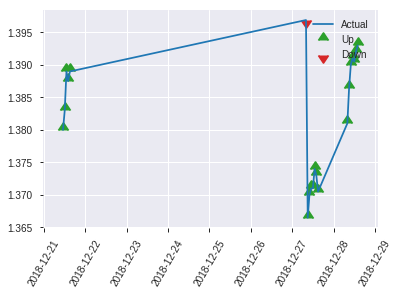


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20087289526671454
RMSE: 0.44818845954209324
LogLoss: 0.5861158430019953
Mean Per-Class Error: 0.292880613362541
AUC: 0.7608981380065718
pr_auc: 0.6610025311379442
Gini: 0.5217962760131436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39585718512535095: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   55   0.5      (55.0/110.0)
1      11   72   0.1325   (11.0/83.0)
Total  66   127  0.342    (66.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395857     0.685714  126
max f2                       0.207964     0.828343  168
max f0point5                 0.590208     0.676056  67
max accuracy                 0.590208     0.715026  67
max precision                0.798268     0.818182  10
max recall                   0.207964     1         168
max specificity              0.928858     0.990909  0
max absolute_mcc             0.572403     0.416296  79
max min_per_class_accuracy   0.538525     0.686747  90
max mean_per_class_accuracy  0.572403     0.707119  79

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.879853           1.16265   1.16265            0.5              0.91069   0.5                         0.91069             0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.862648           1.16265   1.16265            0.5              0.874739  0.5                         0.892715            0.0120482       0.0240964                  16.2651   16.2651
    3        0.0310881                   0.844509           2.3253    1.5502             1                0.855413  0.666667                    0.880281            0.0240964       0.0481928                  132.53    55.0201
    4        0.0414508                   0.814883           2.3253    1.74398            1                0.834326  0.75                        0.868792            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.800749           2.3253    1.86024            1                0.807111  0.8                         0.856456            0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.73522            1.39518   1.62771            0.6              0.772138  0.7                         0.814297            0.0722892       0.168675                   39.5181   62.7711
    7        0.150259                    0.703031           1.80857   1.68384            0.777778         0.723046  0.724138                    0.785978            0.0843373       0.253012                   80.8568   68.3839
    8        0.202073                    0.669618           2.3253    1.84832            1                0.687781  0.794872                    0.760799            0.120482        0.373494                   132.53    84.8316
    9        0.300518                    0.617508           1.22384   1.64375            0.526316         0.649906  0.706897                    0.724472            0.120482        0.493976                   22.3843   64.3747
    10       0.398964                    0.573816           1.34623   1.57033            0.578947         0.594551  0.675325                    0.692413            0.13253         0.626506                   34.6227   57.0333
    11       0.502591                    0.515643           0.93012   1.43833            0.4              0.544363  0.618557                    0.661888            0.0963855       0.722892                   -6.98795  43.8331
    12       0.601036                    0.439252           0.85669   1.34306            0.368421         0.475062  0.577586                    0.631287            0.0843373       0.807229                   -14.331   34.3062
    13       0.699482                    0.374748           0.734306  1.25739            0.315789         0.40629   0.540741                    0.599621            0.0722892       0.879518                   -26.5694  25.7385
    14       0.797927                    0.272838           0.489537  1.16265            0.210526         0.320808  0.5                         0.565222            0.0481928       0.927711                   -51.0463  16.2651
    15       0.896373                    0.18293            0.734306  1.11561            0.315789         0.241007  0.479769                    0.529614            0.0722892       1                          -26.5694  11.5607
    16       1                           0.077476           0         1                  0                0.115414  0.430052                    0.486692         

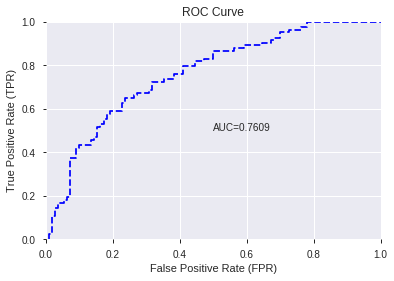

This function is available for GLM models only


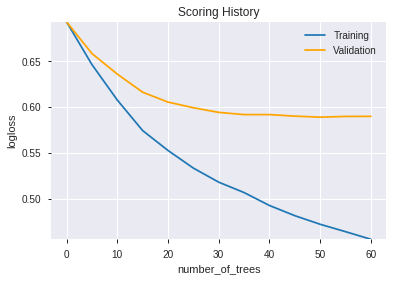

--2019-09-06 02:14:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

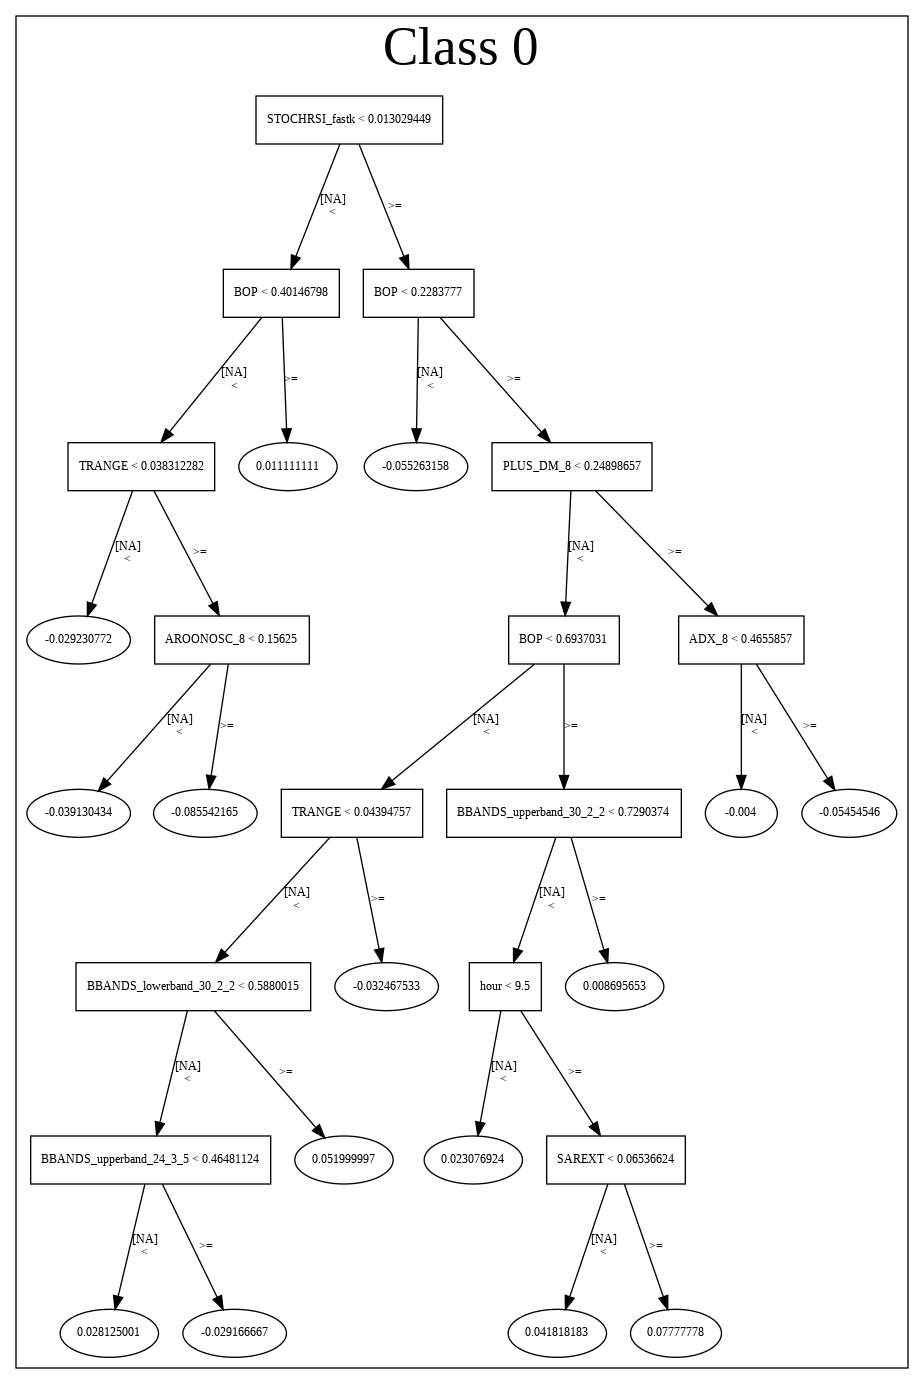

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_021350_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_021350_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'hour',
 'TRANGE',
 'STOCHRSI_fastd',
 'SUB',
 'CORREL_20',
 'WILLR_8',
 'CORREL_8',
 'DIV',
 'CORREL_24',
 'aroonup_8',
 'AROONOSC_8',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'weekday_name',
 'weekday',
 'CDLHAMMER',
 'days_in_month',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 937] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


24

['Volume',
 'hour',
 'BOP',
 'WILLR_8',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_021425_model_8  0.784666  0.573235              0.310350  0.442589  0.195885
1               DeepLearning_1_AutoML_20190906_021425  0.780613  0.600410              0.291950  0.454342  0.206427
2  DeepLearning_grid_1_AutoML_20190906_021425_model_5  0.774151  0.589310              0.305696  0.444902  0.197938
3  DeepLearning_grid_1_AutoML_20190906_021425_model_3  0.764841  0.663128              0.304107  0.454287  0.206377
4  DeepLearning_grid_1_AutoML_20190906_021425_model_6  0.764622  0.596123              0.313308  0.449910  0.202419
5  DeepLearning_grid_1_AutoML_20190906_021425_model_9  0.759693  0.587661              0.334556  0.449974  0.202477
6  DeepLearning_grid_1_AutoML_20190906_021425_model_4  0.731982  0.701770              0.320811  0.476672  0.227216
7  DeepLearning_grid_1_AutoML_20190906_021425_model_7  0.724535  0.675619              0.317853  0.478460  0.228924
8  DeepLearning_grid_1_AutoML_20190906_021425_model_1  0.723439  0.855439              0.333078  0.495189  0.245212
9  DeepLearning_grid_1_AutoML_20190906_021425_model_2  0.716101  0.748383              0.314567  0.496296  0.246310

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.071259
1   CDLCLOSINGMARUBOZU             0.820248           0.820248    0.058450
2                 hour             0.787695           0.787695    0.056131
3                  SUB             0.715359           0.715359    0.050976
4         CDLSHORTLINE             0.709000           0.709000    0.050523
5          CDLLONGLINE             0.675505           0.675505    0.048136
6                  DIV             0.640412           0.640412    0.045635
7               TRANGE             0.623373           0.623373    0.044421
8          CDLBELTHOLD             0.620035           0.620035    0.044183
9         STOCHF_fastk             0.611654           0.611654    0.043586
10      STOCHRSI_fastk             0.577832           0.577832    0.041176
11       CDLHANGINGMAN             0.540635           0.540635    0.038525
12            WILLR_24             0.540205           0.540205    0.038495
13               ADOSC             0.512359           0.512359    0.036510
14    CDLDRAGONFLYDOJI             0.507549           0.507549    0.036168
15              ULTOSC             0.507059           0.507059    0.036133
16              Volume             0.496473           0.496473    0.035378
17            WILLR_20             0.489929           0.489929    0.034912
18            WILLR_12             0.489825           0.489825    0.034905
19             WILLR_8             0.480133           0.480133    0.034214
20           CDLTAKURI             0.466384           0.466384    0.033234
21            WILLR_14             0.449633           0.449633    0.032040
22         CDLMARUBOZU             0.395977           0.395977    0.028217
23        CDLENGULFING             0.375994           0.375994    0.026793

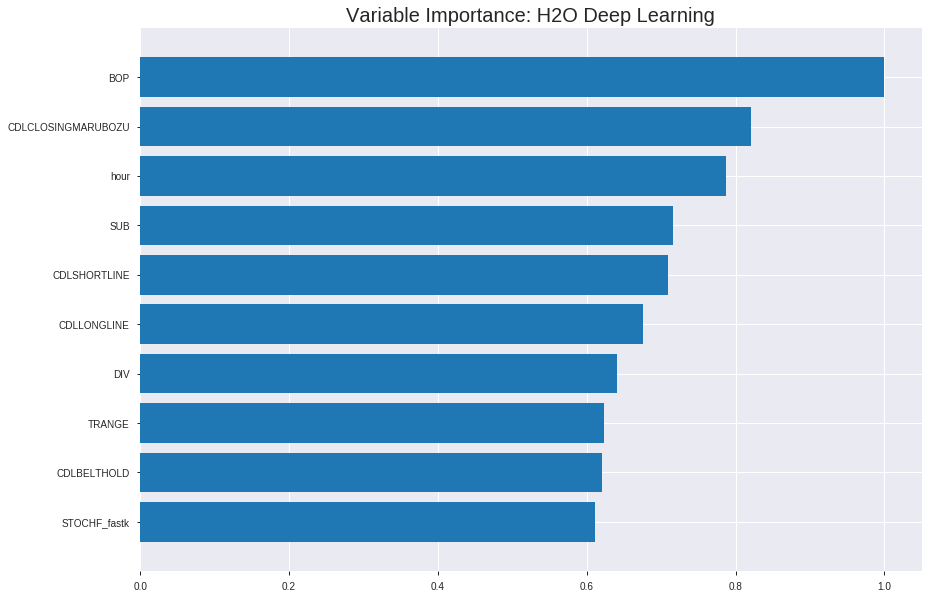

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_021425_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19075618516570395
RMSE: 0.43675643689097926
LogLoss: 0.5590008460814562
Mean Per-Class Error: 0.2908890845070422
AUC: 0.7829753521126761
pr_auc: 0.7562038948636958
Gini: 0.5659507042253522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47082060876358356: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      405  305  0.4296   (305.0/710.0)
1      104  536  0.1625   (104.0/640.0)
Total  509  841  0.303    (409.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470821     0.723835  216
max f2                       0.211111     0.843211  325
max f0point5                 0.566207     0.690574  147
max accuracy                 0.529172     0.706667  181
max precision                0.950084     1         0
max recall                   0.0628627    1         387
max specificity              0.950084     1         0
max absolute_mcc             0.470821     0.420281  216
max min_per_class_accuracy   0.52981      0.697183  180
max mean_per_class_accuracy  0.52376      0.709111  186

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.926678           1.80804   1.80804            0.857143         0.936251   0.857143                    0.936251            0.01875         0.01875                    80.8036   80.8036
    2        0.02                        0.911754           1.94712   1.875              0.923077         0.91962    0.888889                    0.928243            0.01875         0.0375                     94.7115   87.5
    3        0.0303704                   0.887902           2.10938   1.95503            1                0.902138   0.926829                    0.919329            0.021875        0.059375                   110.938   95.503
    4        0.04                        0.872259           2.10938   1.99219            1                0.88078    0.944444                    0.910049            0.0203125       0.0796875                  110.938   99.2187
    5        0.0503704                   0.854217           1.95871   1.98529            0.928571         0.862713   0.941176                    0.900303            0.0203125       0.1                        95.8705   98.5294
    6        0.1                         0.757736           1.79454   1.89062            0.850746         0.812151   0.896296                    0.856554            0.0890625       0.189062                   79.4543   89.0625
    7        0.15037                     0.66364            1.73713   1.83921            0.823529         0.697006   0.871921                    0.803109            0.0875          0.276562                   73.7132   83.9209
    8        0.2                         0.635828           1.35378   1.71875            0.641791         0.649131   0.814815                    0.7649              0.0671875       0.34375                    35.3778   71.875
    9        0.3                         0.575415           1.375     1.60417            0.651852         0.603773   0.760494                    0.711191            0.1375          0.48125                    37.5      60.4167
    10       0.4                         0.54982            1.15625   1.49219            0.548148         0.561885   0.707407                    0.673864            0.115625        0.596875                   15.625    49.2187
    11       0.5                         0.529126           1.20312   1.43437            0.57037          0.538345   0.68                        0.646761            0.120313        0.717187                   20.3125   43.4375
    12       0.6                         0.486073           0.921875  1.34896            0.437037         0.513635   0.639506                    0.624573            0.0921875       0.809375                   -7.8125   34.8958
    13       0.7                         0.406571           0.78125   1.26786            0.37037          0.449169   0.601058                    0.599515            0.078125        0.8875                     -21.875   26.7857
    14       0.8                         0.287204           0.578125  1.18164            0.274074         0.349534   0.560185                    0.568268            0.0578125       0.945312                   -42.1875  18.1641
    15       0.9                         0.158443           0.40625   1.09549            0.192593         0.21896    0.519342                    0.529456            0.040625        0.985938                   -59.375   9.54861
    16       1                           0.0178642          0.140625  1                  0.0666667        0.0969607  0.474074                    0.48



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1957959598085632
RMSE: 0.4424883725122765
LogLoss: 0.5683492053626702
Mean Per-Class Error: 0.30870705268564325
AUC: 0.7669559105776768
pr_auc: 0.7550371946034299
Gini: 0.5339118211553535
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4609883775823412: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  93   0.445    (93.0/209.0)
1      31   146  0.1751   (31.0/177.0)
Total  147  239  0.3212   (124.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460988     0.701923  238
max f2                       0.1394       0.830959  344
max f0point5                 0.58512      0.698835  105
max accuracy                 0.58512      0.702073  105
max precision                0.95374      1         0
max recall                   0.100516     1         359
max specificity              0.95374      1         0
max absolute_mcc             0.58512      0.412309  105
max min_per_class_accuracy   0.530636     0.683616  186
max mean_per_class_accuracy  0.527794     0.691293  196

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 47.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.921903           2.18079   2.18079            1                0.939459   1                           0.939459            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.911405           2.18079   2.18079            1                0.917664   1                           0.928561            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.87963            2.18079   2.18079            1                0.893545   1                           0.916889            0.0225989       0.0677966                  118.079   118.079
    4        0.0414508                   0.862846           2.18079   2.18079            1                0.871767   1                           0.905609            0.0225989       0.0903955                  118.079   118.079
    5        0.0518135                   0.856448           2.18079   2.18079            1                0.858685   1                           0.896224            0.0225989       0.112994                   118.079   118.079
    6        0.101036                    0.751274           1.95123   2.06896            0.894737         0.812131   0.948718                    0.855256            0.0960452       0.20904                    95.1234   106.896
    7        0.150259                    0.664405           1.49212   1.87999            0.684211         0.70039    0.862069                    0.804524            0.0734463       0.282486                   49.212    87.9992
    8        0.202073                    0.621138           1.63559   1.81733            0.75             0.64309    0.833333                    0.763131            0.0847458       0.367232                   63.5593   81.7326
    9        0.300518                    0.573643           1.20517   1.61679            0.552632         0.596211   0.741379                    0.70845             0.118644        0.485876                   20.5174   61.6793
    10       0.401554                    0.54835            1.11835   1.49138            0.512821         0.55933    0.683871                    0.670929            0.112994        0.59887                    11.8354   49.138
    11       0.5                         0.529217           1.03301   1.40113            0.473684         0.535946   0.642487                    0.644352            0.101695        0.700565                   3.30062   40.113
    12       0.601036                    0.46847            0.894683  1.31599            0.410256         0.5082     0.603448                    0.621465            0.0903955       0.79096                    -10.5317  31.5995
    13       0.699482                    0.371315           0.631282  1.21963            0.289474         0.427544   0.559259                    0.594172            0.0621469       0.853107                   -36.8718  21.9628
    14       0.800518                    0.250971           0.671013  1.15038            0.307692         0.311125   0.527508                    0.558448            0.0677966       0.920904                   -32.8987  15.0385
    15       0.898964                    0.132854           0.688671  1.09982            0.315789         0.185594   0.504323                    0.517616            0.0677966       0.988701                   -31.1329  9.98225
    16       1                           0.0299849          0.111835  1                  0.0512821        0.0892454  0.458549                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:20:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:20:24  1 min 18.964 sec  636 obs/sec       0.946667  1             1278       0.599697         1.28465             -0.442425      0.743585        0.697079           1.80804          0.32                             0.583285           1.25627               -0.370302        0.743843          0.714843             2.18079            0.341969
    2019-09-06 02:20:35  1 min 29.234 sec  1015 obs/sec      8.46296   9             11425      0.442969         0.574097            0.213          0.771254        0.741921           1.80804          0.305926                         0.442344           0.572856              0.211912         0.767091          0.749024             2.18079            0.360104
    2019-09-06 02:20:46  1 min 40.209 sec  1139 obs/sec      17.9089   19            24177      0.436756         0.559001            0.234918       0.782975        0.756204           1.80804          0.302963                         0.442488           0.568349              0.211396         0.766956          0.755037             2.18079            0.321244
    2019-09-06 02:20:57  1 min 51.010 sec  1190 obs/sec      27.3304   29            36896      0.431904         0.547234            0.251825       0.786976        0.762415           2.10938          0.314815                         0.446375           0.583561              0.197483         0.766145          0.750238             2.18079            0.360104
    2019-09-06 02:21:08  2 min  2.161 sec  1236 obs/sec      37.68     40            50868      0.433567         0.549541            0.246053       0.802029        0.776285           2.10938          0.291852                         0.457237           0.598181              0.15795          0.754764          0.735734             2.18079            0.367876
    2019-09-06 02:21:18  2 min 12.928 sec  1274 obs/sec      48.057    51            64877      0.42525          0.532306            0.274701       0.803425        0.784446           2.10938          0.301481                         0.450474           0.589023              0.182676         0.759171          0.74145              2.18079            0.290155
    2019-09-06 02:21:29  2 min 23.601 sec  1302 obs/sec      58.4259   62            78875      0.41445          0.507929            0.311073       0.818282        0.803083           2.10938          0.282222                         0.45033            0.597613              0.183198         0.751872          0.730685             2.18079            0.375648
    2019-09-06 02:21:30  2 min 24.636 sec  1301 obs/sec      58.4259   62            78875      0.436756         0.559001            0.234918       0.782975        0.756204           1.80804          0.302963                         0.442488           0.568349              0.211396         0.766956          0.755037             2.18079            0.321244

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.07125925695025617
CDLCLOSINGMARUBOZU  0.8202475309371948     0.8202475309371948   0.05845022956986677
hour                0.7876948714256287     0.7876948714256287   0.056130551241317876
SUB                 0.7153591513633728     0.7153591513633728   0.05097596157871978
CDLSHORTLINE        0.7089998722076416     0.7089998722076416   0.05052280407134312
---                 ---                    ---                  ---
WILLR_8             0.4801331162452698     0.4801331162452698   0.034213929100848896
CDLTAKURI           0.46638426184654236    0.46638426184654236  0.03323419595247832
WILLR_14            0.44963279366493225    0.44963279366493225  0.032040498777030926
CDLMARUBOZU         0.3959774374961853     0.3959774374961853   0.028217057965044673
CDLENGULFING        0.3759939670562744     0.3759939670562744   0.026793050710209213


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7564766839378239)

('F1', 0.6972477064220184)

('auc', 0.7846659364731654)

('logloss', 0.5732353827383272)

('mean_per_class_error', 0.2609529025191676)

('rmse', 0.4425893033959163)

('mse', 0.19588529148048242)

deeplearning prediction progress: |███████████████████████████████████████| 100%


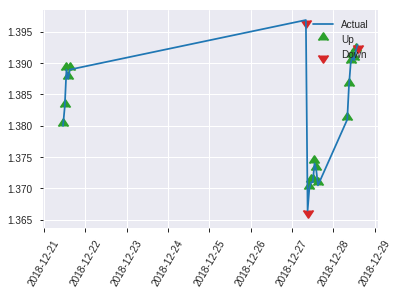


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19588529148048242
RMSE: 0.4425893033959163
LogLoss: 0.5732353827383272
Mean Per-Class Error: 0.2609529025191676
AUC: 0.7846659364731654
pr_auc: 0.7038582111770172
Gini: 0.5693318729463308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4312545145802151: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   59   0.5364   (59.0/110.0)
1      7    76   0.0843   (7.0/83.0)
Total  58   135  0.342    (66.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431255     0.697248  134
max f2                       0.415106     0.824524  140
max f0point5                 0.582751     0.740181  61
max accuracy                 0.582751     0.756477  61
max precision                0.931437     1         0
max recall                   0.165077     1         172
max specificity              0.931437     1         0
max absolute_mcc             0.582751     0.500623  61
max min_per_class_accuracy   0.534241     0.690909  91
max mean_per_class_accuracy  0.57361      0.739047  65

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.918317           2.3253    2.3253             1                0.926836  1                           0.926836            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.90071            2.3253    2.3253             1                0.911586  1                           0.919211            0.0240964       0.0481928                  132.53    132.53
    3        0.0310881                   0.889267           1.16265   1.93775            0.5              0.894973  0.833333                    0.911132            0.0120482       0.060241                   16.2651   93.7751
    4        0.0414508                   0.884055           1.16265   1.74398            0.5              0.887548  0.75                        0.905236            0.0120482       0.0722892                  16.2651   74.3976
    5        0.0518135                   0.881464           1.16265   1.62771            0.5              0.882459  0.7                         0.900681            0.0120482       0.0843373                  16.2651   62.7711
    6        0.103627                    0.713648           2.3253    1.97651            1                0.815419  0.85                        0.85805             0.120482        0.204819                   132.53    97.6506
    7        0.150259                    0.680312           1.29183   1.76402            0.555556         0.692852  0.758621                    0.806782            0.060241        0.26506                    29.1834   76.4022
    8        0.202073                    0.633307           1.62771   1.72907            0.7              0.659415  0.74359                     0.768995            0.0843373       0.349398                   62.7711   72.907
    9        0.300518                    0.586826           1.95815   1.80411            0.842105         0.607829  0.775862                    0.7162              0.192771        0.542169                   95.8148   80.4113
    10       0.398964                    0.563627           1.22384   1.66093            0.526316         0.573108  0.714286                    0.680891            0.120482        0.662651                   22.3843   66.0929
    11       0.502591                    0.529511           0.581325  1.43833            0.25             0.54693   0.618557                    0.65327             0.060241        0.722892                   -41.8675  43.8331
    12       0.601036                    0.495465           0.85669   1.34306            0.368421         0.515226  0.577586                    0.63066             0.0843373       0.807229                   -14.331   34.3062
    13       0.699482                    0.429991           1.10146   1.30906            0.473684         0.459753  0.562963                    0.606606            0.108434        0.915663                   10.1458   30.9058
    14       0.797927                    0.297839           0.367153  1.19285            0.157895         0.364052  0.512987                    0.576681            0.0361446       0.951807                   -63.2847  19.2849
    15       0.896373                    0.15355            0.489537  1.11561            0.210526         0.244412  0.479769                    0.540189            0.0481928       1                          -51.0463  11.5607
    16       1                           0.0388579          0         1                  0                0.10339   0.430052                    0.494925            

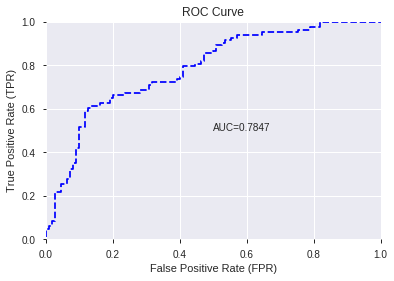

This function is available for GLM models only


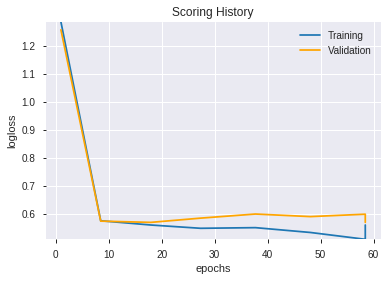

--2019-09-06 02:22:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


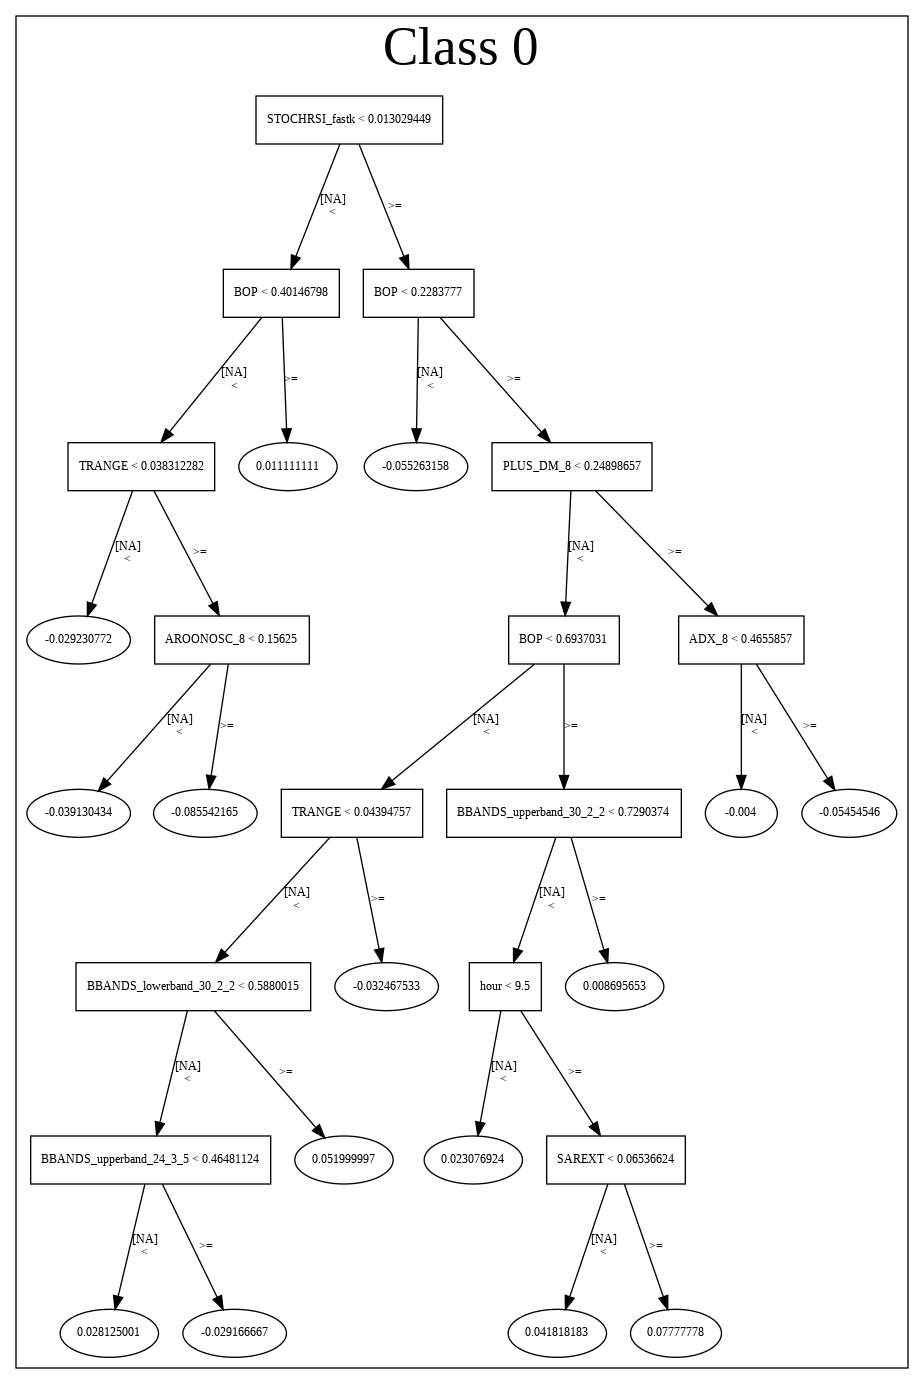

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_021425_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_021425_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'SUB',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'DIV',
 'TRANGE',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'WILLR_24',
 'ADOSC',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'Volume',
 'WILLR_20',
 'WILLR_12',
 'WILLR_8',
 'CDLTAKURI',
 'WILLR_14',
 'CDLMARUBOZU',
 'CDLENGULFING']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_022258_model_1  0.777108  0.572647              0.307174  0.44114  0.194604

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.701301           1.000000    0.185686
1   CDLCLOSINGMARUBOZU             0.445634           0.635439    0.117992
2                 hour             0.293706           0.418802    0.077766
3         STOCHF_fastk             0.257728           0.367500    0.068240
4          CDLMARUBOZU             0.248398           0.354196    0.065769
5       STOCHRSI_fastk             0.186267           0.265602    0.049319
6     CDLDRAGONFLYDOJI             0.182457           0.260170    0.048310
7                  SUB             0.172770           0.246356    0.045745
8        CDLHANGINGMAN             0.157479           0.224552    0.041696
9              WILLR_8             0.155145           0.221225    0.041078
10         CDLBELTHOLD             0.147320           0.210066    0.039006
11              TRANGE             0.142586           0.203316    0.037753
12            WILLR_12             0.132355           0.188728    0.035044
13         CDLLONGLINE             0.113659           0.162069    0.030094
14            WILLR_24             0.106208           0.151444    0.028121
15           CDLTAKURI             0.063458           0.090486    0.016802
16                 DIV             0.061802           0.088124    0.016363
17              Volume             0.052502           0.074863    0.013901
18              ULTOSC             0.036337           0.051814    0.009621
19        CDLENGULFING             0.031454           0.044850    0.008328
20               ADOSC             0.030504           0.043496    0.008077
21            WILLR_14             0.025420           0.036246    0.006730
22        CDLSHORTLINE             0.023746           0.033860    0.006287
23            WILLR_20             0.008580           0.012234    0.002272

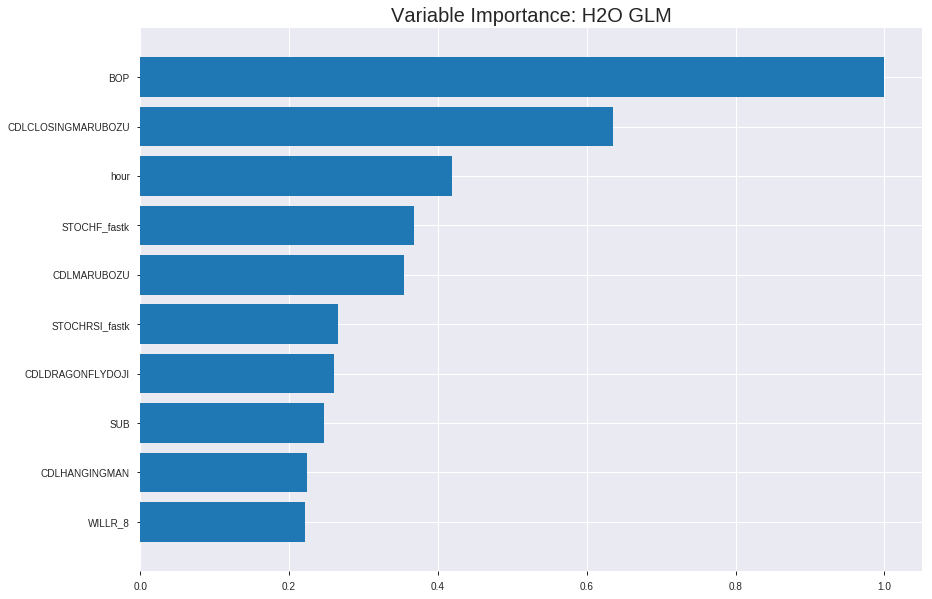

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_022258_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1966250178534185
RMSE: 0.44342419628772906
LogLoss: 0.575071802856406
Null degrees of freedom: 1349
Residual degrees of freedom: 1325
Null deviance: 1867.8661296847088
Residual deviance: 1552.6938677122962
AIC: 1602.6938677122962
AUC: 0.7647260123239437
pr_auc: 0.7335242541068892
Gini: 0.5294520246478873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33267041136361664: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      315  395  0.5563   (395.0/710.0)
1      73   567  0.1141   (73.0/640.0)
Total  388  962  0.3467   (468.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33267      0.707865  271
max f2                       0.241814     0.840756  317
max f0point5                 0.490426     0.682813  192
max accuracy                 0.490426     0.699259  192
max precision                0.976879     1         0
max recall                   0.0507262    1         390
max specificity              0.976879     1         0
max absolute_mcc             0.490426     0.396897  192
max min_per_class_accuracy   0.47827      0.692958  198
max mean_per_class_accuracy  0.490426     0.698449  192

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.933961           1.95871   1.95871            0.928571         0.95442   0.928571                    0.95442             0.0203125       0.0203125                  95.8705   95.8705
    2        0.02                        0.906143           1.78486   1.875              0.846154         0.918646  0.888889                    0.937196            0.0171875       0.0375                     78.4856   87.5
    3        0.0303704                   0.874521           1.80804   1.85213            0.857143         0.888212  0.878049                    0.920469            0.01875         0.05625                    80.8036   85.2134
    4        0.04                        0.847576           2.10938   1.91406            1                0.86167   0.907407                    0.906314            0.0203125       0.0765625                  110.938   91.4062
    5        0.0503704                   0.834092           1.35603   1.79917            0.642857         0.839002  0.852941                    0.892456            0.0140625       0.090625                   35.6027   79.9173
    6        0.1                         0.779231           1.88899   1.84375            0.895522         0.805117  0.874074                    0.84911             0.09375         0.184375                   88.8993   84.375
    7        0.15037                     0.721109           1.55101   1.74569            0.735294         0.752871  0.827586                    0.816872            0.078125        0.2625                     55.1011   74.569
    8        0.2                         0.671322           1.41674   1.66406            0.671642         0.693846  0.788889                    0.786343            0.0703125       0.332813                   41.6744   66.4062
    9        0.3                         0.607318           1.32812   1.55208            0.62963          0.638515  0.735802                    0.737067            0.132812        0.465625                   32.8125   55.2083
    10       0.4                         0.537057           1.23437   1.47266            0.585185         0.571234  0.698148                    0.695609            0.123438        0.589063                   23.4375   47.2656
    11       0.5                         0.471519           1.125     1.40312            0.533333         0.504347  0.665185                    0.657356            0.1125          0.701562                   12.5      40.3125
    12       0.6                         0.406179           0.96875   1.33073            0.459259         0.438266  0.630864                    0.620841            0.096875        0.798438                   -3.125    33.0729
    13       0.7                         0.339016           0.765625  1.25               0.362963         0.37112   0.592593                    0.585167            0.0765625       0.875                      -23.4375  25
    14       0.8                         0.275131           0.625     1.17188            0.296296         0.308373  0.555556                    0.550568            0.0625          0.9375                     -37.5     17.1875
    15       0.9                         0.172559           0.46875   1.09375            0.222222         0.232063  0.518519                    0.515178            0.046875        0.984375                   -53.125   9.375
    16       1                           0.00751188         0.15625   1                  0.0740741        0.104136  0.474074                    0.474074            0.015625 



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.198587359687959
RMSE: 0.44563141685473545
LogLoss: 0.5752777297655013
Null degrees of freedom: 385
Residual degrees of freedom: 361
Null deviance: 532.8273288418734
Residual deviance: 444.1144073789669
AIC: 494.1144073789669
AUC: 0.7543589327710648
pr_auc: 0.723047718200649
Gini: 0.5087178655421296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41379173445743833: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  89   0.4258   (89.0/209.0)
1      36   141  0.2034   (36.0/177.0)
Total  156  230  0.3238   (125.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413792     0.692875  229
max f2                       0.222548     0.835749  326
max f0point5                 0.557432     0.691114  132
max accuracy                 0.557432     0.704663  132
max precision                0.966263     1         0
max recall                   0.158556     1         352
max specificity              0.966263     1         0
max absolute_mcc             0.557432     0.404944  132
max min_per_class_accuracy   0.464889     0.679426  187
max mean_per_class_accuracy  0.557432     0.693104  132

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 45.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.934135           2.18079    2.18079            1                0.947661   1                           0.947661            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.905964           2.18079    2.18079            1                0.924529   1                           0.936095            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.895226           2.18079    2.18079            1                0.899533   1                           0.923908            0.0225989       0.0677966                  118.079   118.079
    4        0.0414508                   0.867467           1.63559    2.04449            0.75             0.878363   0.9375                      0.912522            0.0169492       0.0847458                  63.5593   104.449
    5        0.0518135                   0.835619           2.18079    2.07175            1                0.850893   0.95                        0.900196            0.0225989       0.107345                   118.079   107.175
    6        0.101036                    0.761021           1.6069     1.84528            0.736842         0.797279   0.846154                    0.850057            0.079096        0.186441                   60.6899   84.5285
    7        0.150259                    0.699338           1.72168    1.80479            0.789474         0.729075   0.827586                    0.810425            0.0847458       0.271186                   72.1677   80.4793
    8        0.202073                    0.633979           1.30847    1.67753            0.6              0.665058   0.769231                    0.773151            0.0677966       0.338983                   30.8475   67.7532
    9        0.300518                    0.581191           1.54951    1.63559            0.710526         0.608506   0.75                        0.719216            0.152542        0.491525                   54.9509   63.5593
    10       0.401554                    0.526575           1.06244    1.49138            0.487179         0.551276   0.683871                    0.67696             0.107345        0.59887                    6.24366   49.138
    11       0.5                         0.454191           0.975617   1.38983            0.447368         0.485714   0.637306                    0.639305            0.0960452       0.694915                   -2.4383   38.9831
    12       0.601036                    0.404982           1.00652    1.32539            0.461538         0.433839   0.607759                    0.604766            0.101695        0.79661                    0.65189   32.5395
    13       0.699482                    0.319449           0.401725   1.1954             0.184211         0.357781   0.548148                    0.570005            0.039548        0.836158                   -59.8275  19.5397
    14       0.800518                    0.264156           0.838766   1.15038            0.384615         0.293542   0.527508                    0.535111            0.0847458       0.920904                   -16.1234  15.0385
    15       0.898964                    0.174646           0.74606    1.10611            0.342105         0.218181   0.507205                    0.500404            0.0734463       0.99435                    -25.394   10.6107
    16       1                           0.00494356         0.0559177  1                  0.025641         0.0999198  0.458549  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-06 02:22:58  0.000 sec   2            .17E2     25            1.36505057377791    1.3626540009990376
     2019-09-06 02:22:58  0.006 sec   4            .11E2     25            1.3555638589984493  1.3535302724953655
     2019-09-06 02:22:58  0.010 sec   6            .67E1     25            1.342463208186101   1.3408547846055179
     2019-09-06 02:22:58  0.017 sec   8            .42E1     25            1.3255349060617874  1.3243224777898965
     2019-09-06 02:22:58  0.030 sec   10           .26E1     25            1.3052304910941779  1.3042279020346295
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-06 02:22:58  0.093 sec   36           .53E-2    25            1.148971484241736   1.1512219166704225
     2019-09-06 02:22:58  0.098 sec   38           .33E-2    25            1.14827953345565    1.1522364068253272
     2019-09-06 02:22:58  0.101 sec   39           .2E-2     25            1.1478396409220886  1.1533579755886687
     2019-09-06 02:22:58  0.104 sec   40           .13E-2    25            1.1475172571726515  1.1544716318400439
     2019-09-06 02:22:58  0.107 sec   41           .79E-3    25            1.1472482456774704  1.155584512532932


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7305699481865285)

('F1', 0.6923076923076923)

('auc', 0.7771084337349398)

('logloss', 0.5726469454810796)

('mean_per_class_error', 0.2867469879518072)

('rmse', 0.44113951951307945)

('mse', 0.1946040756762306)

glm prediction progress: |████████████████████████████████████████████████| 100%


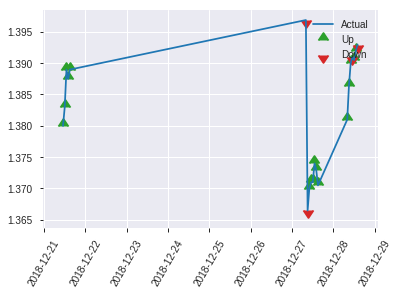


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1946040756762306
RMSE: 0.44113951951307945
LogLoss: 0.5726469454810796
Null degrees of freedom: 192
Residual degrees of freedom: 168
Null deviance: 265.27189969043866
Residual deviance: 221.04172095569675
AIC: 271.04172095569675
AUC: 0.7771084337349398
pr_auc: 0.6858522122192064
Gini: 0.5542168674698795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42014200421409603: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   53   0.4818   (53.0/110.0)
1      11   72   0.1325   (11.0/83.0)
Total  68   125  0.3316   (64.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420142     0.692308  124
max f2                       0.219001     0.82505   170
max f0point5                 0.633221     0.706714  49
max accuracy                 0.602327     0.73057   62
max precision                0.873497     0.857143  6
max recall                   0.219001     1         170
max specificity              0.936159     0.990909  0
max absolute_mcc             0.602327     0.444304  62
max min_per_class_accuracy   0.510644     0.686747  88
max mean_per_class_accuracy  0.55219      0.713253  73

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.919929           1.16265   1.16265            0.5              0.92807   0.5                         0.92807             0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.906514           2.3253    1.74398            1                0.916459  0.75                        0.922264            0.0240964       0.0361446                  132.53    74.3976
    3        0.0310881                   0.880694           2.3253    1.93775            1                0.904381  0.833333                    0.916303            0.0240964       0.060241                   132.53    93.7751
    4        0.0414508                   0.85583            1.16265   1.74398            0.5              0.872144  0.75                        0.905263            0.0120482       0.0722892                  16.2651   74.3976
    5        0.0518135                   0.846461           2.3253    1.86024            1                0.847792  0.8                         0.893769            0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.77161            1.39518   1.62771            0.6              0.814466  0.7                         0.854117            0.0722892       0.168675                   39.5181   62.7711
    7        0.150259                    0.718898           2.06693   1.76402            0.888889         0.7373    0.758621                    0.817864            0.0963855       0.26506                    106.693   76.4022
    8        0.202073                    0.6607             2.3253    1.90794            1                0.691466  0.820513                    0.785454            0.120482        0.385542                   132.53    90.7939
    9        0.300518                    0.609833           1.34623   1.72393            0.578947         0.636242  0.741379                    0.736574            0.13253         0.518072                   34.6227   72.393
    10       0.398964                    0.541139           1.10146   1.57033            0.473684         0.581705  0.675325                    0.69836             0.108434        0.626506                   10.1458   57.0333
    11       0.502591                    0.493749           0.813855  1.41436            0.35             0.516299  0.608247                    0.660822            0.0843373       0.710843                   -18.6145  41.4358
    12       0.601036                    0.435611           0.979074  1.34306            0.421053         0.464634  0.577586                    0.628687            0.0963855       0.807229                   -2.09258  34.3062
    13       0.699482                    0.393221           0.979074  1.29183            0.421053         0.418265  0.555556                    0.599072            0.0963855       0.903614                   -2.09258  29.1834
    14       0.797927                    0.303436           0.367153  1.17775            0.157895         0.344888  0.506494                    0.567712            0.0361446       0.939759                   -63.2847  17.775
    15       0.896373                    0.192265           0.611921  1.11561            0.263158         0.256817  0.479769                    0.533567            0.060241        1                          -38.8079  11.5607
    16       1                           0.0261838          0         1                  0                0.120233  0.430052                    0.490735           

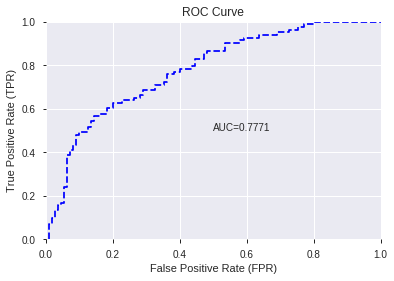

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


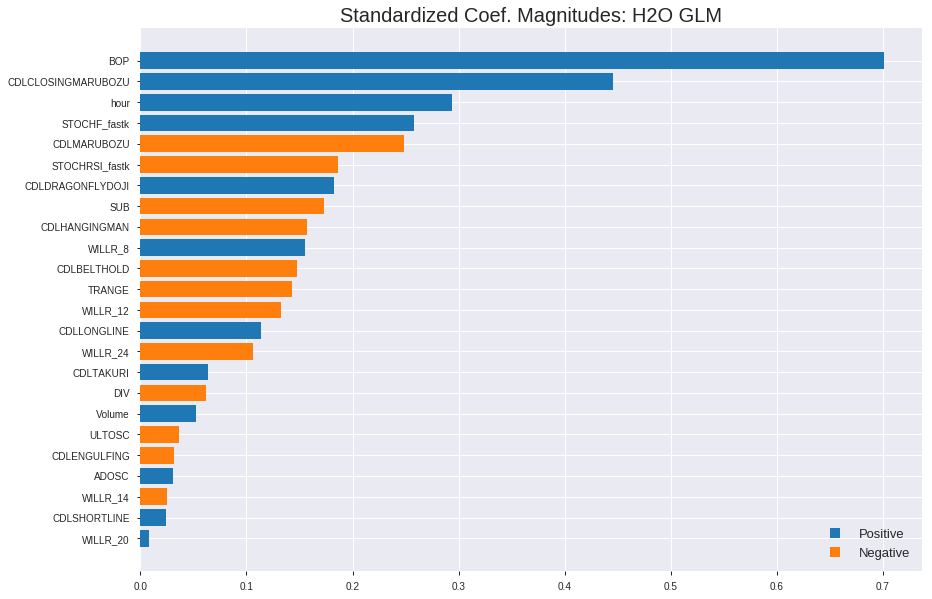

'log_likelihood'
--2019-09-06 02:23:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


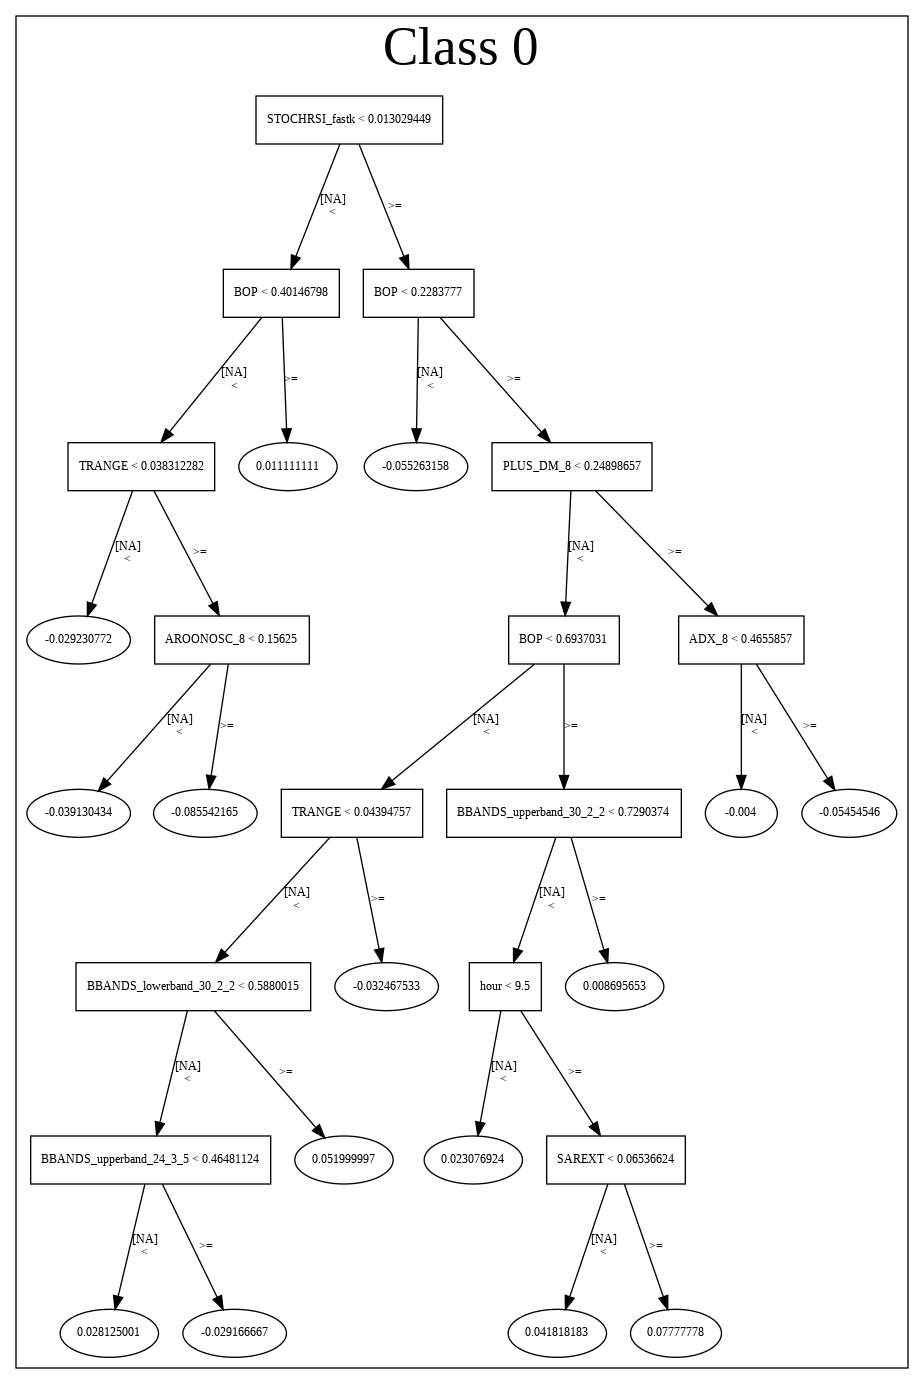

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_022258_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_022258_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLHANGINGMAN',
 'WILLR_8',
 'CDLBELTHOLD',
 'TRANGE',
 'WILLR_12',
 'CDLLONGLINE',
 'WILLR_24',
 'CDLTAKURI',
 'DIV',
 'Volume',
 'ULTOSC',
 'CDLENGULFING',
 'ADOSC',
 'WILLR_14',
 'CDLSHORTLINE',
 'WILLR_20']

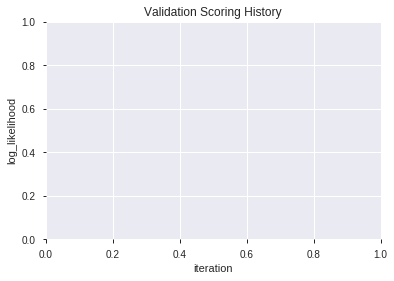

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_022323_model_7  0.754326  0.589706              0.281161  0.450670  0.203104
1               XGBoost_2_AutoML_20190906_022323  0.752574  0.593399              0.314677  0.451612  0.203953
2  XGBoost_grid_1_AutoML_20190906_022323_model_4  0.747974  0.589522              0.334666  0.450183  0.202665
3  XGBoost_grid_1_AutoML_20190906_022323_model_6  0.747974  0.594158              0.337514  0.452883  0.205103
4  XGBoost_grid_1_AutoML_20190906_022323_model_2  0.744469  0.596165              0.309912  0.454000  0.206116
5  XGBoost_grid_1_AutoML_20190906_022323_model_1  0.741840  0.602635              0.299233  0.456704  0.208579
6               XGBoost_3_AutoML_20190906_022323  0.738992  0.598106              0.302410  0.455421  0.207409
7  XGBoost_grid_1_AutoML_20190906_022323_model_3  0.735159  0.603503              0.323768  0.457145  0.208982
8               XGBoost_1_AutoML_20190906_022323  0.726506  0.609668              0.325465  0.460715  0.212258
9  XGBoost_grid_1_AutoML_20190906_022323_model_5  0.701424  0.643154              0.358872  0.475220  0.225834

variable  relative_importance  scaled_importance  percentage
0                  BOP          1502.041382           1.000000    0.214778
1         STOCHF_fastk           556.691528           0.370623    0.079602
2               TRANGE           512.155090           0.340973    0.073234
3                 hour           441.053497           0.293636    0.063067
4                ADOSC           395.085449           0.263032    0.056494
5                  DIV           384.550415           0.256019    0.054987
6             WILLR_24           356.606049           0.237414    0.050991
7               Volume           355.996460           0.237008    0.050904
8               ULTOSC           330.919128           0.220313    0.047318
9              WILLR_8           327.389374           0.217963    0.046814
10            WILLR_14           317.820374           0.211592    0.045445
11                 SUB           295.411835           0.196674    0.042241
12            WILLR_20           294.276886           0.195918    0.042079
13            WILLR_12           291.759155           0.194242    0.041719
14      STOCHRSI_fastk           256.459198           0.170740    0.036671
15  CDLCLOSINGMARUBOZU           121.359734           0.080797    0.017353
16         CDLBELTHOLD            84.834663           0.056480    0.012131
17        CDLSHORTLINE            60.742931           0.040440    0.008686
18    CDLDRAGONFLYDOJI            58.991844           0.039274    0.008435
19         CDLLONGLINE            22.594837           0.015043    0.003231
20           CDLTAKURI            20.144104           0.013411    0.002880
21        CDLENGULFING             4.365874           0.002907    0.000624
22         CDLMARUBOZU             2.202460           0.001466    0.000315

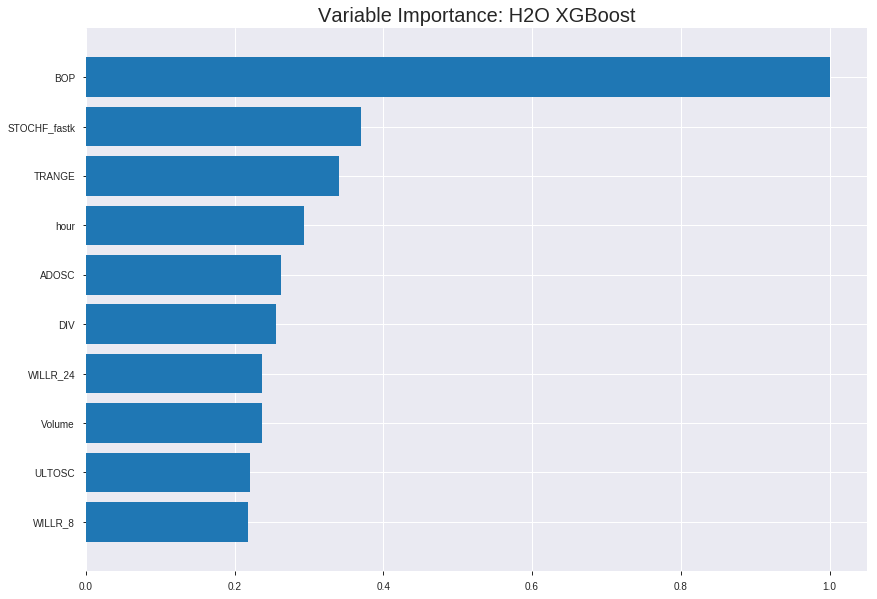

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_022323_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12849492475021393
RMSE: 0.3584618874444171
LogLoss: 0.4206108357481693
Mean Per-Class Error: 0.14428917253521123
AUC: 0.9300253080985915
pr_auc: 0.9236304464243723
Gini: 0.860050616197183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46946185401507784: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      575  135  0.1901   (135.0/710.0)
1      63   577  0.0984   (63.0/640.0)
Total  638  712  0.1467   (198.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469462     0.85355   206
max f2                       0.420268     0.896283  227
max f0point5                 0.584238     0.876458  150
max accuracy                 0.536431     0.856296  173
max precision                0.908359     1         0
max recall                   0.122855     1         365
max specificity              0.908359     1         0
max absolute_mcc             0.536431     0.712041  173
max min_per_class_accuracy   0.504364     0.849296  188
max mean_per_class_accuracy  0.469462     0.855711  206

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.884586           2.10938   2.10938            1                0.89649    1                           0.89649             0.021875        0.021875                   110.938   110.938
    2        0.02                        0.864657           2.10938   2.10938            1                0.875127   1                           0.886204            0.0203125       0.0421875                  110.938   110.938
    3        0.0303704                   0.852367           2.10938   2.10938            1                0.860089   1                           0.877287            0.021875        0.0640625                  110.938   110.938
    4        0.04                        0.83755            2.10938   2.10938            1                0.845534   1                           0.869642            0.0203125       0.084375                   110.938   110.938
    5        0.0503704                   0.827357           2.10938   2.10938            1                0.832831   1                           0.862064            0.021875        0.10625                    110.938   110.938
    6        0.1                         0.787385           2.04641   2.07812            0.970149         0.808587   0.985185                    0.835524            0.101562        0.207813                   104.641   107.812
    7        0.15037                     0.754015           2.10938   2.08859            1                0.769362   0.990148                    0.813361            0.10625         0.314063                   110.938   108.859
    8        0.2                         0.719202           1.92048   2.04688            0.910448         0.736493   0.97037                     0.794286            0.0953125       0.409375                   92.0476   104.688
    9        0.3                         0.653688           1.84375   1.97917            0.874074         0.685681   0.938272                    0.758085            0.184375        0.59375                    84.375    97.9167
    10       0.4                         0.57447            1.67188   1.90234            0.792593         0.61884    0.901852                    0.723273            0.167187        0.760938                   67.1875   90.2344
    11       0.5                         0.488377           1.10938   1.74375            0.525926         0.532232   0.826667                    0.685065            0.110937        0.871875                   10.9375   74.375
    12       0.6                         0.397031           0.671875  1.5651             0.318519         0.44374    0.741975                    0.644844            0.0671875       0.939063                   -32.8125  56.5104
    13       0.7                         0.313453           0.3125    1.38616            0.148148         0.353719   0.657143                    0.603255            0.03125         0.970313                   -68.75    38.6161
    14       0.8                         0.216985           0.1875    1.23633            0.0888889        0.26381    0.586111                    0.560824            0.01875         0.989062                   -81.25    23.6328
    15       0.9                         0.128903           0.09375   1.10938            0.0444444        0.173552   0.525926                    0.517794            0.009375        0.998437                   -90.625   10.9375
    16       1                           0.0485373          0.015625  1                  0.00740741       0.0926265  0.474074                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20025992113910018
RMSE: 0.44750410181259814
LogLoss: 0.5848365793785786
Mean Per-Class Error: 0.31092368826534744
AUC: 0.7556024112669965
pr_auc: 0.7177690644879438
Gini: 0.5112048225339929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3333303928375244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  106  0.5072   (106.0/209.0)
1      23   154  0.1299   (23.0/177.0)
Total  126  260  0.3342   (129.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33333      0.704805  259
max f2                       0.170547     0.832527  324
max f0point5                 0.661831     0.663176  98
max accuracy                 0.536765     0.689119  172
max precision                0.911438     1         0
max recall                   0.0537546    1         385
max specificity              0.911438     1         0
max absolute_mcc             0.400256     0.386104  234
max min_per_class_accuracy   0.519646     0.672316  185
max mean_per_class_accuracy  0.400256     0.689076  234

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.863812           2.18079   2.18079            1                0.895306   1                           0.895306            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.834167           2.18079   2.18079            1                0.852996   1                           0.874151            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.819026           1.63559   1.99906            0.75             0.826271   0.916667                    0.858191            0.0169492       0.0621469                  63.5593   99.9058
    4        0.0414508                   0.808622           2.18079   2.04449            1                0.814635   0.9375                      0.847302            0.0225989       0.0847458                  118.079   104.449
    5        0.0518135                   0.800853           1.0904    1.85367            0.5              0.804635   0.85                        0.838769            0.0112994       0.0960452                  9.03955   85.3672
    6        0.101036                    0.753342           1.72168   1.78937            0.789474         0.775089   0.820513                    0.807745            0.0847458       0.180791                   72.1677   78.9367
    7        0.150259                    0.720263           1.83646   1.80479            0.842105         0.736536   0.827586                    0.784418            0.0903955       0.271186                   83.6456   80.4793
    8        0.202073                    0.69024            1.52655   1.73345            0.7              0.705099   0.794872                    0.76408             0.079096        0.350282                   52.6554   73.3449
    9        0.300518                    0.641639           1.20517   1.56039            0.552632         0.665935   0.715517                    0.731929            0.118644        0.468927                   20.5174   56.0394
    10       0.401554                    0.580204           1.11835   1.44917            0.512821         0.609326   0.664516                    0.70108             0.112994        0.581921                   11.8354   44.9171
    11       0.5                         0.497351           1.20517   1.40113            0.552632         0.538267   0.642487                    0.669024            0.118644        0.700565                   20.5174   40.113
    12       0.601036                    0.406414           1.00652   1.33479            0.461538         0.448135   0.612069                    0.631892            0.101695        0.80226                    0.65189   33.4794
    13       0.699482                    0.306209           0.74606   1.25194            0.342105         0.359237   0.574074                    0.593518            0.0734463       0.875706                   -25.394   25.1936
    14       0.800518                    0.19995            0.615095  1.17156            0.282051         0.261199   0.537217                    0.551575            0.0621469       0.937853                   -38.4905  17.1558
    15       0.898964                    0.126259           0.401725  1.08725            0.184211         0.1603     0.498559                    0.508726            0.039548        0.977401                   -59.8275  8.72531
    16       1                           0.0537546          0.223671  1                  0.102564         0.0949508  0.458549                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:23:32  5.477 sec   0                  0.5              0.693147            0.5             0                  1                0.525926                         0.5                0.693147              0.5               0                    1                  0.541451
    2019-09-06 02:23:32  5.542 sec   5                  0.471278         0.636943            0.844474        0.819658           2.10938          0.234815                         0.481616           0.656772              0.722623          0.668436             2.18079            0.354922
    2019-09-06 02:23:32  5.608 sec   10                 0.4495           0.595147            0.860873        0.841462           2.10938          0.234074                         0.468509           0.630701              0.739099          0.692415             2.18079            0.38342
    2019-09-06 02:23:32  5.667 sec   15                 0.432437         0.562503            0.873236        0.856076           2.10938          0.215556                         0.460918           0.61513               0.745425          0.697059             2.18079            0.321244
    2019-09-06 02:23:32  5.723 sec   20                 0.418804         0.536086            0.883639        0.867793           2.10938          0.203704                         0.456124           0.604665              0.746141          0.692443             2.18079            0.365285
    2019-09-06 02:23:32  5.779 sec   25                 0.40785          0.514521            0.889259        0.874278           2.10938          0.186667                         0.452508           0.596512              0.74806           0.699485             2.18079            0.360104
    2019-09-06 02:23:32  5.824 sec   30                 0.398842         0.496999            0.894473        0.879498           2.10938          0.186667                         0.450764           0.592412              0.748439          0.699557             2.18079            0.318653
    2019-09-06 02:23:32  5.877 sec   35                 0.390046         0.479963            0.902745        0.890172           2.10938          0.191852                         0.449372           0.589382              0.751899          0.703574             2.18079            0.336788
    2019-09-06 02:23:32  5.927 sec   40                 0.38382          0.468023            0.908415        0.894581           2.10938          0.175556                         0.449543           0.588996              0.750412          0.70458              2.18079            0.339378
    2019-09-06 02:23:32  5.991 sec   45                 0.377049         0.455098            0.914608        0.906637           2.10938          0.174815                         0.448006           0.585863              0.755386          0.714922             2.18079            0.34456
    2019-09-06 02:23:32  6.044 sec   50                 0.370489         0.442554            0.919308        0.908549           2.10938          0.16                             0.448344           0.586168              0.753629          0.717169             2.18079            0.34456
    2019-09-06 02:23:32  6.097 sec   55                 0.364396         0.43123             0.924554        0.912292           2.10938          0.155556                         0.446281           0.581844              0.759144          0.72

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ---------------------
BOP               1502.0413818359375     1.0                    0.21477824173938942
STOCHF_fastk      556.6915283203125      0.3706232964366609     0.07960181995632255
TRANGE            512.1550903320312      0.3409726899175219     0.07323351482163538
hour              441.0534973144531      0.2936360493446297     0.06306663438954016
ADOSC             395.08544921875        0.2630323331943352     0.05649362204408855
---               ---                    ---                    ---
CDLDRAGONFLYDOJI  58.991844177246094     0.03927444669010428    0.00843529660538798
CDLLONGLINE       22.594837188720703     0.01504275279094052    0.003230855995358498
CDLTAKURI         20.14410400390625      0.013411151149034399   0.0028804234634908004
CDLENGULFING      4.365874290466309      0.0029066271697054864  0.0006242802729012821
CDLMARUBOZU       2.2024598121643066     0.0014663110076716071  0.0003149317000708201


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.6989247311827956)

('auc', 0.7543263964950713)

('logloss', 0.5897064435951614)

('mean_per_class_error', 0.2811610076670318)

('rmse', 0.4506700594361468)

('mse', 0.20310350247218006)

xgboost prediction progress: |████████████████████████████████████████████| 100%


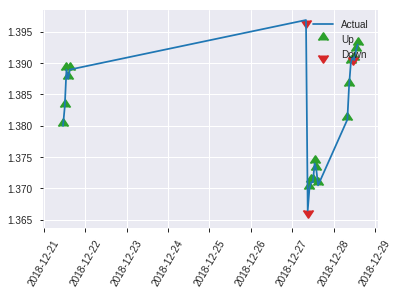


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20310350247218006
RMSE: 0.4506700594361468
LogLoss: 0.5897064435951614
Mean Per-Class Error: 0.2811610076670318
AUC: 0.7543263964950713
pr_auc: 0.6388123931416337
Gini: 0.5086527929901425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5090838670730591: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   38   0.3455   (38.0/110.0)
1      18   65   0.2169   (18.0/83.0)
Total  90   103  0.2902   (56.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509084     0.698925  102
max f2                       0.170951     0.820158  173
max f0point5                 0.586238     0.670886  77
max accuracy                 0.586238     0.715026  77
max precision                0.918564     1         0
max recall                   0.170951     1         173
max specificity              0.918564     1         0
max absolute_mcc             0.509084     0.43436   102
max min_per_class_accuracy   0.541876     0.690909  91
max mean_per_class_accuracy  0.509084     0.718839  102

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 49.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.865481           1.16265   1.16265            0.5              0.897857  0.5                         0.897857            0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.857896           1.16265   1.16265            0.5              0.862951  0.5                         0.880404            0.0120482       0.0240964                  16.2651   16.2651
    3        0.0310881                   0.830812           2.3253    1.5502             1                0.855417  0.666667                    0.872075            0.0240964       0.0481928                  132.53    55.0201
    4        0.0414508                   0.812523           2.3253    1.74398            1                0.820448  0.75                        0.859168            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.805353           1.16265   1.62771            0.5              0.809857  0.7                         0.849306            0.0120482       0.0843373                  16.2651   62.7711
    6        0.103627                    0.76325            1.62771   1.62771            0.7              0.784019  0.7                         0.816663            0.0843373       0.168675                   62.7711   62.7711
    7        0.150259                    0.72073            1.80857   1.68384            0.777778         0.739802  0.724138                    0.792809            0.0843373       0.253012                   80.8568   68.3839
    8        0.202073                    0.683292           1.39518   1.60982            0.6              0.704702  0.692308                    0.770218            0.0722892       0.325301                   39.5181   60.9824
    9        0.300518                    0.622066           1.34623   1.52347            0.578947         0.656434  0.655172                    0.732944            0.13253         0.457831                   34.6227   52.3473
    10       0.398964                    0.586925           1.71338   1.57033            0.736842         0.608663  0.675325                    0.702277            0.168675        0.626506                   71.338    57.0333
    11       0.502591                    0.525278           1.04639   1.4623             0.45             0.554314  0.628866                    0.671769            0.108434        0.73494                    4.63855   46.2303
    12       0.601036                    0.461275           0.85669   1.36311            0.368421         0.493468  0.586207                    0.642565            0.0843373       0.819277                   -14.331   36.3108
    13       0.699482                    0.377867           0.489537  1.24016            0.210526         0.428814  0.533333                    0.612481            0.0481928       0.86747                    -51.0463  24.0161
    14       0.797927                    0.250399           0.734306  1.17775            0.315789         0.312232  0.506494                    0.575438            0.0722892       0.939759                   -26.5694  17.775
    15       0.896373                    0.171306           0.489537  1.10217            0.210526         0.20842   0.473988                    0.535129            0.0481928       0.987952                   -51.0463  10.2166
    16       1                           0.0664191          0.116265  1                  0.05             0.10489   0.430052                    0.490545          

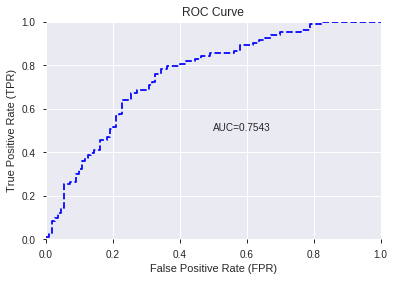

This function is available for GLM models only


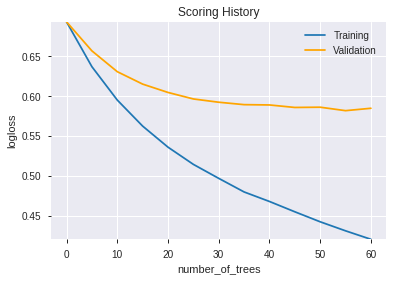

--2019-09-06 02:23:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

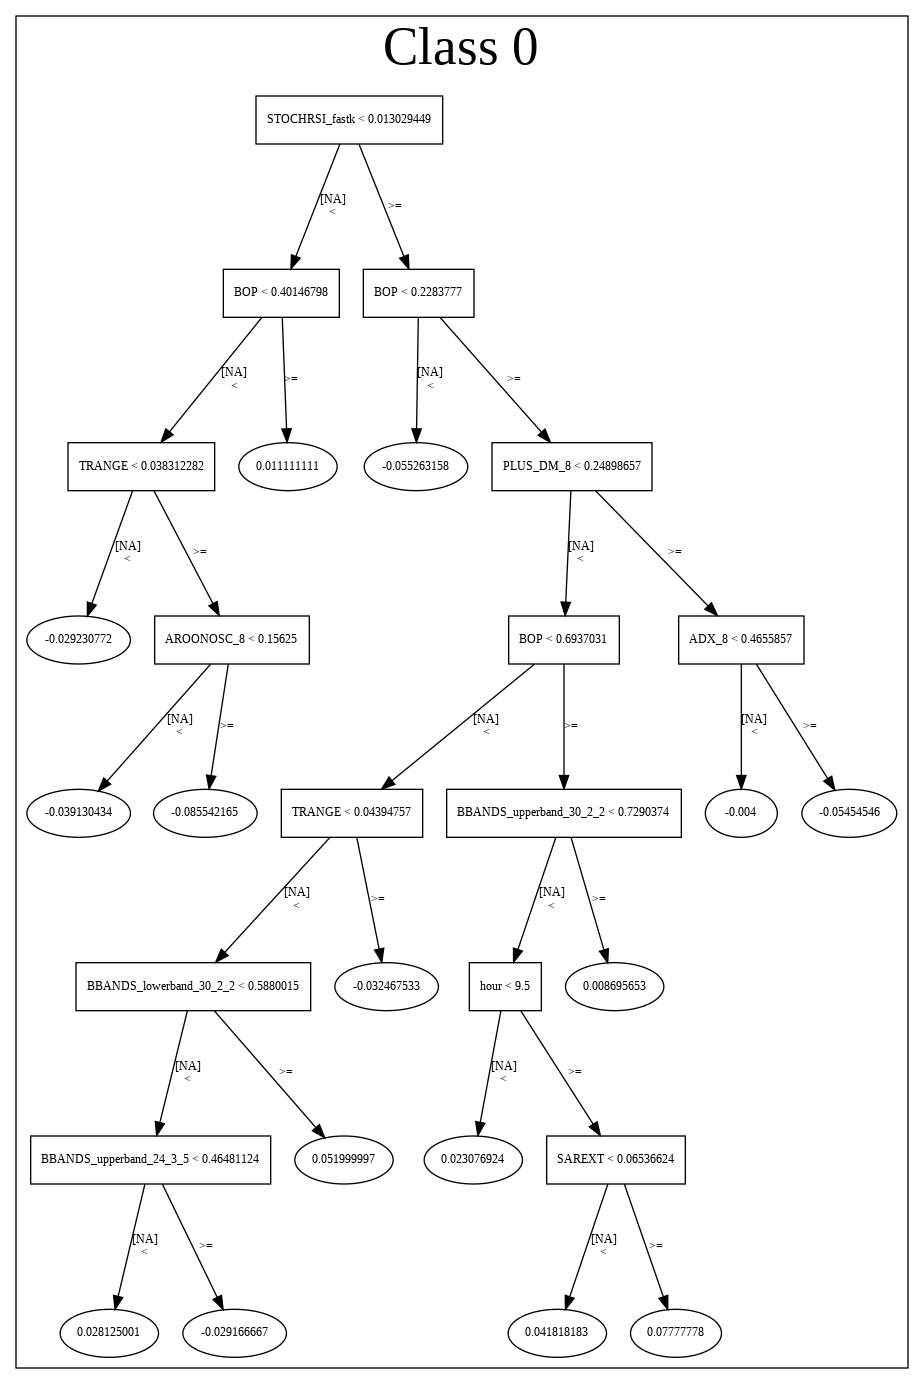

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_022323_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_022323_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'hour',
 'ADOSC',
 'DIV',
 'WILLR_24',
 'Volume',
 'ULTOSC',
 'WILLR_8',
 'WILLR_14',
 'SUB',
 'WILLR_20',
 'WILLR_12',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLENGULFING',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

149

['BBANDS_upperband_20_2_4',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'MAVP_20_3',
 'BBANDS_middleband_20_3_2',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_middleband_20_3_5',
 'BBANDS_lowerband_20_3_5',
 'MAVP_20_5',
 'BBANDS_upperband_20_5_3',
 'BBANDS_middleband_20_5_4',
 'BBANDS_upperband_20_5_5',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_middleband_20_6_4',
 'MAVP_20_7',
 'BBANDS_middleband_20_7_3',
 'BBANDS_upperband_20_7_4',
 'BBANDS_middleband_20_7_5',
 'BBANDS_middleband_24_0_2',
 'BBANDS_upperband_24_0_4',
 'MA_24_1',
 'BBANDS_lowerband_24_1_2',
 'BBANDS_upperband_24_1_5',
 'BBANDS_middleband_24_2_2',
 'BBANDS_middleband_24_2_4',
 'BBANDS_middleband_24_2_5',
 'BBANDS_upperband_24_3_4',
 'BBANDS_upperband_24_5_2',
 'BBANDS_middleband_24_5_2',
 'BBANDS_middleband_24_5_4',
 'BBANDS_upperband_24_5_5',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_24_7_5',
 'MA_30_0',
 'BBANDS_middleband_30_2_4',
 'BBANDS_upperband_30_2_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_022440_model_7  0.749726  0.960264              0.254929  0.548146  0.300464
1  DeepLearning_grid_1_AutoML_20190906_022440_model_5  0.746331  0.741168              0.296057  0.514521  0.264732
2  DeepLearning_grid_1_AutoML_20190906_022440_model_8  0.742169  0.727221              0.277766  0.500945  0.250946
3  DeepLearning_grid_1_AutoML_20190906_022440_model_9  0.734502  0.644820              0.323549  0.472528  0.223282
4  DeepLearning_grid_1_AutoML_20190906_022440_model_3  0.713691  0.921886              0.396605  0.549099  0.301510
5  DeepLearning_grid_1_AutoML_20190906_022440_model_6  0.700657  0.650033              0.357065  0.477218  0.227737
6  DeepLearning_grid_1_AutoML_20190906_022440_model_2  0.689485  0.814766              0.341512  0.524846  0.275463
7               DeepLearning_1_AutoML_20190906_022440  0.681161  1.237771              0.361829  0.605276  0.366359
8  DeepLearning_grid_1_AutoML_20190906_022440_model_4  0.668565  1.049597              0.386254  0.554283  0.307229
9  DeepLearning_grid_1_AutoML_20190906_022440_model_1  0.668346  1.389655              0.372070  0.591251  0.349578

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.008564
1          CDLCLOSINGMARUBOZU             0.904233           0.904233    0.007744
2            CDLDRAGONFLYDOJI             0.875597           0.875597    0.007499
3                 CDLLONGLINE             0.867945           0.867945    0.007433
4                CDLSHORTLINE             0.862838           0.862838    0.007390
..                        ...                  ...                ...         ...
144               STOCH_slowk             0.741832           0.741832    0.006353
145                     DX_24             0.739143           0.739143    0.006330
146                    CMO_14             0.735693           0.735693    0.006301
147   BBANDS_lowerband_30_5_5             0.729431           0.729431    0.006247
148  BBANDS_middleband_24_5_4             0.728677           0.728677    0.006241

[149 rows x 4 columns]

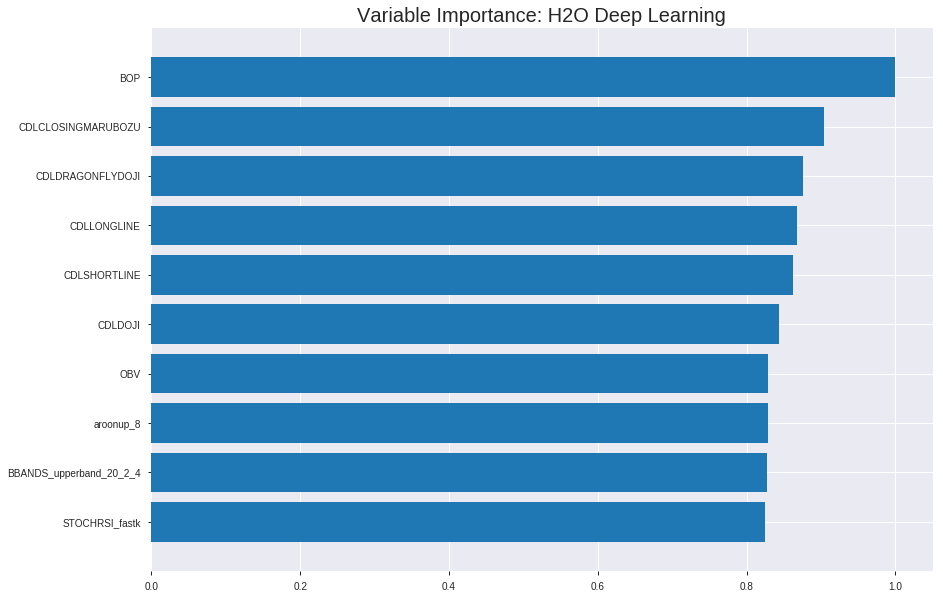

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_022440_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16064054314850565
RMSE: 0.4007998791772593
LogLoss: 0.48817397927062334
Mean Per-Class Error: 0.23080985915492958
AUC: 0.8483109595070423
pr_auc: 0.8236979971284467
Gini: 0.6966219190140845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26745718591171497: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      444  266  0.3746   (266.0/710.0)
1      75   565  0.1172   (75.0/640.0)
Total  519  831  0.2526   (341.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267457     0.768185  270
max f2                       0.0898943    0.852766  351
max f0point5                 0.534023     0.783745  165
max accuracy                 0.534023     0.774074  165
max precision                0.999464     1         0
max recall                   0.0243708    1         385
max specificity              0.999464     1         0
max absolute_mcc             0.534023     0.550692  165
max min_per_class_accuracy   0.41893      0.75      209
max mean_per_class_accuracy  0.534023     0.76919   165

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 45.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.998297           2.10938   2.10938            1                0.999058   1                           0.999058            0.021875        0.021875                   110.938   110.938
    2        0.02                        0.997549           2.10938   2.10938            1                0.997983   1                           0.99854             0.0203125       0.0421875                  110.938   110.938
    3        0.0303704                   0.993939           1.95871   2.05793            0.928571         0.99622    0.97561                     0.997748            0.0203125       0.0625                     95.8705   105.793
    4        0.04                        0.990601           2.10938   2.07031            1                0.992435   0.981481                    0.996469            0.0203125       0.0828125                  110.938   107.031
    5        0.0503704                   0.986352           2.10938   2.07835            1                0.98835    0.985294                    0.994797            0.021875        0.104688                   110.938   107.835
    6        0.1                         0.955659           1.88899   1.98438            0.895522         0.969869   0.940741                    0.982425            0.09375         0.198437                   88.8993   98.4375
    7        0.15037                     0.898311           1.83019   1.93273            0.867647         0.927734   0.916256                    0.964105            0.0921875       0.290625                   83.0193   93.2728
    8        0.2                         0.826586           1.70009   1.875              0.80597          0.861556   0.888889                    0.938658            0.084375        0.375                      70.0093   87.5
    9        0.3                         0.665845           1.64062   1.79688            0.777778         0.755477   0.851852                    0.877598            0.164062        0.539062                   64.0625   79.6875
    10       0.4                         0.521272           1.40625   1.69922            0.666667         0.592705   0.805556                    0.806374            0.140625        0.679688                   40.625    69.9219
    11       0.5                         0.40146            0.796875  1.51875            0.377778         0.456001   0.72                        0.7363              0.0796875       0.759375                   -20.3125  51.875
    12       0.6                         0.283339           1.04688   1.4401             0.496296         0.340042   0.682716                    0.670257            0.104688        0.864062                   4.6875    44.0104
    13       0.7                         0.200199           0.65625   1.32812            0.311111         0.238127   0.62963                     0.608524            0.065625        0.929688                   -34.375   32.8125
    14       0.8                         0.114999           0.359375  1.20703            0.17037          0.156212   0.572222                    0.551985            0.0359375       0.965625                   -64.0625  20.7031
    15       0.9                         0.0471928          0.28125   1.10417            0.133333         0.0800821  0.523457                    0.499551            0.028125        0.99375                    -71.875   10.4167
    16       1                           7.98727e-05        0.0625    1                  0.0296296        0.0209155  0.474074                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23386641760116156
RMSE: 0.48359737137536385
LogLoss: 0.6875290603721603
Mean Per-Class Error: 0.3441056416078718
AUC: 0.693212229340686
pr_auc: 0.663144609136664
Gini: 0.3864244586813721
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34773282114474513: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   116  0.555    (116.0/209.0)
1      33   144  0.1864   (33.0/177.0)
Total  126  260  0.386    (149.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347733     0.659039  259
max f2                       0.0290089    0.816421  375
max f0point5                 0.55102      0.630252  163
max accuracy                 0.55102      0.660622  163
max precision                0.999426     1         0
max recall                   0.0290089    1         375
max specificity              0.999426     1         0
max absolute_mcc             0.539381     0.313801  165
max min_per_class_accuracy   0.489452     0.645933  188
max mean_per_class_accuracy  0.539381     0.655894  165

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.994636           2.18079   2.18079            1                0.996774   1                           0.996774            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.992473           2.18079   2.18079            1                0.993633   1                           0.995204            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.987214           1.63559   1.99906            0.75             0.990123   0.916667                    0.99351             0.0169492       0.0621469                  63.5593   99.9058
    4        0.0414508                   0.982924           2.18079   2.04449            1                0.985283   0.9375                      0.991453            0.0225989       0.0847458                  118.079   104.449
    5        0.0518135                   0.977635           1.63559   1.96271            0.75             0.979648   0.9                         0.989092            0.0169492       0.101695                   63.5593   96.2712
    6        0.101036                    0.901916           1.49212   1.73345            0.684211         0.94399    0.794872                    0.967119            0.0734463       0.175141                   49.212    73.3449
    7        0.150259                    0.840132           1.37734   1.61679            0.631579         0.87857    0.741379                    0.938112            0.0677966       0.242938                   37.7342   61.6793
    8        0.202073                    0.762127           1.30847   1.53774            0.6              0.796946   0.705128                    0.901915            0.0677966       0.310734                   30.8475   53.7737
    9        0.300518                    0.66431            1.20517   1.42879            0.552632         0.713433   0.655172                    0.840171            0.118644        0.429379                   20.5174   42.8794
    10       0.401554                    0.572635           1.23019   1.37882            0.564103         0.620005   0.632258                    0.784775            0.124294        0.553672                   23.019    37.8823
    11       0.5                         0.473481           1.0904    1.32203            0.5              0.520483   0.606218                    0.732738            0.107345        0.661017                   9.03955   32.2034
    12       0.601036                    0.402678           0.782848  1.23139            0.358974         0.43825    0.564655                    0.683233            0.079096        0.740113                   -21.7152  23.1395
    13       0.699482                    0.322912           0.860839  1.17924            0.394737         0.36377    0.540741                    0.638272            0.0847458       0.824859                   -13.9161  17.9243
    14       0.800518                    0.237052           0.671013  1.1151             0.307692         0.279092   0.511327                    0.592938            0.0677966       0.892655                   -32.8987  11.5097
    15       0.898964                    0.125751           0.573892  1.05583            0.263158         0.171803   0.48415                     0.54682             0.0564972       0.949153                   -42.6108  5.58296
    16       1                           0.0010292          0.503259  1                  0.230769         0.0628981  0.458549                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:30:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:30:07  6.599 sec         205 obs/sec       0.805926  1             1088       0.55485          1.1192              -0.234753      0.697437        0.659606           1.95871          0.397778                         0.535016           0.936815              -0.15289         0.641229          0.603549             2.18079            0.432642
    2019-09-06 02:30:19  19.082 sec        325 obs/sec       3.98593   5             5381       0.497301         0.728919            0.00809948     0.782979        0.759409           2.10938          0.305185                         0.491496           0.695146              0.0270399        0.702511          0.678397             2.18079            0.417098
    2019-09-06 02:30:32  31.939 sec        381 obs/sec       7.97333   10            10764      0.4008           0.488174            0.355706       0.848311        0.823698           2.10938          0.252593                         0.483597           0.687529              0.0580607        0.693212          0.663145             2.18079            0.38601
    2019-09-06 02:30:44  44.386 sec        409 obs/sec       11.9741   15            16165      0.45395          0.630959            0.173495       0.885224        0.809432           2.10938          0.213333                         0.573459           1.02298               -0.324525        0.652421          0.620742             2.18079            0.468912
    2019-09-06 02:30:57  56.726 sec        425 obs/sec       15.9459   20            21527      0.340771         0.368347            0.534249       0.918117        0.860189           2.10938          0.154815                         0.553524           1.0137                -0.234037        0.661152          0.630101             1.63559            0.455959
    2019-09-06 02:31:09  1 min  8.921 sec  436 obs/sec       19.877    25            26834      0.328593         0.34465             0.566942       0.940931        0.81426            2.10938          0.133333                         0.553814           1.05988               -0.235328        0.693915          0.651569             1.63559            0.445596
    2019-09-06 02:31:10  1 min 10.150 sec  435 obs/sec       19.877    25            26834      0.4008           0.488174            0.355706       0.848311        0.823698           2.10938          0.252593                         0.483597           0.687529              0.0580607        0.693212          0.663145             2.18079            0.38601

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.008564309345302841
CDLCLOSINGMARUBOZU        0.9042325615882874     0.9042325615882874   0.0077441273775376955
CDLDRAGONFLYDOJI          0.8755967617034912     0.8755967617034912   0.007498881528974114
CDLLONGLINE               0.8679451942443848     0.8679451942443848   0.007433351138277874
CDLSHORTLINE              0.8628382086753845     0.8628382086753845   0.007389613334042958
---                       ---                    ---                  ---
STOCH_slowk               0.7418322563171387     0.7418322563171387   0.006353280925423963
DX_24                     0.7391433119773865     0.7391433119773865   0.0063302519742860245
CMO_14                    0.7356927394866943     0.7356927394866943   0.006300700204057344
BBANDS_lowerband_30_5_5   0.7294310331344604     0.7294310331344604   0.006247073013827366
BBANDS_middleband_24_5_4  0.7286766171455383     0.7286766171455383   0.006240611961923194


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7616580310880829)

('F1', 0.6933333333333334)

('auc', 0.7497261774370209)

('logloss', 0.9602641037678732)

('mean_per_class_error', 0.25492880613362545)

('rmse', 0.5481461447193309)

('mse', 0.30046419597066565)

deeplearning prediction progress: |███████████████████████████████████████| 100%


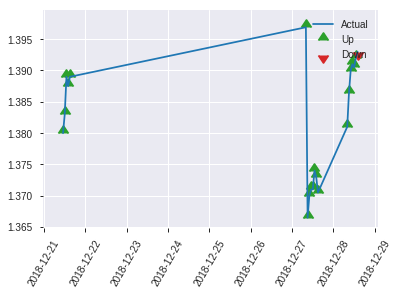


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.30046419597066565
RMSE: 0.5481461447193309
LogLoss: 0.9602641037678732
Mean Per-Class Error: 0.25492880613362545
AUC: 0.7497261774370209
pr_auc: 0.6775959861706243
Gini: 0.4994523548740417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9217427506769468: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      95   15   0.1364   (15.0/110.0)
1      31   52   0.3735   (31.0/83.0)
Total  126  67   0.2383   (46.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.921743     0.693333  66
max f2                       0.0787495    0.796545  188
max f0point5                 0.925768     0.74344   64
max accuracy                 0.925768     0.761658  64
max precision                0.999832     1         0
max recall                   0.0787495    1         188
max specificity              0.999832     1         0
max absolute_mcc             0.925768     0.51035   64
max min_per_class_accuracy   0.829448     0.698795  89
max mean_per_class_accuracy  0.921743     0.745071  66

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 69.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.99949            1.16265   1.16265            0.5              0.999747  0.5                         0.999747            0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.999282           1.16265   1.16265            0.5              0.99939   0.5                         0.999569            0.0120482       0.0240964                  16.2651   16.2651
    3        0.0310881                   0.998376           2.3253    1.5502             1                0.998869  0.666667                    0.999335            0.0240964       0.0481928                  132.53    55.0201
    4        0.0414508                   0.997914           2.3253    1.74398            1                0.998181  0.75                        0.999047            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.995856           1.16265   1.62771            0.5              0.996956  0.7                         0.998629            0.0120482       0.0843373                  16.2651   62.7711
    6        0.103627                    0.988967           2.09277   1.86024            0.9              0.992327  0.8                         0.995478            0.108434        0.192771                   109.277   86.0241
    7        0.150259                    0.983837           2.06693   1.92439            0.888889         0.985524  0.827586                    0.992389            0.0963855       0.289157                   106.693   92.4387
    8        0.202073                    0.976751           1.62771   1.84832            0.7              0.981937  0.794872                    0.989709            0.0843373       0.373494                   62.7711   84.8316
    9        0.300518                    0.930311           1.83576   1.8442             0.789474         0.951308  0.793103                    0.977129            0.180723        0.554217                   83.5764   84.4204
    10       0.398964                    0.888592           0.979074  1.63073            0.421053         0.915175  0.701299                    0.961842            0.0963855       0.650602                   -2.09258  63.0731
    11       0.502591                    0.818523           0.581325  1.41436            0.25             0.848489  0.608247                    0.93847             0.060241        0.710843                   -41.8675  41.4358
    12       0.601036                    0.703146           0.367153  1.24283            0.157895         0.768387  0.534483                    0.910612            0.0361446       0.746988                   -63.2847  24.2833
    13       0.699482                    0.543268           1.10146   1.22294            0.473684         0.604559  0.525926                    0.867537            0.108434        0.855422                   10.1458   22.2936
    14       0.797927                    0.406814           0.611921  1.14755            0.263158         0.482061  0.493506                    0.819979            0.060241        0.915663                   -38.8079  14.7551
    15       0.896373                    0.213288           0.367153  1.06184            0.157895         0.302965  0.456647                    0.763197            0.0361446       0.951807                   -63.2847  6.18427
    16       1                           0.0355224          0.46506   1                  0.2              0.132779  0.430052                    0.697869         

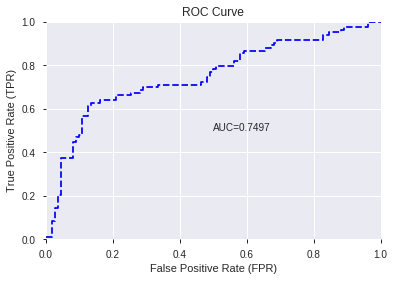

This function is available for GLM models only


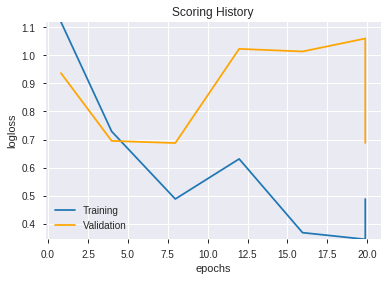

--2019-09-06 02:34:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


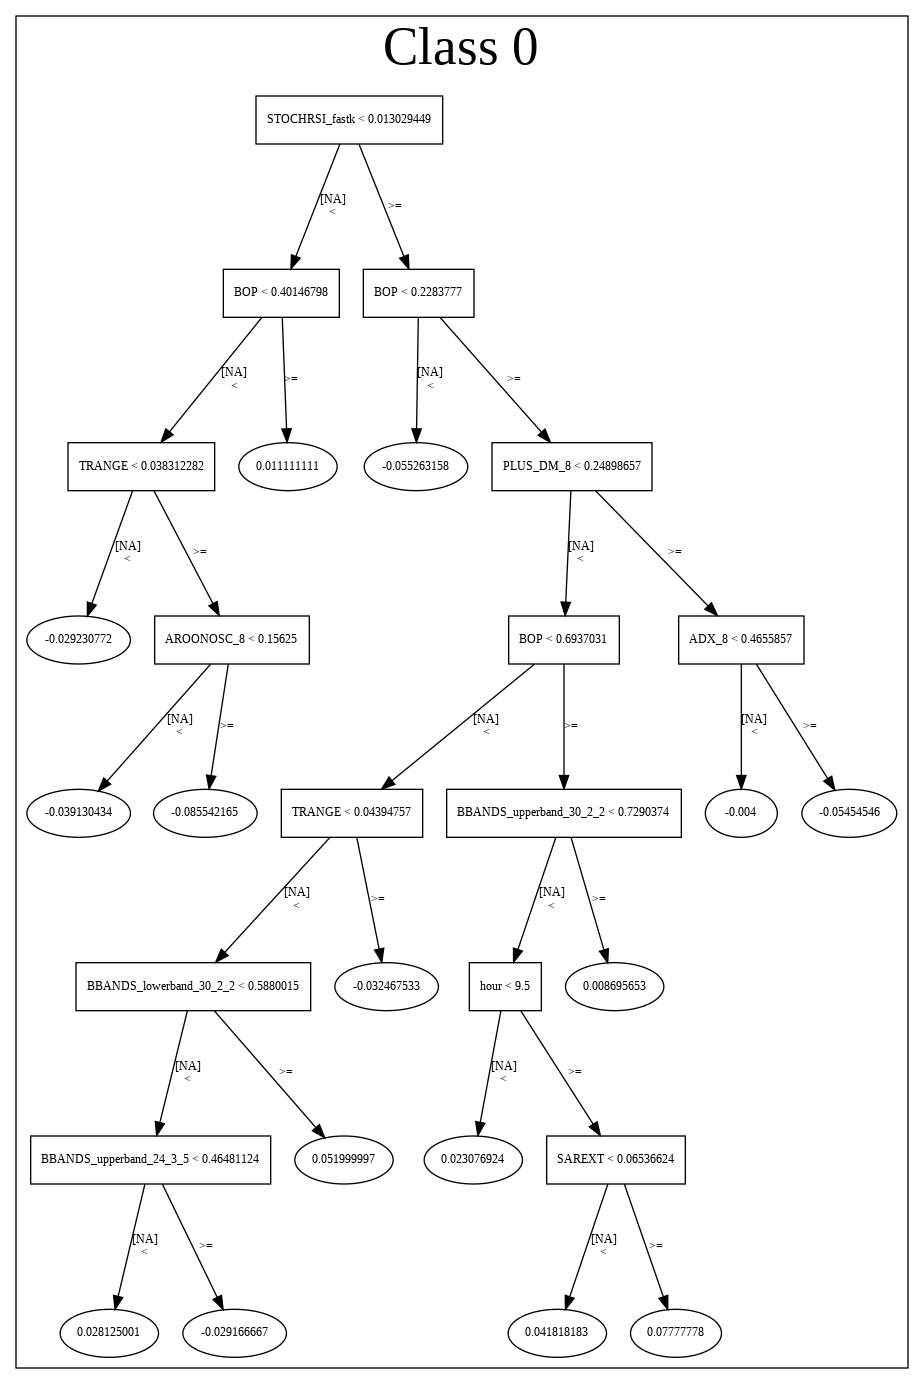

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_022440_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_022440_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLDOJI',
 'OBV',
 'aroonup_8',
 'BBANDS_upperband_20_2_4',
 'STOCHRSI_fastk',
 'ROCP_14',
 'STDDEV_8',
 'LINEARREG_SLOPE_8',
 'PLUS_DM_8',
 'CDLENGULFING',
 'CORREL_12',
 'aroonup_12',
 'WILLR_12',
 'aroondown_20',
 'HT_PHASOR_quadrature',
 'PLUS_DI_30',
 'CMO_24',
 'MINUS_DI_14',
 'BETA_12',
 'MAVP_20_5',
 'BBANDS_lowerband_30_5_3',
 'ROCR_20',
 'MACDFIX_hist_24',
 'PLUS_DI_24',
 'MACDFIX_signal_12',
 'HT_TRENDMODE',
 'ADXR_14',
 'BBANDS_upperband_24_5_2',
 'RSI_20',
 'BBANDS_upperband_20_7_4',
 'DX_20',
 'MA_24_1',
 'ULTOSC',
 'NATR_14',
 'VAR_8',
 'BBANDS_upperband_24_7_5',
 'DX_30',
 'ROC_24',
 'BBANDS_upperband_30_2_5',
 'MACDFIX_hist_14',
 'BBANDS_middleband_24_2_5',
 'ATR_8',
 'MINUS_DI_20',
 'HT_DCPERIOD',
 'ROCP_30',
 'BBANDS_middleband_20_7_5',
 'ROCP_20',
 'MOM_8',
 'MACDFIX_14',
 'BBANDS_lowerband_20_5_5',
 'MOM_24',
 'APO',
 'MACDEXT_hist',
 'BBANDS_lowerband_24_1_2',
 'CORREL_8',
 'BBA

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_023420_model_1  0.758379  0.625611              0.286966  0.467016  0.218104

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.354307           1.000000    0.068980
1          CDLCLOSINGMARUBOZU             0.237862           0.671343    0.046309
2                   aroonup_8             0.232127           0.655159    0.045193
3            CDLDRAGONFLYDOJI             0.222469           0.627900    0.043312
4                    WILLR_12             0.194528           0.549038    0.037872
..                        ...                  ...                ...         ...
144  BBANDS_middleband_24_2_2             0.000992           0.002801    0.000193
145  BBANDS_middleband_24_2_4             0.000811           0.002288    0.000158
146                     DX_14             0.000804           0.002270    0.000157
147  BBANDS_middleband_24_2_5             0.000666           0.001878    0.000130
148                 MAVP_20_3             0.000055           0.000155    0.000011

[149 rows x 4 columns]

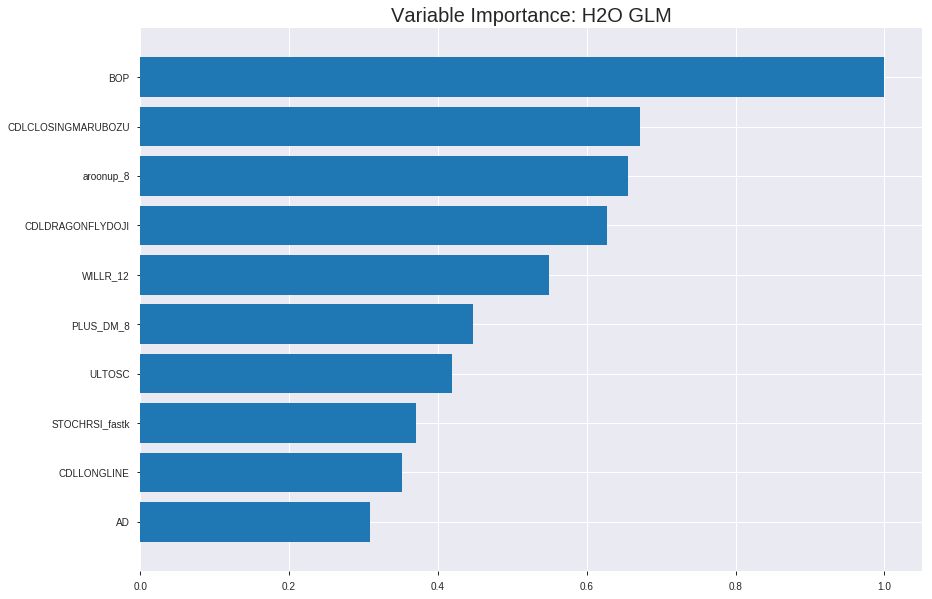

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_023420_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1987848759509436
RMSE: 0.4458529757116617
LogLoss: 0.583917387831927
Null degrees of freedom: 1349
Residual degrees of freedom: 1200
Null deviance: 1867.8661296847088
Residual deviance: 1576.5769471462027
AIC: 1876.5769471462027
AUC: 0.7672535211267606
pr_auc: 0.732604328647028
Gini: 0.5345070422535212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42457239247393674: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      425  285  0.4014   (285.0/710.0)
1      136  504  0.2125   (136.0/640.0)
Total  561  789  0.3119   (421.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424572     0.705388  230
max f2                       0.239787     0.824454  337
max f0point5                 0.560135     0.697536  150
max accuracy                 0.496872     0.708148  186
max precision                0.917128     1         0
max recall                   0.0860366    1         394
max specificity              0.917128     1         0
max absolute_mcc             0.496872     0.413858  186
max min_per_class_accuracy   0.478674     0.7       197
max mean_per_class_accuracy  0.496872     0.70636   186

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.862288           1.65737   1.65737            0.785714         0.877544  0.785714                    0.877544            0.0171875       0.0171875                  65.7366   65.7366
    2        0.02                        0.849886           1.6226    1.64062            0.769231         0.85877   0.777778                    0.868505            0.015625        0.0328125                  62.2596   64.0625
    3        0.0303704                   0.820284           1.65737   1.64634            0.785714         0.833216  0.780488                    0.856455            0.0171875       0.05                       65.7366   64.6341
    4        0.04                        0.810047           1.94712   1.71875            0.923077         0.816181  0.814815                    0.846759            0.01875         0.06875                    94.7115   71.875
    5        0.0503704                   0.795278           1.95871   1.76815            0.928571         0.802512  0.838235                    0.837649            0.0203125       0.0890625                  95.8705   76.8153
    6        0.1                         0.72397            1.85751   1.8125             0.880597         0.762609  0.859259                    0.800407            0.0921875       0.18125                    85.7509   81.25
    7        0.15037                     0.673593           1.70611   1.77686            0.808824         0.697036  0.842365                    0.76578             0.0859375       0.267188                   70.6112   77.6863
    8        0.2                         0.643554           1.79454   1.78125            0.850746         0.659111  0.844444                    0.739311            0.0890625       0.35625                    79.4543   78.125
    9        0.3                         0.584311           1.32812   1.63021            0.62963          0.613085  0.77284                     0.697235            0.132812        0.489063                   32.8125   63.0208
    10       0.4                         0.526515           1.10938   1.5                0.525926         0.556228  0.711111                    0.661983            0.110937        0.6                        10.9375   50
    11       0.5                         0.473706           1.07812   1.41562            0.511111         0.49764   0.671111                    0.629115            0.107813        0.707812                   7.8125    41.5625
    12       0.6                         0.418714           0.84375   1.32031            0.4              0.444356  0.625926                    0.598322            0.084375        0.792188                   -15.625   32.0312
    13       0.7                         0.362343           0.703125  1.23214            0.333333         0.390236  0.584127                    0.568595            0.0703125       0.8625                     -29.6875  23.2143
    14       0.8                         0.309371           0.6875    1.16406            0.325926         0.337578  0.551852                    0.539718            0.06875         0.93125                    -31.25    16.4062
    15       0.9                         0.222355           0.390625  1.07812            0.185185         0.268613  0.511111                    0.509595            0.0390625       0.970313                   -60.9375  7.8125
    16       1                           0.0273197          0.296875  1                  0.140741         0.154383  0.474074                    0.474074            0.02968



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21056762085427227
RMSE: 0.4588764766843821
LogLoss: 0.6088140846271368
Null degrees of freedom: 385
Residual degrees of freedom: 236
Null deviance: 532.8273288418734
Residual deviance: 470.0044733321496
AIC: 770.0044733321496
AUC: 0.7260022166355796
pr_auc: 0.6869533057500253
Gini: 0.45200443327115924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40442789513563465: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  87   0.4163   (87.0/209.0)
1      38   139  0.2147   (38.0/177.0)
Total  160  226  0.3238   (125.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404428     0.689826  225
max f2                       0.202606     0.814501  353
max f0point5                 0.452007     0.659164  188
max accuracy                 0.452007     0.689119  188
max precision                0.903146     1         0
max recall                   0.110187     1         379
max specificity              0.903146     1         0
max absolute_mcc             0.452007     0.377902  188
max min_per_class_accuracy   0.452972     0.684211  187
max mean_per_class_accuracy  0.452007     0.689563  188

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 45.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.874037           2.18079   2.18079            1                0.889999  1                           0.889999            0.0225989       0.0225989                  118.079   118.079
    2        0.0207254                   0.840946           2.18079   2.18079            1                0.858165  1                           0.874082            0.0225989       0.0451977                  118.079   118.079
    3        0.0310881                   0.78807            2.18079   2.18079            1                0.829672  1                           0.859279            0.0225989       0.0677966                  118.079   118.079
    4        0.0414508                   0.759866           1.63559   2.04449            0.75             0.766302  0.9375                      0.836034            0.0169492       0.0847458                  63.5593   104.449
    5        0.0518135                   0.745341           1.63559   1.96271            0.75             0.750028  0.9                         0.818833            0.0169492       0.101695                   63.5593   96.2712
    6        0.101036                    0.701096           1.37734   1.67753            0.631579         0.721648  0.769231                    0.771487            0.0677966       0.169492                   37.7342   67.7532
    7        0.150259                    0.657907           1.72168   1.69199            0.789474         0.677376  0.775862                    0.740658            0.0847458       0.254237                   72.1677   69.1993
    8        0.202073                    0.625413           1.52655   1.64957            0.7              0.639489  0.75641                     0.714717            0.079096        0.333333                   52.6554   64.9573
    9        0.300518                    0.544345           1.0904    1.46639            0.5              0.582878  0.672414                    0.671528            0.107345        0.440678                   9.03955   46.6394
    10       0.401554                    0.495062           1.23019   1.40696            0.564103         0.516234  0.645161                    0.632454            0.124294        0.564972                   23.019    40.6962
    11       0.5                         0.447296           1.31995   1.38983            0.605263         0.470556  0.637306                    0.600578            0.129944        0.694915                   31.9952   38.9831
    12       0.601036                    0.400057           0.950601  1.31599            0.435897         0.422251  0.603448                    0.570601            0.0960452       0.79096                    -4.93988  31.5995
    13       0.699482                    0.351743           0.631282  1.21963            0.289474         0.376332  0.559259                    0.543259            0.0621469       0.853107                   -36.8718  21.9628
    14       0.800518                    0.287284           0.559177  1.13627            0.25641          0.324576  0.521036                    0.515658            0.0564972       0.909605                   -44.0823  13.627
    15       0.898964                    0.222209           0.459114  1.06211            0.210526         0.262995  0.487032                    0.487989            0.0451977       0.954802                   -54.0886  6.21143
    16       1                           0.0622988          0.447342  1                  0.205128         0.153811  0.458549                    0.454225          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-06 02:34:20  0.000 sec   2            .17E2     150           1.3693450961715585  1.3683850334372372
     2019-09-06 02:34:20  0.042 sec   4            .13E2     150           1.3647973394649735  1.3644819272046906
     2019-09-06 02:34:21  0.084 sec   6            .93E1     150           1.3590042201807342  1.359453658769573
     2019-09-06 02:34:21  0.124 sec   8            .67E1     150           1.3517537527337962  1.3530863282282795
     2019-09-06 02:34:21  0.167 sec   10           .49E1     150           1.3428843264992738  1.3451828797028365
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-06 02:34:21  0.812 sec   40           .42E-1    150           1.1607651959176153  1.218478183129923
     2019-09-06 02:34:21  0.852 sec   42           .3E-1     150           1.1545504339799744  1.220666392440313
     2019-09-06 02:34:21  0.894 sec   44           .22E-1    150           1.149135564706391   1.2241740072254053
     2019-09-06 02:34:21  0.935 sec   46           .16E-1    150           1.1444671499473353  1.2291260874475383
     2019-09-06 02:34:21  0.979 sec   48           .12E-1    150           1.1404195169345932  1.235401065016166


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.6783625730994153)

('auc', 0.7583789704271633)

('logloss', 0.6256108412131354)

('mean_per_class_error', 0.28696604600219056)

('rmse', 0.4670159688508952)

('mse', 0.21810391516174032)

glm prediction progress: |████████████████████████████████████████████████| 100%


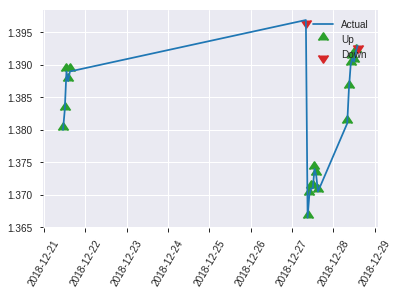


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21810391516174032
RMSE: 0.4670159688508952
LogLoss: 0.6256108412131354
Null degrees of freedom: 192
Residual degrees of freedom: 43
Null deviance: 265.27189969043866
Residual deviance: 241.48578470827022
AIC: 541.4857847082702
AUC: 0.7583789704271633
pr_auc: 0.7038113196447076
Gini: 0.5167579408543266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5833503593749285: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   30   0.2727   (30.0/110.0)
1      25   58   0.3012   (25.0/83.0)
Total  105  88   0.285    (55.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.58335      0.678363  87
max f2                       0.370994     0.804829  164
max f0point5                 0.70486      0.703422  44
max accuracy                 0.70486      0.720207  44
max precision                0.914812     1         0
max recall                   0.175564     1         192
max specificity              0.914812     1         0
max absolute_mcc             0.70486      0.436789  44
max min_per_class_accuracy   0.58335      0.698795  87
max mean_per_class_accuracy  0.58335      0.713034  87

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 56.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.889969           2.3253    2.3253             1                0.905004  1                           0.905004            0.0240964       0.0240964                  132.53    132.53
    2        0.0207254                   0.886019           2.3253    2.3253             1                0.888044  1                           0.896524            0.0240964       0.0481928                  132.53    132.53
    3        0.0310881                   0.875241           2.3253    2.3253             1                0.883517  1                           0.892188            0.0240964       0.0722892                  132.53    132.53
    4        0.0414508                   0.862745           1.16265   2.03464            0.5              0.873141  0.875                       0.887426            0.0120482       0.0843373                  16.2651   103.464
    5        0.0518135                   0.842942           0         1.62771            0                0.851153  0.7                         0.880172            0               0.0843373                  -100      62.7711
    6        0.103627                    0.779856           2.3253    1.97651            1                0.816976  0.85                        0.848574            0.120482        0.204819                   132.53    97.6506
    7        0.150259                    0.746738           1.5502    1.8442             0.666667         0.764136  0.793103                    0.822369            0.0722892       0.277108                   55.0201   84.4204
    8        0.202073                    0.713848           2.09277   1.90794            0.9              0.727171  0.820513                    0.797959            0.108434        0.385542                   109.277   90.7939
    9        0.300518                    0.664207           1.22384   1.68384            0.526316         0.691504  0.724138                    0.763086            0.120482        0.506024                   22.3843   68.3839
    10       0.398964                    0.61518            1.10146   1.54013            0.473684         0.64069   0.662338                    0.732884            0.108434        0.614458                   10.1458   54.0135
    11       0.502591                    0.560782           0.93012   1.41436            0.4              0.587996  0.608247                    0.703011            0.0963855       0.710843                   -6.98795  41.4358
    12       0.601036                    0.517216           0.85669   1.32302            0.368421         0.53991   0.568966                    0.676296            0.0843373       0.795181                   -14.331   32.3016
    13       0.699482                    0.468401           0.611921  1.22294            0.263158         0.496124  0.525926                    0.650938            0.060241        0.855422                   -38.8079  22.2936
    14       0.797927                    0.413862           0.734306  1.16265            0.315789         0.440431  0.5                         0.624967            0.0722892       0.927711                   -26.5694  16.2651
    15       0.896373                    0.311761           0.367153  1.07528            0.157895         0.3685    0.462428                    0.5968              0.0361446       0.963855                   -63.2847  7.52838
    16       1                           0.175564           0.348795  1                  0.15             0.2606    0.430052                    0.56196             

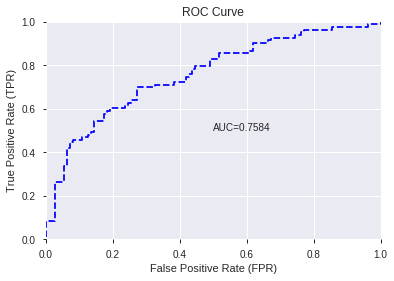

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


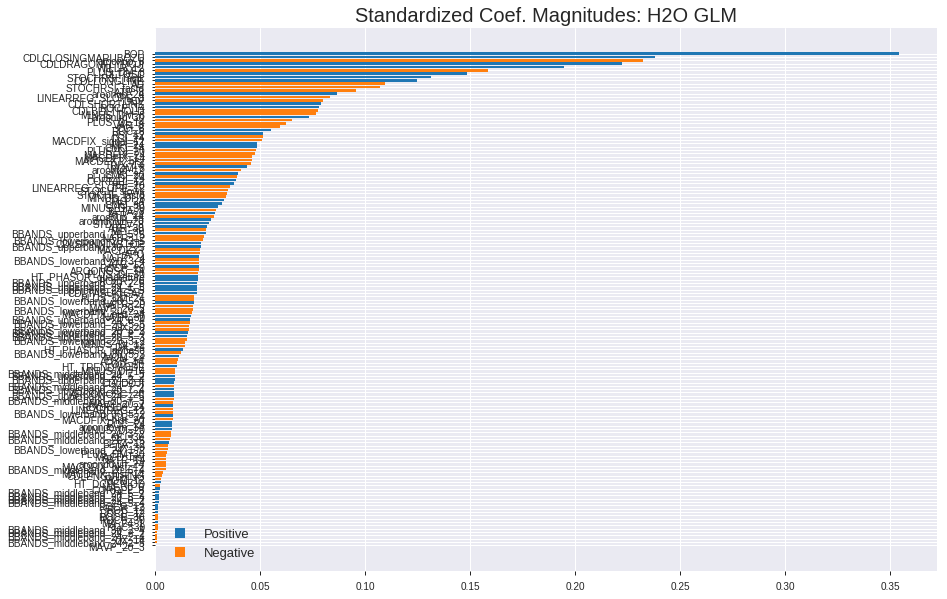

'log_likelihood'
--2019-09-06 02:34:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


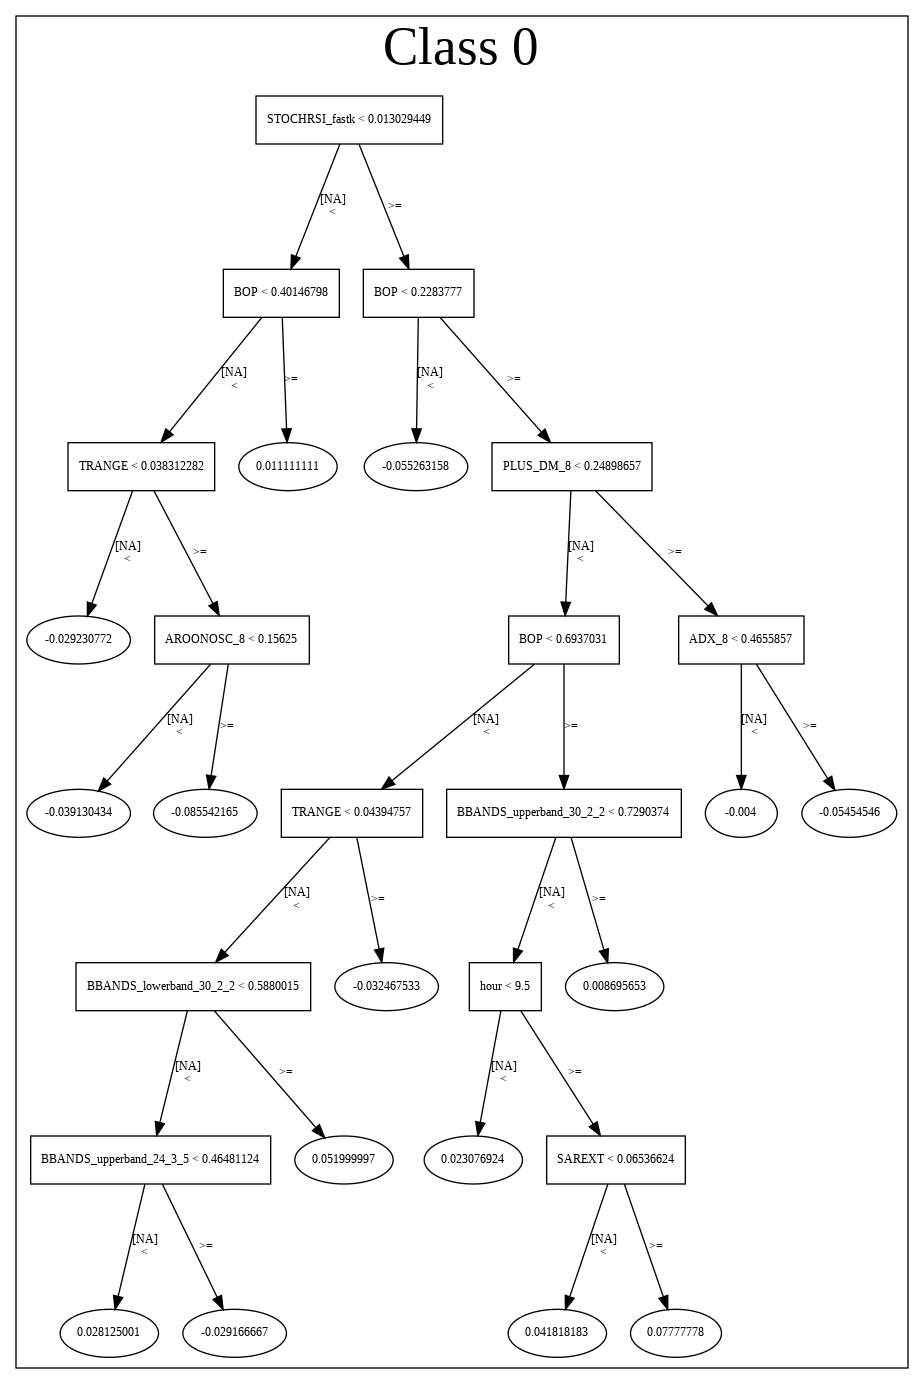

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_023420_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_023420_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLCLOSINGMARUBOZU',
 'aroonup_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_12',
 'PLUS_DM_8',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'AD',
 'STOCHRSI_fastd',
 'ATR_8',
 'aroonup_24',
 'LINEARREG_SLOPE_8',
 'OBV',
 'CDLSHORTLINE',
 'ROCP_14',
 'CDLBELTHOLD',
 'MINUS_DM_8',
 'aroonup_30',
 'PLUS_DI_14',
 'VAR_8',
 'CCI_8',
 'ROC_8',
 'RSI_12',
 'CCI_24',
 'MACDFIX_signal_12',
 'MFI_24',
 'CMO_14',
 'PLUS_DI_20',
 'MACDFIX_24',
 'MACDFIX_14',
 'MACDEXT_hist',
 'TRIX_14',
 'MOM_8',
 'aroonup_12',
 'CMO_20',
 'PLUS_DI_24',
 'CORREL_12',
 'RSI_20',
 'LINEARREG_SLOPE_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MINUS_DI_8',
 'CMO_24',
 'CMO_30',
 'MINUS_DI_30',
 'BETA_8',
 'ATR_24',
 'aroonup_14',
 'aroondown_20',
 'STDDEV_8',
 'ATR_30',
 'MFI_30',
 'BBANDS_upperband_20_5_5',
 'NATR_12',
 'BBANDS_lowerband_20_3_5',
 'CDLSPINNINGTOP',
 'BBANDS_upperband_30_2_5',
 'MACDEXT',
 'APO',
 'NATR_24',
 'BBANDS_lowerband_20_3_4',
 'ATR_12',
 'ROCP_20',
 'AROONOSC_14',
 'PLUS_DI_30',
 'HT_PHASOR_quadr

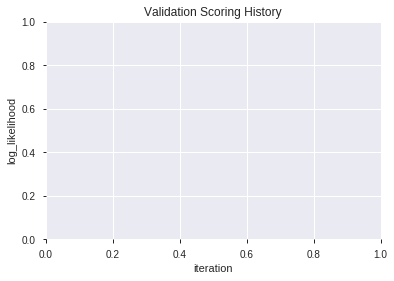

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_023444_model_6  0.786747  0.596611              0.244797  0.451289  0.203662
1               XGBoost_3_AutoML_20190906_023444  0.777108  0.596842              0.253779  0.451647  0.203985
2  XGBoost_grid_1_AutoML_20190906_023444_model_3  0.766703  0.605555              0.279573  0.455898  0.207843
3               XGBoost_2_AutoML_20190906_023444  0.762541  0.602005              0.274699  0.455460  0.207444
4               XGBoost_1_AutoML_20190906_023444  0.760789  0.606058              0.264348  0.457135  0.208972
5  XGBoost_grid_1_AutoML_20190906_023444_model_1  0.760679  0.594416              0.273768  0.451120  0.203509
6  XGBoost_grid_1_AutoML_20190906_023444_model_2  0.759255  0.622720              0.294907  0.464468  0.215731
7  XGBoost_grid_1_AutoML_20190906_023444_model_7  0.750274  0.603693              0.331271  0.456156  0.208078
8  XGBoost_grid_1_AutoML_20190906_023444_model_4  0.736254  0.610724              0.308653  0.458872  0.210564
9  XGBoost_grid_1_AutoML_20190906_023444_model_5  0.732859  0.633501              0.276616  0.470659  0.221520

variable  relative_importance  scaled_importance  percentage
0                         BOP          1254.613647           1.000000    0.143616
1              STOCHRSI_fastd           236.803238           0.188746    0.027107
2          CDLCLOSINGMARUBOZU           223.694672           0.178298    0.025606
3        HT_PHASOR_quadrature           205.728851           0.163978    0.023550
4                         OBV           201.805511           0.160851    0.023101
..                        ...                  ...                ...         ...
131              HT_TRENDMODE             6.953028           0.005542    0.000796
132              LINEARREG_12             6.129770           0.004886    0.000702
133  BBANDS_middleband_20_7_3             5.515737           0.004396    0.000631
134  BBANDS_middleband_20_3_5             5.280384           0.004209    0.000604
135                   ROCR_20             2.634949           0.002100    0.000302

[136 rows x 4 columns]

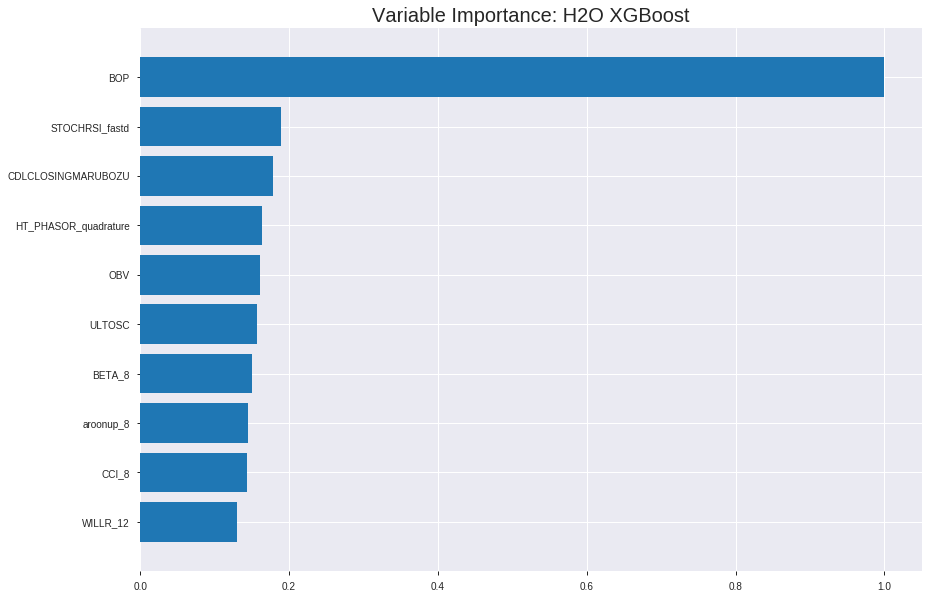

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_023444_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13135575970066574
RMSE: 0.36243035151690284
LogLoss: 0.43173369509358
Mean Per-Class Error: 0.1457966549295775
AUC: 0.9406723151408451
pr_auc: 0.9369923864733796
Gini: 0.8813446302816903
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43829886615276337: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      559  151  0.2127   (151.0/710.0)
1      54   586  0.0844   (54.0/640.0)
Total  613  737  0.1519   (205.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438299     0.851126  223
max f2                       0.36512      0.908959  260
max f0point5                 0.603389     0.880914  137
max accuracy                 0.513266     0.855556  183
max precision                0.918669     1         0
max recall                   0.199172     1         343
max specificity              0.918669     1         0
max absolute_mcc             0.513266     0.710265  183
max min_per_class_accuracy   0.490336     0.848437  194
max mean_per_class_accuracy  0.513266     0.854203  183

Gains/Lift Table: Avg response rate: 47.41 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.881535           2.10938   2.10938            1                0.895969  1                           0.895969            0.021875        0.021875                   110.938   110.938
    2        0.02                        0.855064           2.10938   2.10938            1                0.868252  1                           0.882624            0.0203125       0.0421875                  110.938   110.938
    3        0.0303704                   0.8447             2.10938   2.10938            1                0.849839  1                           0.871429            0.021875        0.0640625                  110.938   110.938
    4        0.04                        0.830187           2.10938   2.10938            1                0.837286  1                           0.86321             0.0203125       0.084375                   110.938   110.938
    5        0.0503704                   0.819908           2.10938   2.10938            1                0.82527   1                           0.855398            0.021875        0.10625                    110.938   110.938
    6        0.1                         0.772088           2.10938   2.10938            1                0.797801  1                           0.826813            0.104688        0.210938                   110.938   110.938
    7        0.15037                     0.736066           2.07835   2.09898            0.985294         0.752646  0.995074                    0.801969            0.104688        0.315625                   107.835   109.898
    8        0.2                         0.693372           2.07789   2.09375            0.985075         0.715036  0.992593                    0.780397            0.103125        0.41875                    107.789   109.375
    9        0.3                         0.62833            1.9375    2.04167            0.918519         0.661655  0.967901                    0.740816            0.19375         0.6125                     93.75     104.167
    10       0.4                         0.554339           1.4375    1.89062            0.681481         0.590364  0.896296                    0.703203            0.14375         0.75625                    43.75     89.0625
    11       0.5                         0.474191           1.125     1.7375             0.533333         0.515207  0.823704                    0.665604            0.1125          0.86875                    12.5      73.75
    12       0.6                         0.400694           0.828125  1.58594            0.392593         0.437195  0.751852                    0.627536            0.0828125       0.951562                   -17.1875  58.5938
    13       0.7                         0.330047           0.296875  1.40179            0.140741         0.363602  0.66455                     0.589831            0.0296875       0.98125                    -70.3125  40.1786
    14       0.8                         0.252584           0.171875  1.24805            0.0814815        0.288541  0.591667                    0.55217             0.0171875       0.998437                   -82.8125  24.8047
    15       0.9                         0.176549           0.015625  1.11111            0.00740741       0.213019  0.526749                    0.514486            0.0015625       1                          -98.4375  11.1111
    16       1                           0.0776665          0         1                  0                0.142382  0.474074                    0.477276           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21100441198022393
RMSE: 0.4593521655333998
LogLoss: 0.6101475682570062
Mean Per-Class Error: 0.32303408753007323
AUC: 0.7269213094369205
pr_auc: 0.6971047780391653
Gini: 0.4538426188738409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4355047941207886: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  94   0.4498   (94.0/209.0)
1      40   137  0.226    (40.0/177.0)
Total  155  231  0.3472   (134.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435505     0.671569  230
max f2                       0.162051     0.81793   373
max f0point5                 0.573002     0.668277  110
max accuracy                 0.573002     0.683938  110
max precision                0.867055     1         0
max recall                   0.162051     1         373
max specificity              0.867055     1         0
max absolute_mcc             0.588956     0.371065  97
max min_per_class_accuracy   0.484252     0.666667  186
max mean_per_class_accuracy  0.492401     0.676966  178

Gains/Lift Table: Avg response rate: 45.85 %, avg score: 46.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.785707           1.63559   1.63559            0.75             0.826856  0.75                        0.826856            0.0169492       0.0169492                  63.5593   63.5593
    2        0.0207254                   0.76889            1.63559   1.63559            0.75             0.773851  0.75                        0.800354            0.0169492       0.0338983                  63.5593   63.5593
    3        0.0310881                   0.7591             2.18079   1.81733            1                0.764104  0.833333                    0.78827             0.0225989       0.0564972                  118.079   81.7326
    4        0.0414508                   0.745237           2.18079   1.90819            1                0.754318  0.875                       0.779782            0.0225989       0.079096                   118.079   90.8192
    5        0.0518135                   0.730801           2.18079   1.96271            1                0.734789  0.9                         0.770784            0.0225989       0.101695                   118.079   96.2712
    6        0.101036                    0.68601            1.83646   1.9012             0.842105         0.699219  0.871795                    0.735919            0.0903955       0.19209                    83.6456   90.1202
    7        0.150259                    0.637353           1.6069    1.80479            0.736842         0.664898  0.827586                    0.712653            0.079096        0.271186                   60.6899   80.4793
    8        0.202073                    0.614839           1.52655   1.73345            0.7              0.627752  0.794872                    0.690884            0.079096        0.350282                   52.6554   73.3449
    9        0.300518                    0.566402           1.20517   1.56039            0.552632         0.588242  0.715517                    0.65726             0.118644        0.468927                   20.5174   56.0394
    10       0.401554                    0.523723           1.06244   1.4351             0.487179         0.545952  0.658065                    0.629253            0.107345        0.576271                   6.24366   43.5101
    11       0.5                         0.480251           1.03301   1.35593            0.473684         0.500496  0.621762                    0.603902            0.101695        0.677966                   3.30062   35.5932
    12       0.601036                    0.433973           0.950601  1.28779            0.435897         0.457944  0.590517                    0.579366            0.0960452       0.774011                   -4.93988  28.7795
    13       0.699482                    0.379078           0.516503  1.17924            0.236842         0.403791  0.540741                    0.554656            0.0508475       0.824859                   -48.3497  17.9243
    14       0.800518                    0.301901           0.782848  1.12921            0.358974         0.342464  0.517799                    0.527874            0.079096        0.903955                   -21.7152  12.9212
    15       0.898964                    0.225023           0.573892  1.0684             0.263158         0.259182  0.489914                    0.49845             0.0564972       0.960452                   -42.6108  6.8399
    16       1                           0.0906015          0.391424  1                  0.179487         0.180002  0.458549                    0.466275          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:34:53  5.770 sec   0                  0.5              0.693147            0.5             0                  1                0.525926                         0.5                0.693147              0.5               0                    1                  0.541451
    2019-09-06 02:34:53  5.847 sec   5                  0.475701         0.645454            0.835755        0.821555           2.10938          0.271111                         0.489383           0.672054              0.694713          0.643734             1.74463            0.388601
    2019-09-06 02:34:53  5.901 sec   10                 0.455113         0.605987            0.859936        0.851229           2.10938          0.252593                         0.479814           0.653139              0.711297          0.663075             1.63559            0.388601
    2019-09-06 02:34:53  5.942 sec   15                 0.439797         0.576737            0.872366        0.866257           2.10938          0.248148                         0.476145           0.645605              0.704863          0.658434             2.18079            0.398964
    2019-09-06 02:34:53  5.981 sec   20                 0.428744         0.555437            0.877431        0.871439           2.10938          0.245185                         0.472019           0.637099              0.706918          0.671231             2.18079            0.380829
    2019-09-06 02:34:53  6.025 sec   25                 0.417141         0.533413            0.89046         0.884157           2.10938          0.205185                         0.468888           0.630893              0.718947          0.669925             1.63559            0.360104
    2019-09-06 02:34:53  6.074 sec   30                 0.408921         0.517549            0.895838        0.891432           2.10938          0.200741                         0.465738           0.624426              0.725732          0.682704             2.18079            0.326425
    2019-09-06 02:34:54  6.118 sec   35                 0.400923         0.50222             0.902874        0.89969            2.10938          0.197037                         0.463496           0.619873              0.728435          0.690613             1.63559            0.349741
    2019-09-06 02:34:54  6.161 sec   40                 0.393702         0.488555            0.909119        0.90628            2.10938          0.184444                         0.462246           0.617043              0.726651          0.689907             1.63559            0.370466
    2019-09-06 02:34:54  6.203 sec   45                 0.386401         0.475364            0.917355        0.912848           2.10938          0.175556                         0.460638           0.613399              0.728111          0.699124             1.63559            0.378238
    2019-09-06 02:34:54  6.257 sec   50                 0.379386         0.462337            0.924453        0.920376           2.10938          0.165185                         0.460163           0.612258              0.72803           0.698027             1.63559            0.380829
    2019-09-06 02:34:54  6.302 sec   55                 0.374204         0.452677            0.928606        0.925301           2.10938          0.156296                         0.459351           0.61051               0.730192          0

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       1254.6136474609375     1.0                    0.14361616284224837
STOCHRSI_fastd            236.80323791503906     0.18874594453382268    0.027106968305983456
CDLCLOSINGMARUBOZU        223.69467163085938     0.17829765528501007    0.02560642509580307
HT_PHASOR_quadrature      205.72885131835938     0.16397785225332864    0.023549869931736193
OBV                       201.80551147460938     0.16085072235824902    0.02310076353549557
---                       ---                    ---                    ---
HT_TRENDMODE              6.953027725219727      0.005541967233730581   0.0007959160687058559
LINEARREG_12              6.129769802093506      0.004885782818080143   0.000701677380813257
BBANDS_middleband_20_7_3  5.515737056732178      0.004396363030080869   0.0006313887888417344
BBANDS_middleband_20_3_5  5.280383586883545      0.004208772634962071   0.0006044477761087115
ROCR_20                   2.63494873046875       0.0021002072915445383  0.0003016237123849378


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7512953367875648)

('F1', 0.7303370786516855)

('auc', 0.7867469879518073)

('logloss', 0.5966111573187641)

('mean_per_class_error', 0.2447973713033954)

('rmse', 0.45128898025723646)

('mse', 0.20366174370161635)

xgboost prediction progress: |████████████████████████████████████████████| 100%


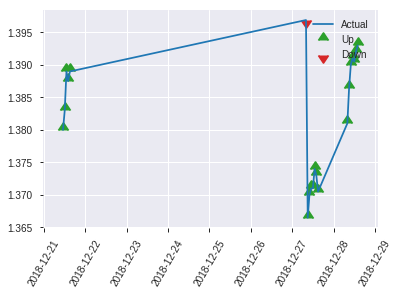


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20366174370161635
RMSE: 0.45128898025723646
LogLoss: 0.5966111573187641
Mean Per-Class Error: 0.2447973713033954
AUC: 0.7867469879518073
pr_auc: 0.6975968713988885
Gini: 0.5734939759036146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5149009227752686: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   30   0.2727   (30.0/110.0)
1      18   65   0.2169   (18.0/83.0)
Total  98   95   0.2487   (48.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514901     0.730337  94
max f2                       0.353244     0.813008  159
max f0point5                 0.59597      0.714286  57
max accuracy                 0.514901     0.751295  94
max precision                0.809134     1         0
max recall                   0.237486     1         190
max specificity              0.809134     1         0
max absolute_mcc             0.514901     0.505447  94
max min_per_class_accuracy   0.520712     0.727273  90
max mean_per_class_accuracy  0.514901     0.755203  94

Gains/Lift Table: Avg response rate: 43.01 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.775391           1.16265   1.16265            0.5              0.794516  0.5                         0.794516            0.0120482       0.0120482                  16.2651   16.2651
    2        0.0207254                   0.757287           2.3253    1.74398            1                0.769155  0.75                        0.781835            0.0240964       0.0361446                  132.53    74.3976
    3        0.0310881                   0.749474           1.16265   1.5502             0.5              0.754162  0.666667                    0.772611            0.0120482       0.0481928                  16.2651   55.0201
    4        0.0414508                   0.744078           2.3253    1.74398            1                0.748039  0.75                        0.766468            0.0240964       0.0722892                  132.53    74.3976
    5        0.0518135                   0.731211           2.3253    1.86024            1                0.738083  0.8                         0.760791            0.0240964       0.0963855                  132.53    86.0241
    6        0.103627                    0.686769           2.09277   1.97651            0.9              0.708681  0.85                        0.734736            0.108434        0.204819                   109.277   97.6506
    7        0.150259                    0.658675           2.06693   2.00457            0.888889         0.671171  0.862069                    0.715009            0.0963855       0.301205                   106.693   100.457
    8        0.202073                    0.643537           0.93012   1.72907            0.4              0.651338  0.74359                     0.698683            0.0481928       0.349398                   -6.98795  72.907
    9        0.300518                    0.59533            1.95815   1.80411            0.842105         0.613832  0.775862                    0.670887            0.192771        0.542169                   95.8148   80.4113
    10       0.398964                    0.55202            0.979074  1.60053            0.421053         0.57272   0.688312                    0.646664            0.0963855       0.638554                   -2.09258  60.0532
    11       0.502591                    0.513645           1.39518   1.55819            0.6              0.530809  0.670103                    0.622776            0.144578        0.783133                   39.5181   55.8192
    12       0.601036                    0.473354           0.611921  1.4032             0.263158         0.491802  0.603448                    0.601324            0.060241        0.843373                   -38.8079  40.3199
    13       0.699482                    0.432076           0.489537  1.27461            0.210526         0.450123  0.548148                    0.580044            0.0481928       0.891566                   -51.0463  27.461
    14       0.797927                    0.366015           0.489537  1.17775            0.210526         0.408299  0.506494                    0.558854            0.0481928       0.939759                   -51.0463  17.775
    15       0.896373                    0.296317           0.367153  1.08872            0.157895         0.33908   0.468208                    0.534717            0.0361446       0.975904                   -63.2847  8.87248
    16       1                           0.173728           0.23253   1                  0.1              0.26317   0.430052                    0.506578            

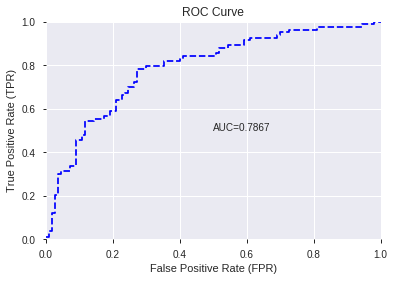

This function is available for GLM models only


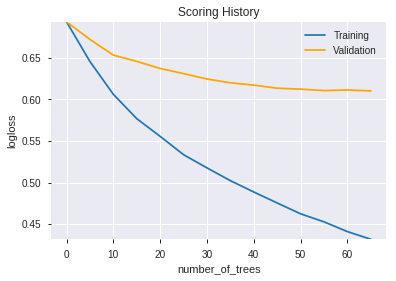

--2019-09-06 02:35:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

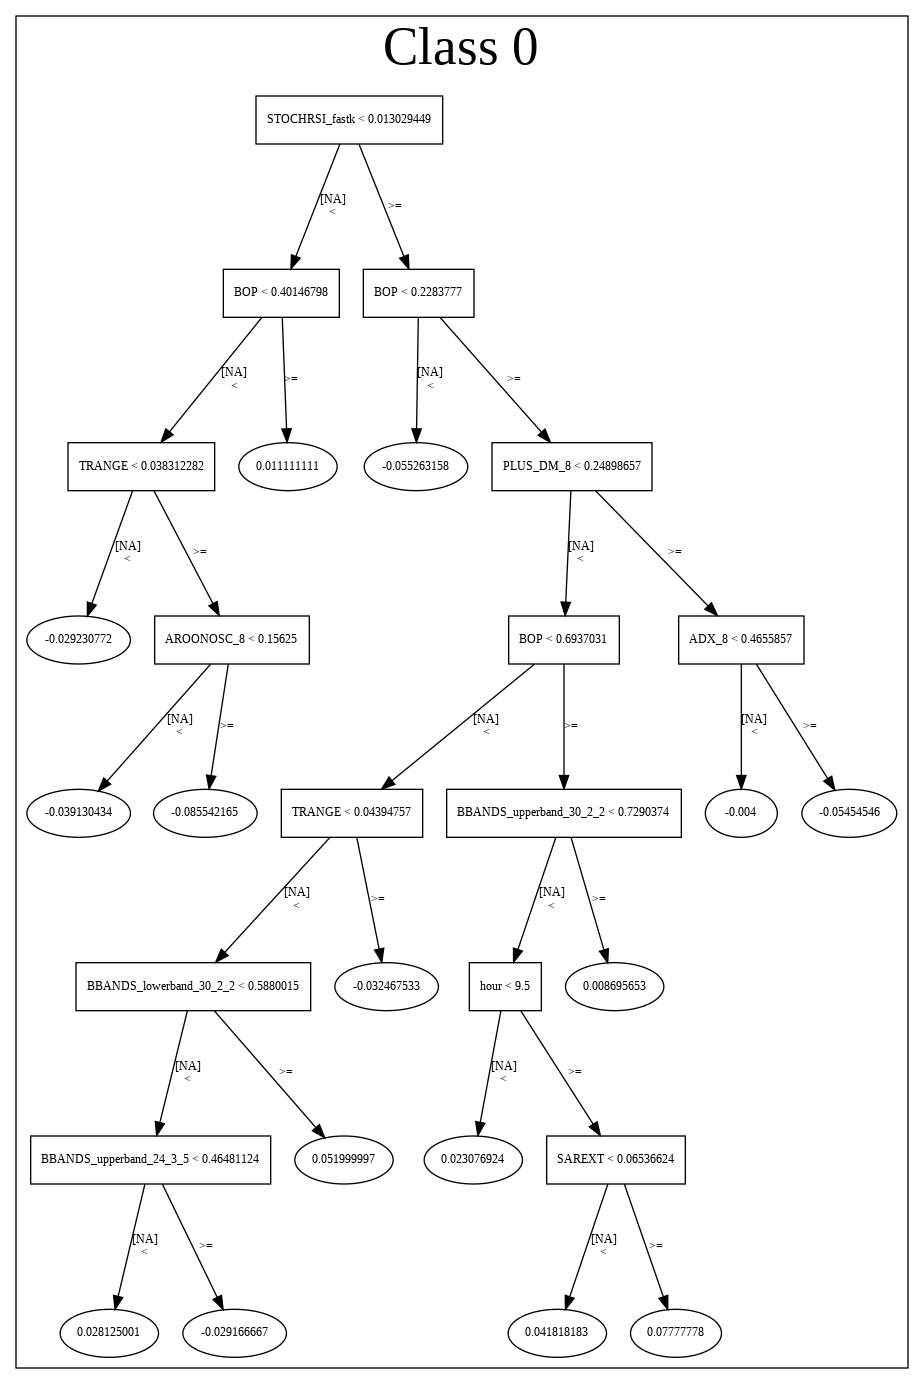

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_023444_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_023444_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_be9c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHRSI_fastd',
 'CDLCLOSINGMARUBOZU',
 'HT_PHASOR_quadrature',
 'OBV',
 'ULTOSC',
 'BETA_8',
 'aroonup_8',
 'CCI_8',
 'WILLR_12',
 'CDLDRAGONFLYDOJI',
 'PLUS_DM_8',
 'ATR_8',
 'CORREL_12',
 'STOCHRSI_fastk',
 'DX_14',
 'HT_PHASOR_inphase',
 'HT_DCPERIOD',
 'ADXR_14',
 'MACDEXT_hist',
 'DX_20',
 'BETA_12',
 'CDLSHORTLINE',
 'STOCH_slowk',
 'MINUS_DI_8',
 'MFI_30',
 'CORREL_8',
 'ROCP_14',
 'PLUS_DM_24',
 'aroonup_12',
 'PLUS_DI_14',
 'ROC_30',
 'ATR_24',
 'STDDEV_8',
 'MOM_8',
 'RSI_12',
 'DX_30',
 'aroonup_24',
 'PLUS_DM_30',
 'CDLBELTHOLD',
 'PLUS_DI_20',
 'MFI_24',
 'MINUS_DM_8',
 'MACDFIX_hist_12',
 'LINEARREG_SLOPE_8',
 'LINEARREG_SLOPE_12',
 'MINUS_DI_30',
 'ROC_24',
 'MACDFIX_hist_24',
 'CCI_24',
 'BBANDS_upperband_30_2_5',
 'ROC_8',
 'BBANDS_upperband_20_5_3',
 'PLUS_DI_30',
 'AD',
 'ROCP_20',
 'MACDFIX_signal_12',
 'MAVP_20_3',
 'DX_24',
 'aroonup_30',
 'PLUS_DI_24',
 'NATR_14',
 'MA_30_0',
 'BBANDS_lowerband_20_5_5',
 'aroonup_14',
 'MACDFIX_14',
 'STOCHF_fastd',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.762
GLM             0.731
XGBoost         0.751
dtype: float64

DeepLearning    GLM  XGBoost
All          0.741  0.731    0.720
DLF          0.715  0.715    0.715
Fwe          0.756  0.731    0.715
RFE          0.762  0.720    0.751
XGBF         0.694  0.715    0.715





F1


DeepLearning    0.697
GLM             0.692
XGBoost         0.730
dtype: float64

DeepLearning    GLM  XGBoost
All          0.688  0.688    0.695
DLF          0.683  0.679    0.686
Fwe          0.697  0.692    0.699
RFE          0.693  0.678    0.730
XGBF         0.667  0.679    0.686





auc


DeepLearning    0.785
GLM             0.777
XGBoost         0.787
dtype: float64

DeepLearning    GLM  XGBoost
All          0.765  0.760    0.778
DLF          0.753  0.741    0.761
Fwe          0.785  0.777    0.754
RFE          0.750  0.758    0.787
XGBF         0.748  0.741    0.761





logloss


DeepLearning    1.200
GLM             0.626
XGBoost         0.597
dtype: float64

DeepLearning    GLM  XGBoost
All          1.200  0.609    0.584
DLF          0.696  0.596    0.586
Fwe          0.573  0.573    0.590
RFE          0.960  0.626    0.597
XGBF         0.584  0.596    0.586





mean_per_class_error


DeepLearning    0.313
GLM             0.311
XGBoost         0.293
dtype: float64

DeepLearning    GLM  XGBoost
All          0.276  0.293    0.281
DLF          0.308  0.311    0.293
Fwe          0.261  0.287    0.281
RFE          0.255  0.287    0.245
XGBF         0.313  0.311    0.293





rmse


DeepLearning    0.610
GLM             0.467
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.610  0.459    0.447
DLF          0.465  0.453    0.448
Fwe          0.443  0.441    0.451
RFE          0.548  0.467    0.451
XGBF         0.447  0.453    0.448





mse


DeepLearning    0.372
GLM             0.218
XGBoost         0.204
dtype: float64

DeepLearning    GLM  XGBoost
All          0.372  0.211    0.200
DLF          0.217  0.205    0.201
Fwe          0.196  0.195    0.203
RFE          0.300  0.218    0.204
XGBF         0.200  0.205    0.201

{'F1':       DeepLearning    GLM  XGBoost
 All          0.688    NaN      NaN
 DLF          0.683    NaN      NaN
 DLF            NaN  0.679      NaN
 DLF            NaN    NaN    0.686
 All            NaN  0.688      NaN
 All            NaN    NaN    0.695
 XGBF         0.667    NaN      NaN
 XGBF           NaN  0.679      NaN
 XGBF           NaN    NaN    0.686
 Fwe          0.697    NaN      NaN
 Fwe            NaN  0.692      NaN
 Fwe            NaN    NaN    0.699
 RFE          0.693    NaN      NaN
 RFE            NaN  0.678      NaN
 RFE            NaN    NaN    0.730,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.741    NaN      NaN
 DLF          0.715    NaN      NaN
 DLF            NaN  0.715      NaN
 DLF            NaN    NaN    0.715
 All            NaN  0.731      NaN
 All            NaN    NaN    0.720
 XGBF         0.694    NaN      NaN
 XGBF           NaN  0.715      NaN
 XGBF           NaN    NaN    0.715
 Fwe          0.756    NaN      NaN
 Fwe     